# Импорт

* Разбиение данных по установкам
М1 - привели к отказу, М3 -нет
горизонт рула от 3 часов до месяца

In [1]:
import gc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import QuantileTransformer
from tqdm import tqdm
import seaborn as sns


import os, sys
project_path = os.path.abspath('../../')
project_path = os.path.abspath('../')

if project_path not in sys.path:
    sys.path.append(project_path)

# from utils.plot_utils import fast_hist, fast_plot, fast_bar, fast_legend, fast_scatter, Pairs_plot

# pd.set_option('display.max_colwidth', None)


import sys
sys.path.insert(1, 'C:/Users/kompn/YandexDisk/tsad/')
from tsad.useful.ts import split_by_repeated
from tsad.eda.samplingRate import value_counts_interval
from IPython.display import display, HTML



# Важные функции

In [2]:
def get_cols(num):
    return [x for x in X_train.columns if f'ЭКСГАУСТЕР {num}.' in x]
def get_faults(num):
    return [x for x in y_train.columns if f'Y_ЭКСГАУСТЕР А/М №{num}' in x]

def rename_y_train_col(x):
    x = x.split('_')[2]
    pair = None
    if ' ЭКСГ.' in x:
        pair = x.split(' ЭКСГ.')
    elif ' ЭКСГАУСТЕРА' in x:
        pair = x.split(' ЭКСГАУСТЕРА')
    elif 'ЭКСГАУСТЕР А/М 'in x:
        pair = x.split(' А/М')
        pair[0] = pair[0] + '  А/М'
#         pair[-1] = pair[-1] + '__'
    elif ' ЭКСГ ' in x:
        pair = x.split(' ЭКСГ')

    if pair is not None:
        if len(pair)>2:
            raise
        try:
            x = pair[0] + pair[1].split('№')[1][1:]
        except:
            print(x)
    for num in nums:
        x = x.replace(f'ЭКСГ{num}','')
    return x

    
    
nums = [4,5,6,7,8,9]
len(nums)

6

# Загрузка данных

In [3]:
X_train = pd.read_parquet(f'{project_path}/data/raw/X_train.parquet')
X_test = pd.read_parquet(f'{project_path}/data/raw/X_test.parquet')

X_train.columns = [x.replace('ТОК РОТОРА2', 'ТОК РОТОРА 2') for x in X_train.columns]
X_test.columns = [x.replace('ТОК РОТОРА2', 'ТОК РОТОРА 2') for x in X_test.columns]

In [4]:
y_train = pd.read_parquet(f'{project_path}/data/raw/y_train.parquet').astype(np.int8)

In [5]:
path = f'{project_path}/data/processed/toir_train.parquet'
toir =  pd.read_parquet(path) 

In [6]:
toir = pd.read_excel('../data/messages.xlsx',index_col=0)

toir['num'] = toir['ИМЯ_МАШИНЫ'].apply(lambda x: int(x.split('№')[-1]))
toir['label'] = toir['ВИД_СООБЩЕНИЯ'].apply(lambda x: int(x[-1].replace('3','2')))
toir.drop(columns=['ИМЯ_МАШИНЫ','ВИД_СООБЩЕНИЯ'], inplace=True)
toir = toir.rename(columns={'ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ':'t1','ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ':'t2'})
toir = toir.iloc[3:]

In [7]:
mytoir = pd.read_excel('../data/processed/Processed_toir2.xlsx').set_index('Номер')['Причина']
t_test = pd.Timestamp('2020-09-27 16:42:02')

# Простейший  EDA

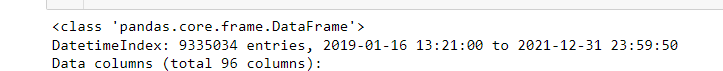

In [11]:
print("Количество признаков на один ЭКСГАУСТЕР",X_train.shape[1]/len(nums))
print("Общее количество неисправноестей",y_train.shape[1])
print("Количество неисправноестей на аггрегат",y_train.shape[1]/len(nums))

print("Совпадают ли индексы трейна и теста:", (X_train.index == y_train.index).all())

print("Какие варианты времени между индексами:")
X_train.index.to_series().diff().value_counts()

Количество признаков на один ЭКСГАУСТЕР 16.0
Общее количество неисправноестей 175
Количество неисправноестей на аггрегат 29.166666666666668
Совпадают ли индексы трейна и теста: True
Какие варианты времени между индексами:


0 days 00:00:10    9335033
Name: DT, dtype: int64

# Проблемы с названиями неисправностей of  y_train

## Просто немного про названия неиспраностей

In [12]:
suka = [x for x in y_train.columns if 'ЭКСГ' in x.split('_')[2]]
suka = [x for x in suka if not( ('ЭКСГ.' in x) or ('ЭКСГАУСТЕРА' in x) or('ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400' in x))]
suka

['Y_ЭКСГАУСТЕР А/М №9_ЭКСГАУСТЕР А/М №9',
 'Y_ЭКСГАУСТЕР А/М №5_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ1',
 'Y_ЭКСГАУСТЕР А/М №5_ЭКСГАУСТЕР А/М №5',
 'Y_ЭКСГАУСТЕР А/М №5_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ2',
 'Y_ЭКСГАУСТЕР А/М №5_ЭКСГАУСТЕР Н-8000 А/М №5',
 'Y_ЭКСГАУСТЕР А/М №8_ЭКСГАУСТЕР А/М №8',
 'Y_ЭКСГАУСТЕР А/М №4_ЭКСГАУСТЕР А/М №4',
 'Y_ЭКСГАУСТЕР А/М №4_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ4 ВУ1',
 'Y_ЭКСГАУСТЕР А/М №4_МАСЛОПРОВОДЫ ЭКСГ №4',
 'Y_ЭКСГАУСТЕР А/М №7_ЭКСГАУСТЕР А/М №7',
 'Y_ЭКСГАУСТЕР А/М №6_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГ №6',
 'Y_ЭКСГАУСТЕР А/М №6_ЭКСГАУСТЕР А/М №6',
 'Y_ЭКСГАУСТЕР А/М №6_МАСЛОПРОВОДЫ ЭКСГ №6']

In [13]:
[x for x in y_train.columns if 'ТИРИСТ' in x]


['Y_ЭКСГАУСТЕР А/М №9_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ9 ВУ1',
 'Y_ЭКСГАУСТЕР А/М №5_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ1',
 'Y_ЭКСГАУСТЕР А/М №5_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ2',
 'Y_ЭКСГАУСТЕР А/М №8_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5',
 'Y_ЭКСГАУСТЕР А/М №8_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ8 ВУ1',
 'Y_ЭКСГАУСТЕР А/М №4_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ4 ВУ1',
 'Y_ЭКСГАУСТЕР А/М №7_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ7 ВУ1',
 'Y_ЭКСГАУСТЕР А/М №6_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ6 ВУ1']

In [14]:
[x for x in y_train.columns if 'ПОДШИПНИК ОПОРНЫЙ' in x]


['Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №9',
 'Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ №2',
 'Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ №1',
 'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №5',
 'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ №2',
 'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ №1',
 'Y_ЭКСГАУСТЕР А/М №8_ПОДШИПНИК ОПОРНЫЙ №2',
 'Y_ЭКСГАУСТЕР А/М №8_ПОДШИПНИК ОПОРНЫЙ №1',
 'Y_ЭКСГАУСТЕР А/М №8_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №8',
 'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4',
 'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4',
 'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №1 ЭКСГ. №4',
 'Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНЫЙ №1',
 'Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНЫЙ №2',
 'Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №7',
 'Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ №2',
 'Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ №1',
 'Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №6']

## Унификация неисправностей (попытка)

In [19]:
y_train_cols = []
for num in nums:
#     print(num)
    ts = pd.Series(1, index = sorted([rename_y_train_col(x) for x in y_train.columns if f'№{num}' in x]))
#     print(ts[ts.index.duplicated(keep='first')])
#     ts = ts[~ts.index.duplicated(keep='first')]
    y_train_cols.append(ts)
#     print()
#     print()
y_train_cols = pd.concat(y_train_cols,axis=1)
y_train_cols.columns = nums
print("МИНИМАЛЬНОЕ Количество ТИПОВ неисправностей, которые я смог найти ",len(y_train_cols))

МИНИМАЛЬНОЕ Количество ТИПОВ неисправностей, которые я смог найти  59


In [21]:
pd.options.display.max_rows = 999
display(y_train_cols)
pd.reset_option("display.max_rows")

,4,5,6,7,8,9
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ Т.1,1.0,1.0,NaN,NaN,NaN,1.0
ГСМ,1.0,1.0,NaN,1.0,1.0,1.0
ЗАДВИЖКА,1.0,1.0,1.0,1.0,1.0,1.0
ЗАП. И РЕГ. АРМАТУРА,1.0,NaN,NaN,NaN,NaN,NaN
КЛ1 ТР№4 ДО ЭД,1.0,NaN,NaN,NaN,NaN,NaN
КЛ2 ТР№4 ДО ЭД,1.0,NaN,NaN,NaN,NaN,NaN
МАСЛОНАСОС РАБОЧИЙ,1.0,1.0,1.0,1.0,1.0,1.0
МАСЛООХЛАДИТЕЛЬ М-05-1,1.0,1.0,1.0,1.0,1.0,1.0
МАСЛОПРОВОДЫ,1.0,1.0,1.0,1.0,1.0,1.0
ПОДШИПНИК ОПОРНО-УПОРНЫЙ,1.0,1.0,1.0,1.0,1.0,1.0


## Неиспровности присущие для всех ЭКСГАУСТЕР

In [22]:
tager_faults = y_train_cols[(~y_train_cols.isna()).all(1)]

In [23]:
tager_faults

,4,5,6,7,8,9
ЗАДВИЖКА,1.0,1.0,1.0,1.0,1.0,1.0
МАСЛОНАСОС РАБОЧИЙ,1.0,1.0,1.0,1.0,1.0,1.0
МАСЛООХЛАДИТЕЛЬ М-05-1,1.0,1.0,1.0,1.0,1.0,1.0
МАСЛОПРОВОДЫ,1.0,1.0,1.0,1.0,1.0,1.0
ПОДШИПНИК ОПОРНО-УПОРНЫЙ,1.0,1.0,1.0,1.0,1.0,1.0
ПОДШИПНИК ОПОРНЫЙ,1.0,1.0,1.0,1.0,1.0,1.0
ПОДШИПНИК ОПОРНЫЙ №1,1.0,1.0,1.0,1.0,1.0,1.0
ПОДШИПНИК ОПОРНЫЙ №2,1.0,1.0,1.0,1.0,1.0,1.0
РЕДУКТОР ГАЗ. ЗАДВИЖКИ,1.0,1.0,1.0,1.0,1.0,1.0
РОТОР,1.0,1.0,1.0,1.0,1.0,1.0


# Создадим журнал ТОиР здорового человека

In [27]:
path = f'{project_path}/data/processed/toir_train.parquet'
if os.path.exists(path):
    toir =  pd.read_parquet(path)

else:
    toir = pd.DataFrame(columns=['num','type','start_time','duration','label'])
    for col in tqdm(y_train.columns):
        new_col = rename_y_train_col(col)
        num = col.split('_')[1][-1]
    #     if new_col not in tager_faults.index:
    #         continue
        ts = y_train[col]
        sbr = split_by_repeated(ts)

        if 1 in sbr:
            for new_ts in sbr[1]:
                dur = new_ts.index[-1] - new_ts.index[0] 
                toir.loc[len(toir)] = [num,new_col,new_ts.index[0],dur,1]
        if 2 in sbr:
            for new_ts in sbr[2]:
                dur = new_ts.index[-1] - new_ts.index[0] 
                toir.loc[len(toir)] = [num,new_col,new_ts.index[0],dur,2]
    toir['num'] = toir['num'].astype(int)
    toir.to_parquet(path)         


###### Анализ длительности неиспроснтей типа M3

In [72]:
value_counts_interval(toir[toir['label']==1]['duration'].values,
                     [pd.Timedelta('11s'),
                      pd.Timedelta('1h'),
                      pd.Timedelta('8h'),
                     ])

до 0 days 00:00:11                       0
c 0 days 00:00:11 до 0 days 01:00:00    57
c 0 days 01:00:00 до 0 days 08:00:00    22
от 0 days 08:00:00                       2
dtype: int64

###### Сколько Тех Мест с неиспраностью М3

In [73]:
(y_train == 1).any().sum()

34

```Проверка журанала ТОиР```
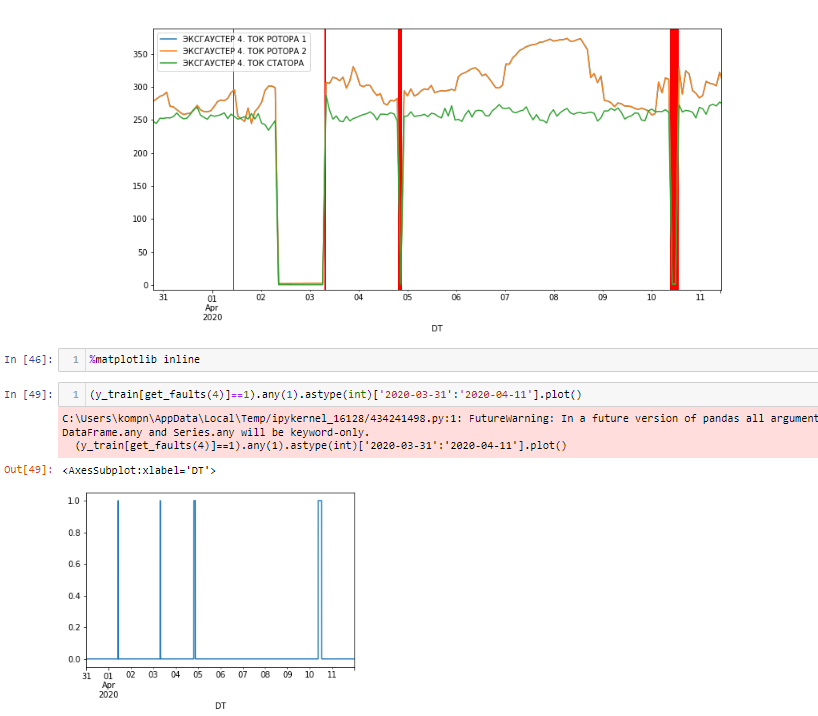

# Аналитика по распредлению неисправностей по М1


Text(0, 0.5, 'num')

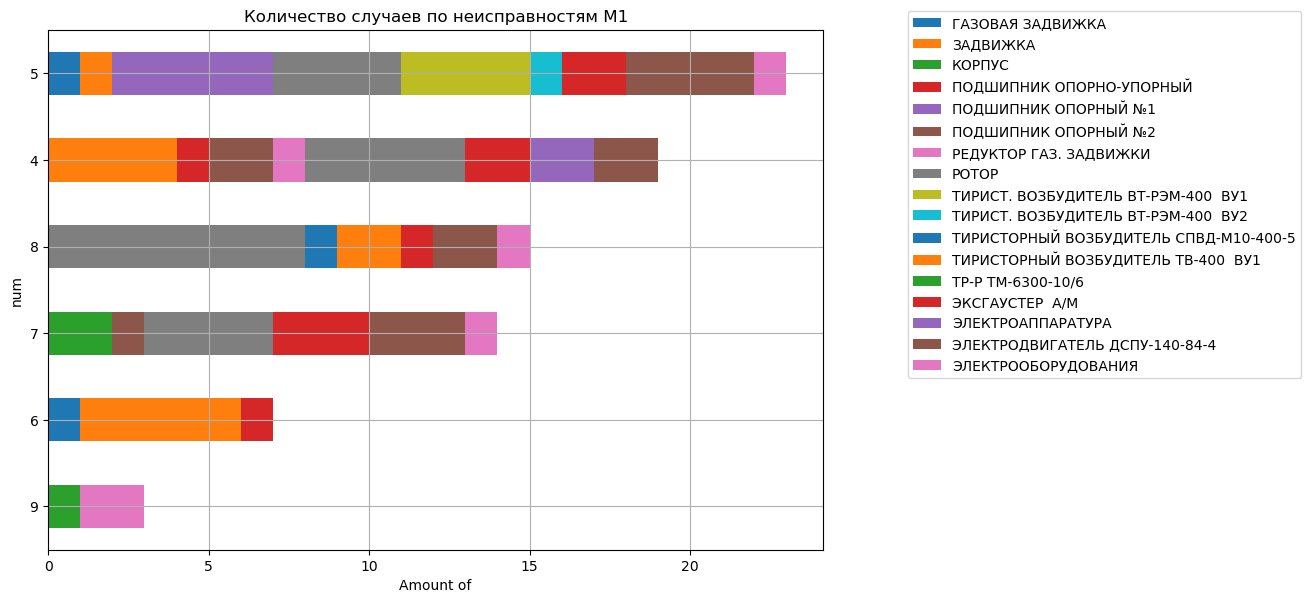

In [73]:
x = 'num'
hue = 'type'
df = toir[toir['label']==1]
pd.crosstab(df[hue],
            df[x]).T.reindex(df[x].value_counts(ascending=True).index)\
.plot.barh(figsize=(10,len(df)/12), 
                                      stacked=True);
plt.grid()
plt.title('Количество случаев по неисправностям M1')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Amount of')
plt.ylabel(x)

Text(0, 0.5, 'type')

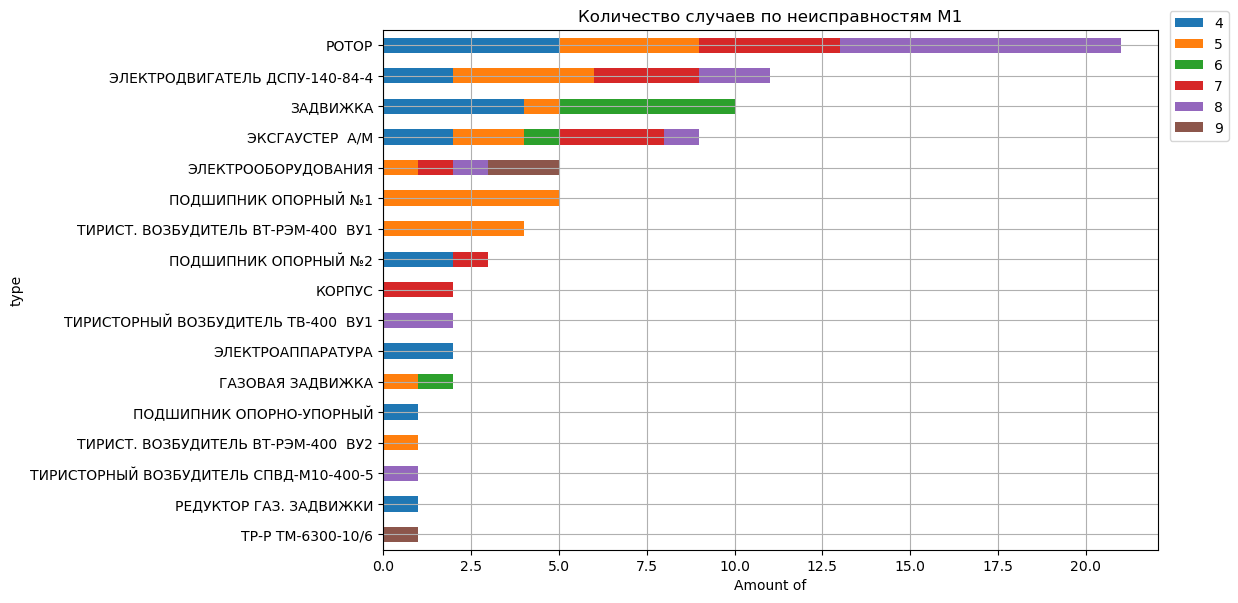

In [74]:
x = 'type'
hue = 'num'
df = toir[toir['label']==1]
pd.crosstab(df[hue],
            df[x]).T.reindex(df[x].value_counts(ascending=True).index)\
.plot.barh(figsize=(10,len(df)/12), 
                                      stacked=True);
plt.grid()
plt.title('Количество случаев по неисправностям M1')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Amount of')
plt.ylabel(x)

# Аналитика по распредлению неисправностей по М3


Text(0, 0.5, 'num')

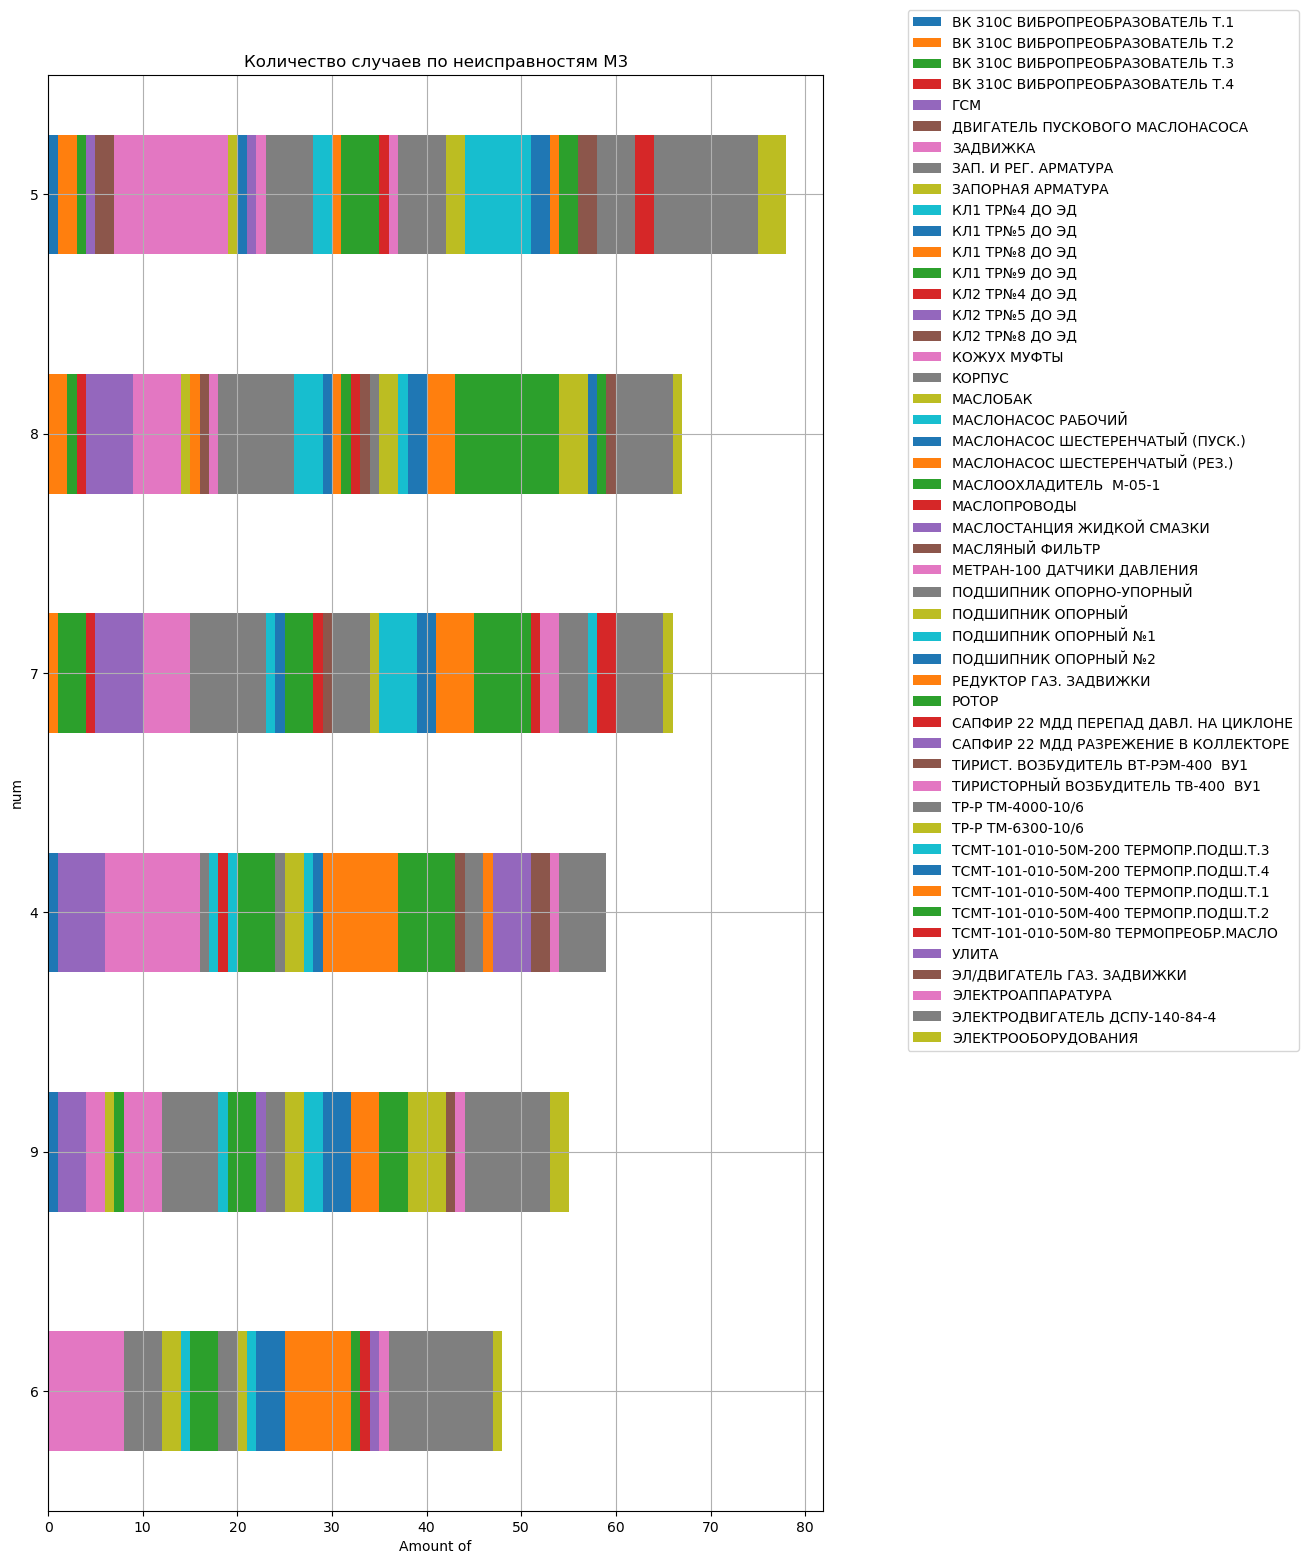

In [78]:
x = 'num'
hue = 'type'
df = toir[toir['label']==2]
pd.crosstab(df[hue],
            df[x]).T.reindex(df[x].value_counts(ascending=True).index)\
.plot.barh(figsize=(10,len(df)/20), 
                                      stacked=True);
plt.grid()
plt.title('Количество случаев по неисправностям M3')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Amount of')
plt.ylabel(x)

Text(0, 0.5, 'type')

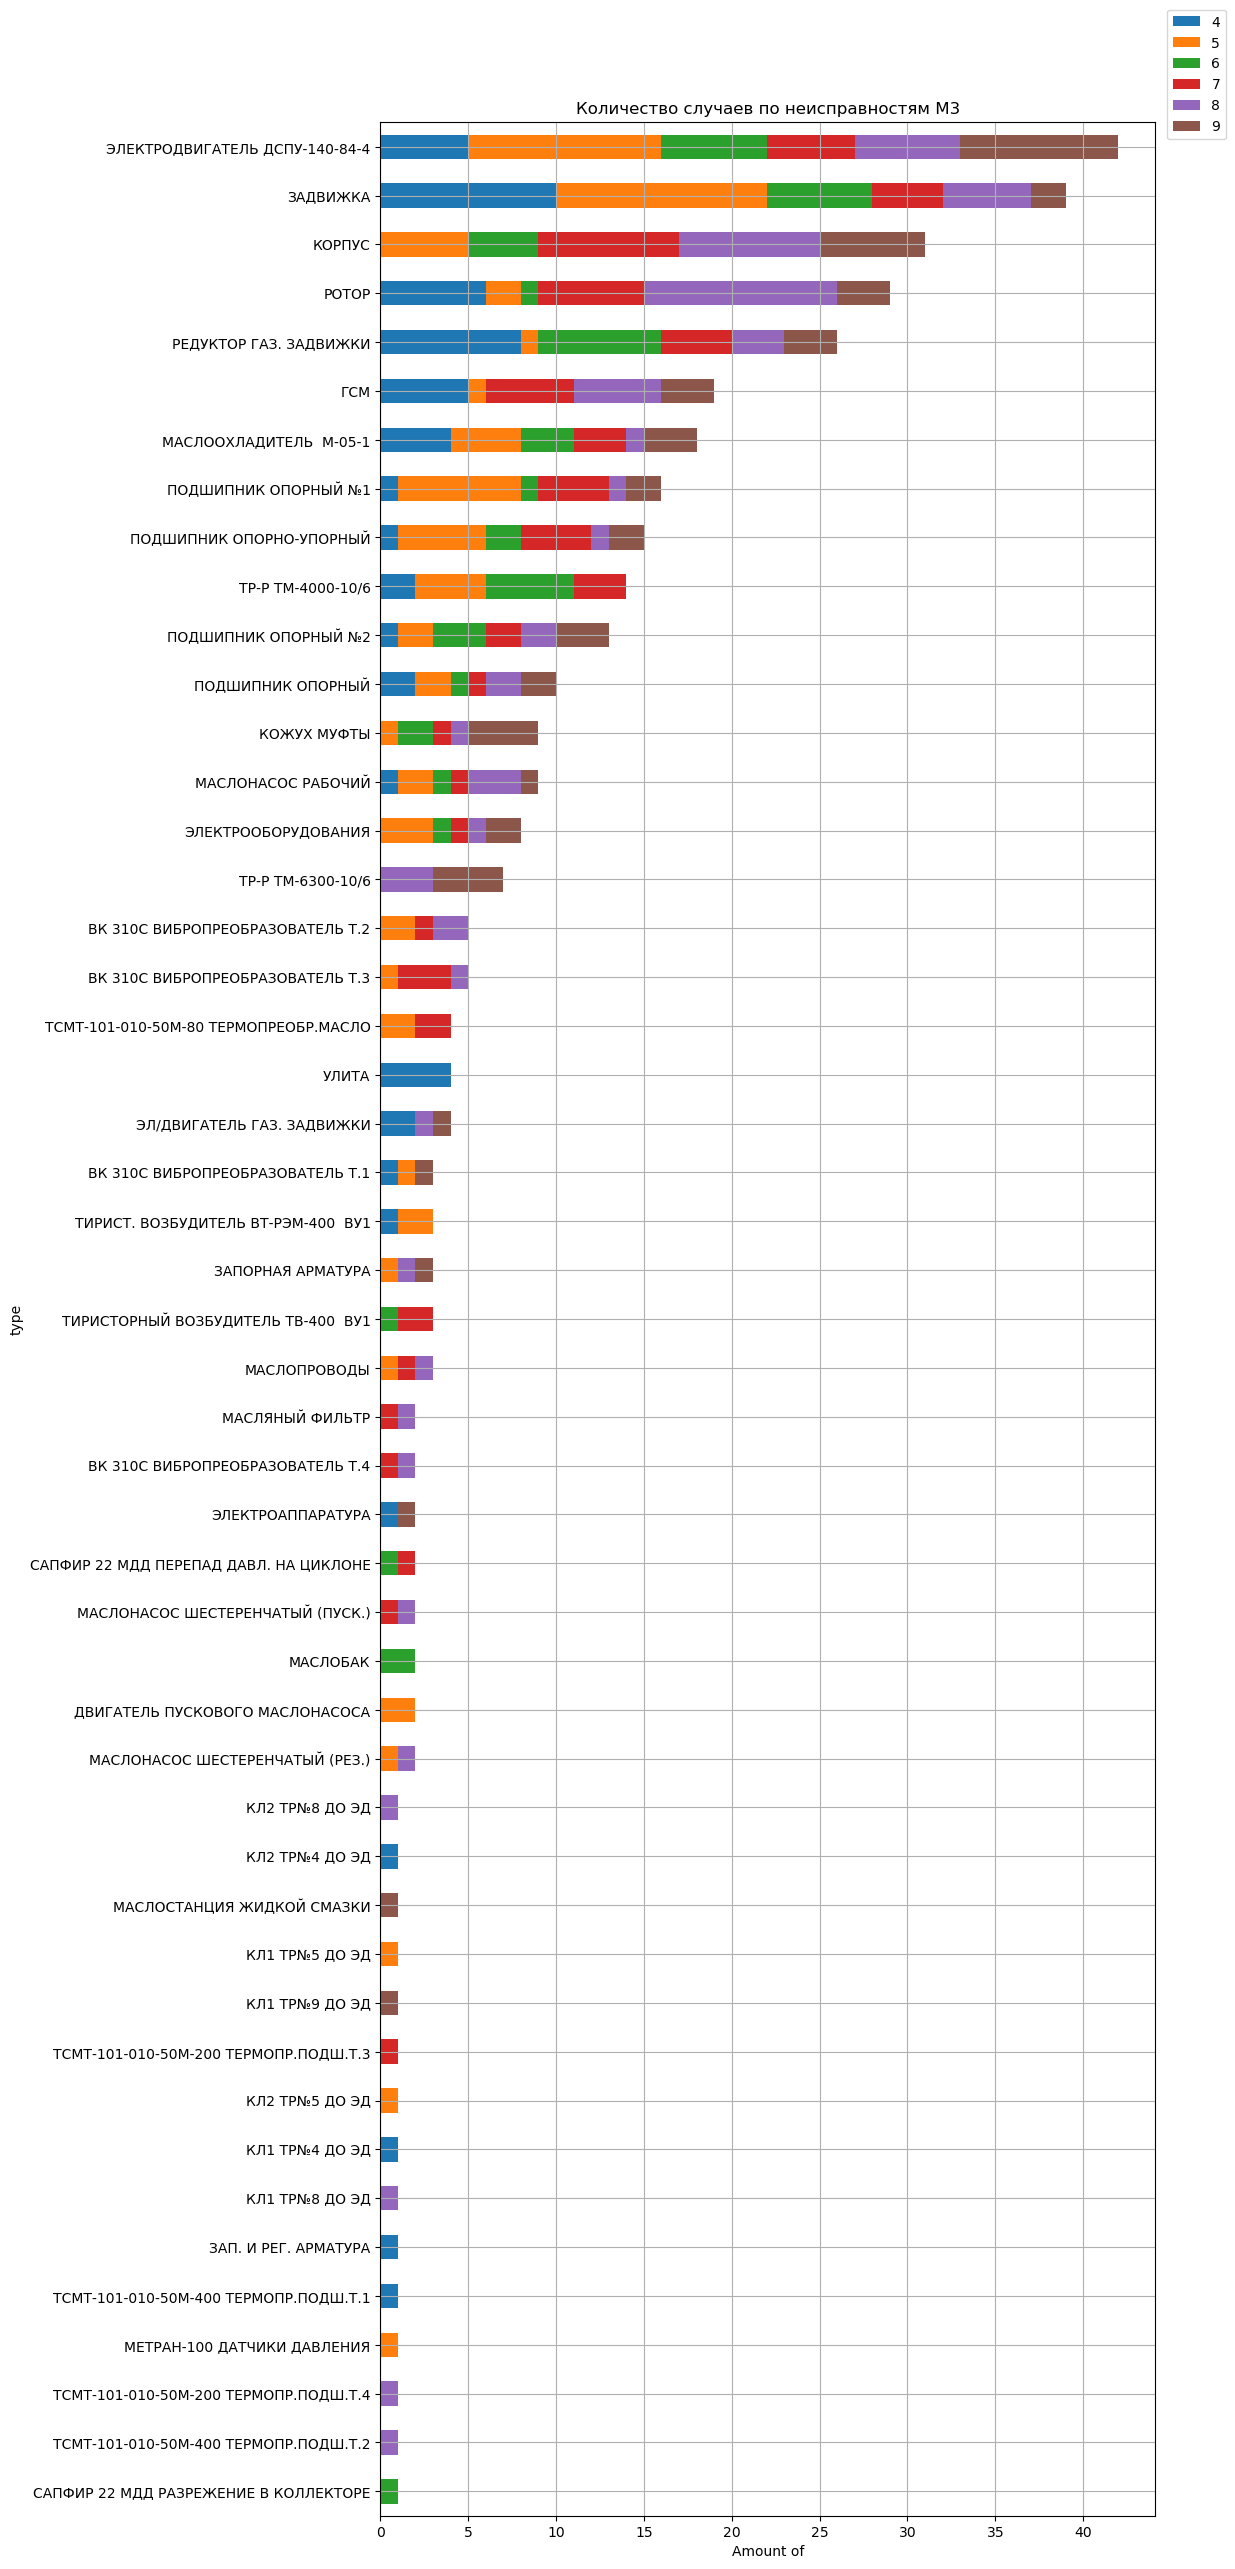

In [79]:
x = 'type'
hue = 'num'
df = toir[toir['label']==2]
pd.crosstab(df[hue],
            df[x]).T.reindex(df[x].value_counts(ascending=True).index)\
.plot.barh(figsize=(10,len(df)/12), 
                                      stacked=True);
plt.grid()
plt.title('Количество случаев по неисправностям M3')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Amount of')
plt.ylabel(x)

# Аналитика по распредлению неисправностей без  М1 это или М3

Text(0.5, 1.0, 'Количество случаев по неисправностям')

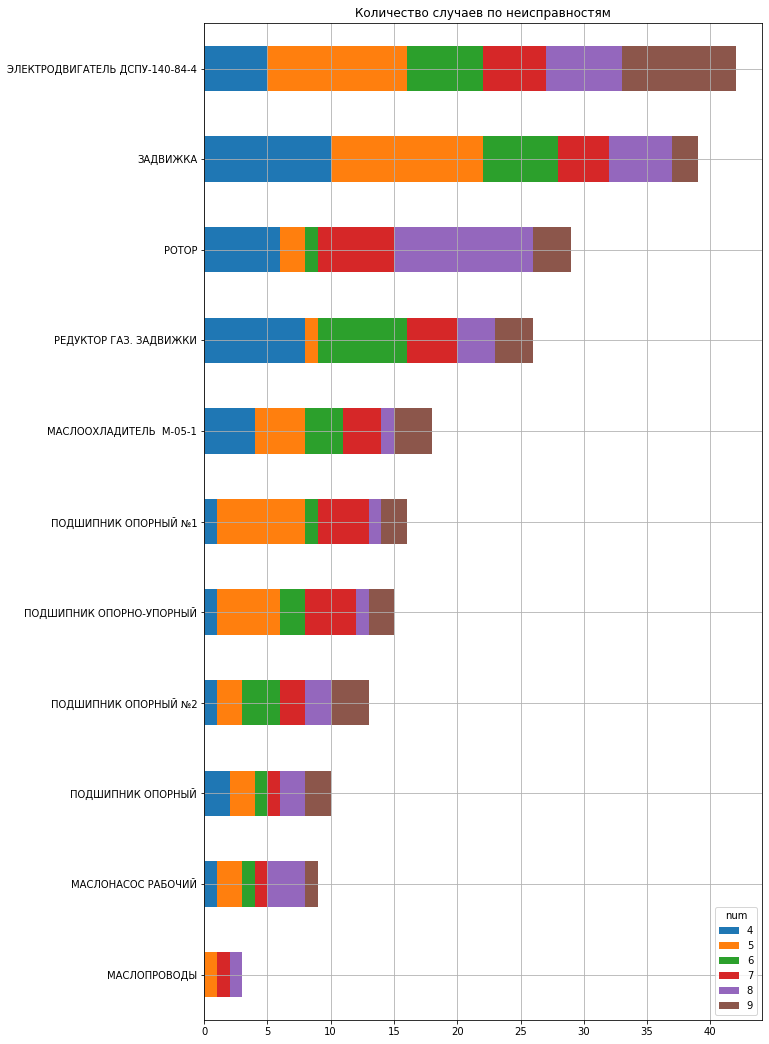

In [165]:
x = 'type'
hue = 'num'
pd.crosstab(toir[hue],
            toir[x]).T.reindex(toir[x].value_counts(ascending=True).index)\
.plot.barh(figsize=(10,len(toir)/12), 
                                      stacked=True, 
                                      title=col);
plt.grid()
plt.title('Количество случаев по неисправностям')

Text(0.5, 1.0, 'Количество случаев по неисправностям')

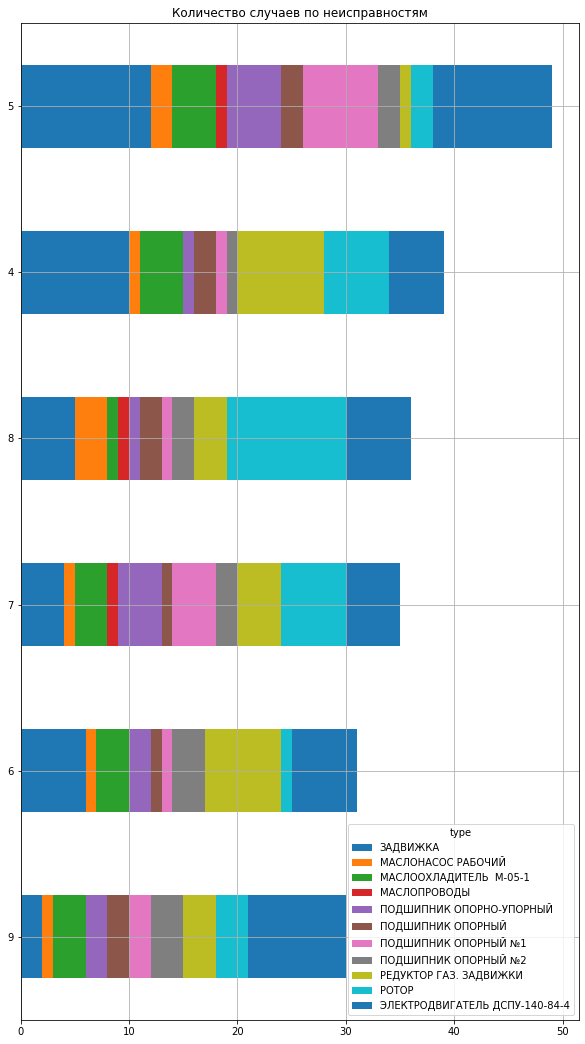

In [166]:
x = 'num'
hue = 'type'
pd.crosstab(toir[hue],
            toir[x]).T.reindex(toir[x].value_counts(ascending=True).index)\
.plot.barh(figsize=(10,len(toir)/12), 
                                      stacked=True, 
                                      title=col);
plt.grid()
plt.title('Количество случаев по неисправностям')

# Пересечения неиспраностей типа М1 по Агрегатам  

In [71]:
## for num in nums 

bandwith = pd.Timedelta('7D')
print("Оценка пересечния с учетом добавления +/-",bandwith)


pd.set_option('display.max_colwidth', None)
for num in nums:
    print(f"Для ЭКСГАУСТЕРа №{num}")
    analog_y_train = pd.DataFrame(index=y_train.index) 
    df = toir[(toir['num']==num) & (toir['label']==1)]
    for ftype in df['type'].unique():
        _df = df[df['type']==ftype]
        analog_y_train[ftype] = 0
        for idx in _df.index:
            t1 = toir['start_time'].loc[idx]
            t2 = t1 + toir['duration'].loc[idx]    
            t1 = t1 - bandwith
            t2 = t2 + bandwith
            analog_y_train[t1:t2] = 1

    df['type'].unique()

    bin_analog_y_train = (analog_y_train.sum(1) > 1).astype(int)

    sbr = split_by_repeated(bin_analog_y_train)
    if 1 in sbr:
        hist = pd.DataFrame(columns=['c', 'по', 'Какие - разделитель перенос каретки'])
        for ts in sbr[1]:
            _ts = analog_y_train.loc[ts.index].any()
            _ts = _ts[_ts]
            if len(_ts)>= 2:
                hist.loc[len(hist)] = [ts.index[0], ts.index[-1],'\n'.join(list(_ts.index))]
        display(HTML(hist.to_html().replace("\\n","<br>")))
    else:
        print("Нет перечечний")
    print()
pd.set_option('display.max_colwidth', None)


Оценка пересечния с учетом добавления +/- 7 days 00:00:00
Для ЭКСГАУСТЕРа №4


,c,по,Какие - разделитель |?vs?|
0,2019-05-11 08:27:00,2019-06-05 16:58:20,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2
1,2019-07-23 19:14:40,2019-08-06 19:20:30,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2
2,2019-10-22 12:42:00,2019-11-05 14:13:10,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2ЗАДВИЖКА
3,2020-03-25 10:19:10,2020-04-17 12:44:30,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2ЗАДВИЖКАРОТОРПОДШИПНИК ОПОРНО-УПОРНЫЙЭКСГАУСТЕР А/М
4,2020-06-08 17:18:10,2020-06-22 17:32:00,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2ЗАДВИЖКАРОТОР
5,2020-07-22 08:14:30,2020-08-05 08:29:30,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2ЗАДВИЖКАРОТОР
6,2020-09-23 06:33:50,2020-10-07 07:15:50,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2ЗАДВИЖКА
7,2020-10-19 14:07:40,2020-11-02 15:43:40,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИ
8,2020-12-20 16:44:20,2021-01-03 16:55:20,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2ЗАДВИЖКАРОТОРПОДШИПНИК ОПОРНО-УПОРНЫЙЭКСГАУСТЕР А/М
9,2021-01-12 14:18:30,2021-01-26 19:29:00,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4РЕДУКТОР ГАЗ. ЗАДВИЖКИЭЛЕКТРОАППАРАТУРАПОДШИПНИК ОПОРНЫЙ №2ЗАДВИЖКАРОТОР



Для ЭКСГАУСТЕРа №5


,c,по,Какие - разделитель |?vs?|
0,2019-04-27 09:50:20,2019-05-11 10:37:20,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКАЭЛЕКТРООБОРУДОВАНИЯ
1,2020-01-14 15:54:30,2020-01-28 16:06:20,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКАЭЛЕКТРООБОРУДОВАНИЯПОДШИПНИК ОПОРНЫЙ №1ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ВУ1ЭКСГАУСТЕР А/М
2,2020-06-12 13:07:40,2020-07-07 17:33:10,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКАЭЛЕКТРООБОРУДОВАНИЯПОДШИПНИК ОПОРНЫЙ №1ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ВУ1ЭКСГАУСТЕР А/МРОТОР
3,2020-07-19 16:45:40,2020-08-02 16:59:30,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКАЭЛЕКТРООБОРУДОВАНИЯПОДШИПНИК ОПОРНЫЙ №1ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ВУ1ЭКСГАУСТЕР А/МРОТОР
4,2020-08-08 17:06:40,2020-08-22 17:14:30,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКАЭЛЕКТРООБОРУДОВАНИЯПОДШИПНИК ОПОРНЫЙ №1ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ВУ1ЭКСГАУСТЕР А/МРОТОР
5,2021-05-18 22:09:20,2021-06-11 06:40:10,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКАЭЛЕКТРООБОРУДОВАНИЯПОДШИПНИК ОПОРНЫЙ №1ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ВУ1ЭКСГАУСТЕР А/МРОТОРГАЗОВАЯ ЗАДВИЖКА
6,2021-07-30 18:46:10,2021-08-13 19:20:00,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКА
7,2021-09-03 17:49:30,2021-09-30 15:27:00,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКАЭЛЕКТРООБОРУДОВАНИЯПОДШИПНИК ОПОРНЫЙ №1ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ВУ1
8,2021-11-12 02:58:10,2021-12-29 17:36:50,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ЗАДВИЖКАЭЛЕКТРООБОРУДОВАНИЯПОДШИПНИК ОПОРНЫЙ №1ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ВУ1ЭКСГАУСТЕР А/МРОТОРГАЗОВАЯ ЗАДВИЖКАТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ВУ2



Для ЭКСГАУСТЕРа №6


,c,по,Какие - разделитель |?vs?|
0,2020-11-25 17:10:20,2020-12-09 17:27:10,ЗАДВИЖКАГАЗОВАЯ ЗАДВИЖКА
1,2021-04-10 06:07:00,2021-04-24 06:27:50,ЗАДВИЖКАГАЗОВАЯ ЗАДВИЖКАЭКСГАУСТЕР А/М



Для ЭКСГАУСТЕРа №7


,c,по,Какие - разделитель |?vs?|
0,2019-05-23 07:58:30,2019-06-06 08:13:20,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4КОРПУСПОДШИПНИК ОПОРНЫЙ №2
1,2020-01-03 19:38:20,2020-01-17 19:44:10,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4КОРПУСПОДШИПНИК ОПОРНЫЙ №2РОТОРЭКСГАУСТЕР А/М
2,2020-10-29 17:54:30,2020-11-12 18:02:20,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4КОРПУСПОДШИПНИК ОПОРНЫЙ №2РОТОР
3,2020-11-18 13:04:00,2020-12-02 13:11:50,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4КОРПУСПОДШИПНИК ОПОРНЫЙ №2РОТОРЭКСГАУСТЕР А/МЭЛЕКТРООБОРУДОВАНИЯ
4,2020-12-10 12:31:10,2020-12-31 15:04:10,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4КОРПУСПОДШИПНИК ОПОРНЫЙ №2РОТОРЭКСГАУСТЕР А/М
5,2021-01-14 13:30:30,2021-02-03 14:21:20,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4КОРПУСПОДШИПНИК ОПОРНЫЙ №2РОТОРЭКСГАУСТЕР А/М
6,2021-03-17 22:26:30,2021-04-09 11:43:10,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4КОРПУСПОДШИПНИК ОПОРНЫЙ №2РОТОР



Для ЭКСГАУСТЕРа №8


,c,по,Какие - разделитель |?vs?|
0,2019-08-22 18:49:40,2019-09-05 19:17:30,РОТОРЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5
1,2019-10-22 10:22:00,2019-11-05 10:34:00,РОТОРЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5ЭКСГАУСТЕР А/М
2,2020-03-14 05:46:50,2020-03-28 06:30:50,РОТОРЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5ЭКСГАУСТЕР А/МТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ВУ1
3,2020-05-05 03:40:40,2020-05-19 12:20:40,РОТОРЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4
4,2020-05-23 10:25:30,2020-06-20 06:25:40,РОТОРЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5ЭКСГАУСТЕР А/МТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ВУ1ЭЛЕКТРООБОРУДОВАНИЯ



Для ЭКСГАУСТЕРа №9


,c,по,Какие - разделитель |?vs?|
0,2020-07-08 02:26:50,2020-07-22 03:39:50,ЭЛЕКТРООБОРУДОВАНИЯТР-Р ТМ-6300-10/6


# Отпечатаем 1 неиспрносит 1 аггрегат

In [35]:
num = 4

In [9]:
eks = X_train[[x for x in X_train.columns if f'ЭКСГАУСТЕР {num}. ' in x]]

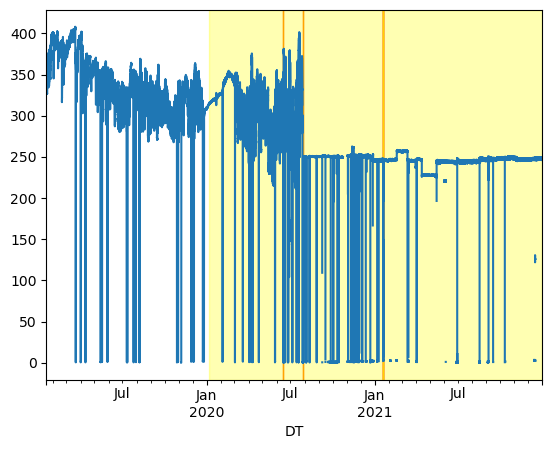

In [76]:
%matplotlib inline
eks.iloc[::10,0].plot()
notes =  toir[(toir['type']=='РОТОР') & (toir['num']==num) ]
colors = {1:'red',2:'yellow'}
alphas = {1:None,2:0.3}
for label in [1,2]:
    for idx in notes[notes['label']==label].index:
        t1 = toir['start_time'].loc[idx]
        t2 = t1 + toir['duration'].loc[idx]
        plt.axvspan(t1,t2,color=colors[label],alpha=alphas[label])



# TELE метрия

In [6]:
num=4

## Поиск комбинированных пропусков

In [8]:
df  = X_train[get_cols(4)]

In [9]:
miss = df.isna().all(1)

In [10]:
miss.sum() 

230475

In [16]:
sbr = split_by_repeated(miss)[1]
print("Количество интервалов с пропусками",len(sbr))

Количество интервалов с пропусками 13202


In [17]:
df_miss_intervals = pd.DataFrame(columns=['start','duration'])
for ts in sbr:
    df_miss_intervals.loc[len(df_miss_intervals)] = [ts.index[0],ts.index[-1]-ts.index[0]]

In [28]:
print("Распредление интервалов пропусков по телеметрии")
value_counts_interval(df_miss_intervals['duration'].values,
                     [pd.Timedelta('11s'),
                       pd.Timedelta('1h'),
                       pd.Timedelta('2h'),
                      pd.Timedelta('3h'),
                      pd.Timedelta('8h'),
                     ])

Распредление интервалов пропусков по телеметрии


до 0 days 00:00:11                      11408
c 0 days 00:00:11 до 0 days 01:00:00     1755
c 0 days 01:00:00 до 0 days 02:00:00       18
c 0 days 02:00:00 до 0 days 03:00:00        5
c 0 days 03:00:00 до 0 days 08:00:00        7
от 0 days 08:00:00                          9
dtype: int64

In [27]:
print(f'Количество неисправностей типа М1 для ЭКС№{num} равно {len(m1)}')

Количество неисправностей типа М1 для ЭКС№4 равно 19


In [22]:
m1 = toir[(toir['num']==num) & (toir['label']==1)]
m1['duration'].sum()

Timedelta('0 days 17:19:50')

In [11]:
miss.sum() * pd.Timedelta('10s')

Timedelta('26 days 16:12:30')

In [29]:
df_miss_intervals[df_miss_intervals['duration'] > pd.Timedelta('2h')]['duration'].sum()

Timedelta('21 days 13:00:40')

## Поиск единичных пропусков

In [30]:
df  = X_train[get_cols(4)]

In [37]:
miss = df.isna().all(1)
miss.sum() , miss.sum() / len(df) *100

(230475, 2.4689251265715795)

In [38]:
miss = df.isna().any(axis=1)
miss.sum(), miss.sum() / len(df) *100

(4320736, 46.28516618150507)

In [39]:
len(df)

9335034

In [42]:
print('Доли пропусков по каждому из признаков отн. len(df) в %')
df.isna().mean()*100

Доли пропусков по каждому из признаков отн. len(df) в %


ЭКСГАУСТЕР 4. ТОК РОТОРА 1                          8.914461
ЭКСГАУСТЕР 4. ТОК РОТОРА 2                          8.978703
ЭКСГАУСТЕР 4. ТОК СТАТОРА                           5.039960
ЭКСГАУСТЕР 4. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ              7.493427
ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1    31.169196
ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2    32.273112
ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3    31.813521
ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4    31.250931
ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ          31.700784
ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ       32.267231
ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 1                   8.593595
ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 2                   9.934447
ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 3                   8.741104
ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.      5.118964
ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 4                   4.490096
ЭКСГАУСТЕР 4. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.      8.959367
dtype: float64

## Поиск режима характеризуещего **режим** работы

<IPython.core.display.Javascript object>


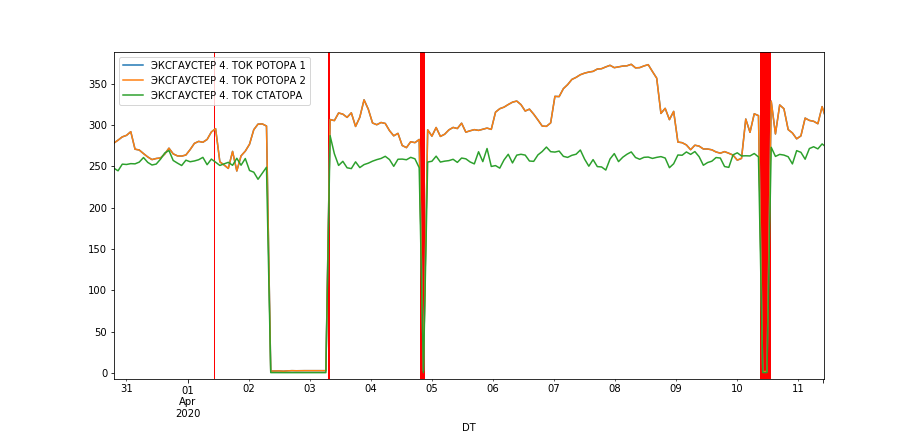

In [45]:
%matplotlib notebook
df.iloc[::10*60,:3].plot()
m1 = toir[(toir['num']==num) & (toir['label']==1)]
colors = {1:'red',2:'yellow'}
alphas = {1:None,2:0.3}
for idx in m1.index:
    t1 = toir['start_time'].loc[idx]
    t2 = t1 + toir['duration'].loc[idx]
    plt.axvspan(t1,t2,color=colors[1],alpha=alphas[1])

Думаю что

1) Ток ротора и статора меньше 100. - Это останов, его надо чистить

2) Ток ротора 1 и ток ротора 2 - одно и то же

3) есть непонтяная стабилизация по току ротора

о


## Сколько нормального режима работы (где нет ни одной неиспраности)

In [60]:
bin_y = y_train == 0  
for num in nums:
    ts = bin_y[get_faults(num)].all(axis=1)
    doly = ts.mean()*100
    print(f'Для ЭКС№{num}, нормального режима  {doly:.{5}} %' )

Для ЭКС№4, нормального режима  0.96662 %
Для ЭКС№5, нормального режима  0.47142 %
Для ЭКС№6, нормального режима  1.9809 %
Для ЭКС№7, нормального режима  1.0088 %
Для ЭКС№8, нормального режима  0.87406 %
Для ЭКС№9, нормального режима  0.41129 %


## Сколько нормального режима работы (где нет ни одной неиспраности ТИПА М1)

In [155]:
bin_y = y_train != 1  
for num in nums:
    ts = bin_y[get_faults(num)].all(axis=1)
    doly = ts.mean()*100
    print(f'Для ЭКС№{num}, нормального режима  {doly:.{5}} %' )

Для ЭКС№4, нормального режима  99.933 %
Для ЭКС№5, нормального режима  99.974 %
Для ЭКС№6, нормального режима  99.93 %
Для ЭКС№7, нормального режима  99.882 %
Для ЭКС№8, нормального режима  99.83 %
Для ЭКС№9, нормального режима  99.994 %


# [Не смотрите эти далее парни] Попытка на найти поверхность

In [ ]:
points = np.random.rand(20,3)

In [65]:
ppp = points

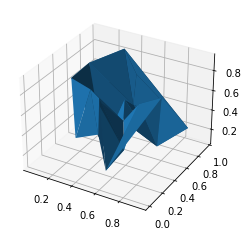

In [62]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a cloud of points


# Create Delaunay triangulation
tri = Delaunay(points)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:,0], points[:,1], points[:,2], triangles=tri.simplices)
plt.show()

In [66]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a cloud of points
points = np.random.rand(20,3)

# Create Delaunay triangulation
tri = Delaunay(points)

# Add extra connectivity between boundary vertices
boundary_points = tri.convex_hull
extra_triangles = set()
for p in boundary_points:
    simplex = tri.simplices[tri.neighbors[p,0]]
    for i in range(3):
        if simplex[i] != p:
            extra_triangles.add(tuple(sorted([p, simplex[i]])))
extra_triangles = np.array(list(extra_triangles))
triangles = np.concatenate([tri.simplices, extra_triangles])

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:,0], points[:,1], points[:,2], triangles=triangles)
plt.show()

C:\Users\kompn\AppData\Local\Temp/ipykernel_16128/1360197998.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if simplex[i] != p:


ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [67]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a cloud of points
points = np.random.rand(20,3)

# Create Delaunay triangulation
tri = Delaunay(points)

# Extract boundary vertices
hull_indices = tri.convex_hull[:, [0, 1, 2, 0]].ravel()
hull_points = tri.points[hull_indices, :]

# Find unique hull points
unique_indices = np.unique(hull_indices)
unique_hull_points = tri.points[unique_indices, :]

# Calculate the centroid of unique hull points
centroid = np.mean(unique_hull_points, axis=0)

# Create extra triangles between centroid and edge points
extra_triangles = np.zeros((len(unique_indices), 3), dtype=np.int)
for i, index in enumerate(unique_indices):
    extra_triangles[i, :] = [index, tri.npoints, (i+1)%len(unique_indices)]

# Add centroid to the points array
points = np.vstack([points, centroid])

# Add extra triangles to the triangulation
triangles = np.vstack([tri.simplices, extra_triangles])

# Plot the surface using plot_trisurf
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:,0], points[:,1], points[:,2], triangles=triangles, color='y', alpha=0.3, edgecolor='k')

C:\Users\kompn\AppData\Local\Temp/ipykernel_16128/1874617421.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  extra_triangles = np.zeros((len(unique_indices), 3), dtype=np.int)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 3

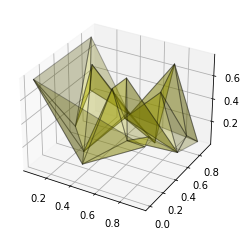

In [81]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a cloud of points
points = np.random.rand(20,3)

# Create Delaunay triangulation
tri = Delaunay(points)

# Extract boundary vertices
hull_indices = tri.convex_hull[:, [0, 1, 2, 0]].ravel()
hull_points = tri.points[hull_indices, :]

# Find unique hull points
unique_indices = np.unique(hull_indices)
unique_hull_points = tri.points[unique_indices, :]

# Calculate the centroid of unique hull points
centroid = np.mean(unique_hull_points, axis=0)

# Create extra triangles between centroid and edge points
extra_triangles = []
for i in range(len(unique_indices)):
    pt1 = unique_indices[i]
    pt2 = unique_indices[(i+1)%len(unique_indices)]
    extra_triangles.append([pt1, pt2, tri.npoints])

# Add centroid to the points array
points = np.vstack([points, centroid])

# Add extra triangles to the triangulation
# triangles = np.concatenate([tri.simplices, extra_triangles])

# Plot the surface using plot_trisurf
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(points[:,0], points[:,1], points[:,2], triangles=tri.simplices, color='y', alpha=0.3, edgecolor='k')
plt.show()

In [ ]:
hull1.in

In [84]:
dir (ConvexHull)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_points',
 '_qhull',
 '_update',
 'add_points',
 'close',
 'points',
 'vertices']

In [99]:
rng = np.random.default_rng()
points = rng.random((30, 2))

In [ ]:
scipy.spatial.ConvexHull

## Более менее норм все

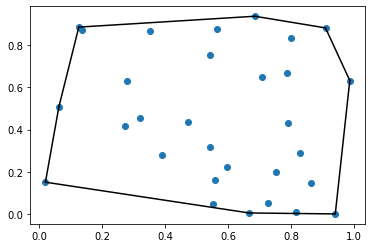

In [109]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
rng = np.random.default_rng()
points = rng.random((30, 2))   # 30 random points in 2-D
hull = ConvexHull(points)

import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [111]:
tri = Delaunay(hull.points[hull.vertices])

In [114]:
p = [0.2,  0.2]
if tri.find_simplex(p) >= 0:
   print("Point is inside Convex Hull.")
else:
   print("Point is outside Convex Hull.")

Point is inside Convex Hull.


## Прод решение

In [136]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np

points = X_train[get_cols(4)].fillna(0).values
hull = ConvexHull(points)

tri = Delaunay(hull.points[hull.vertices])

QhullError: QH6235 qhull error (qh_memalloc): negative request size (-1910222104).  Did int overflow due to high-D?

While executing:  | qhull i Qx Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1818136590  incidence  Qxact-merge  Qtriangulate  _zero-centrum
  Q3-no-merge-vertices-dim-high  _max-width 6e+03  Error-roundoff 3.2e-11
  _one-merge 1e-09  _near-inside 5.2e-09  Visible-distance 1.9e-10
  U-max-coplanar 1.9e-10  Width-outside 3.8e-10  _wide-facet 1.1e-09
  _maxoutside 1.1e-09
Last point added to hull was p6924859.  Last merge was #14245.

At error exit:

Convex hull of 9335034 points in 16-d:

  Number of vertices: 102
  Number of facets: 32597820
  Number of non-simplicial facets: 18

Statistics for:  | qhull i Qx Qt

  Number of points processed: 102
  Number of hyperplanes created: 78613472
  Number of distance tests for qhull: -1388456231
  Number of distance tests for merging: 1413146488
  Number of distance tests for checking: 0
  Number of merged facets: 14245


precision problems (corrected unless 'Q0' or an error)
     70 coplanar horizon facets for new vertices
      1 coplanar points during partitioning
     28 nearly singular or axis-parallel hyperplanes
     16 zero divisors during back substitute
     16 zero divisors during gaussian elimination


In [120]:
get_cols(2)

[]

In [118]:
X_train

,ЭКСГАУСТЕР 4. ТОК РОТОРА 1,ЭКСГАУСТЕР 4. ТОК РОТОРА 2,ЭКСГАУСТЕР 4. ТОК СТАТОРА,ЭКСГАУСТЕР 4. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,...,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 9. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 1,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 2,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4,ЭКСГАУСТЕР 9. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.
DT,,,,,,,,,,,,,,,,,,,,,
2019-01-16 13:21:00,363.676667,363.676667,244.078000,119.385000,41.370000,39.750000,39.750000,44.538548,33.260000,40.560000,...,17.040000,15.410000,6.085000,12.170000,0.040000,0.060000,0.080000,0.100000,0.060000,0.080000
2019-01-16 13:21:10,363.103333,363.103333,243.032500,119.444440,41.374596,39.752083,39.995457,44.863054,33.343074,40.401081,...,16.063092,13.790000,5.192110,12.574638,0.033854,0.065972,0.072917,0.086806,0.294271,0.093750
2019-01-16 13:21:20,363.266667,363.266667,242.940000,119.330000,41.374596,39.752083,39.932360,44.799956,33.261948,40.383053,...,16.135206,15.143644,5.680000,11.360000,0.038580,0.068480,0.069444,0.084877,0.265239,0.088735
2019-01-16 13:21:30,363.414372,363.414372,243.836802,119.398146,41.374596,39.752083,39.833208,44.781928,33.586453,40.563330,...,16.063090,14.440548,5.759994,12.574638,0.039931,0.060764,0.067708,0.092882,1.231771,0.078993
2019-01-16 13:21:40,363.103333,363.103333,242.050000,119.326667,41.536849,39.752083,39.752083,43.810000,33.505327,39.750000,...,16.230000,14.846180,4.870000,12.980000,0.035590,0.058160,0.072049,0.087674,1.410000,0.085937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:59:10,248.120000,248.120000,273.610000,134.490000,NaN,43.000000,NaN,NaN,NaN,NaN,...,35.700000,57.600000,24.340000,34.070000,1.050000,2.370000,1.250000,2.100000,NaN,3.780000
2021-12-31 23:59:20,247.710000,247.710000,272.220000,NaN,NaN,NaN,NaN,NaN,30.830000,33.260000,...,NaN,NaN,25.150000,34.880000,0.950000,2.350000,1.310000,2.460000,0.630000,2.860000
2021-12-31 23:59:30,248.120000,248.120000,274.310000,NaN,43.000000,NaN,NaN,34.880000,31.640000,NaN,...,36.510000,NaN,NaN,31.640000,0.980000,2.320000,1.140000,2.130000,NaN,2.990000


# Что то другое

In [169]:
y_train.columns

Index(['Y_ЭКСГАУСТЕР А/М №9_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №9',
       'Y_ЭКСГАУСТЕР А/М №9_МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ. №9',
       'Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №9',
       'Y_ЭКСГАУСТЕР А/М №9_КЛ1 ТР№9 ДО ЭД ЭКСГАУСТЕРА №9',
       'Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №9',
       'Y_ЭКСГАУСТЕР А/М №9_КОРПУС ЭКСГ. №9',
       'Y_ЭКСГАУСТЕР А/М №9_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №9',
       'Y_ЭКСГАУСТЕР А/М №9_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №9',
       'Y_ЭКСГАУСТЕР А/М №9_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №9',
       'Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9',
       ...
       'Y_ЭКСГАУСТЕР А/М №6_ЭКСГАУСТЕР А/М №6',
       'Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №6',
       'Y_ЭКСГАУСТЕР А/М №6_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ6 ВУ1',
       'Y_ЭКСГАУСТЕР А/М №6_ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ. №6',
       'Y_ЭКСГАУСТЕР А/М №6_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (ПУСК.) ЭКСГ.№6',
       'Y_ЭКСГАУСТЕР А/М №6_ВК 310С ВИБРОПРЕОБРАЗОВАТ

<IPython.core.display.Javascript object>


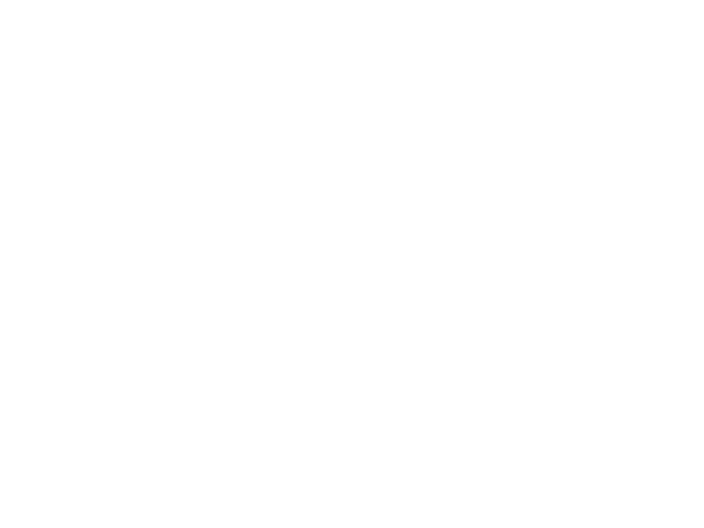

<IPython.core.display.Javascript object>


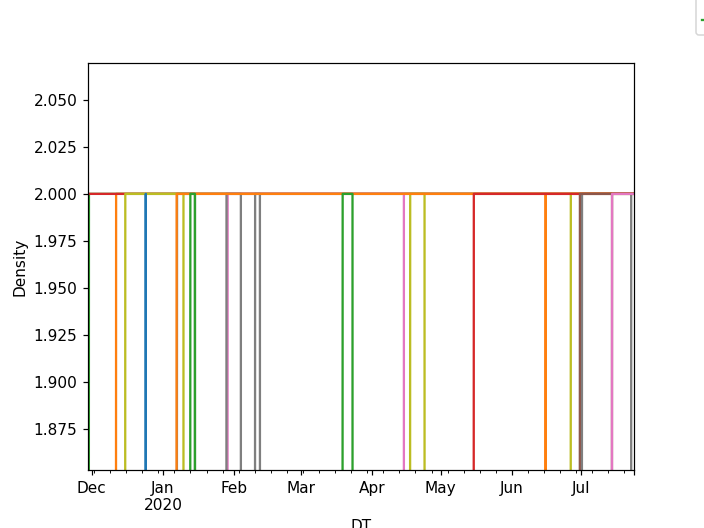

In [11]:
%matplotlib notebook
for num in nums:
    plt.figure()
    y_train[[x for x in y_train.columns if f'А/М №{num}_' in x]].resample('1h').mean().plot()
    
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    break
    


In [38]:
X_train.shape[0] - X_train.dropna().shape[0]

4579385

In [39]:
y_train.shape[0] - y_train.dropna().shape[0]

0

Введите запрос: При каком значении параметра а уравнение (х + За - 5)(х + а) = 1 имеет два корня, которые симметричны относительно числа 2?
Раскроем скобки и приведем к виду квадратного уравнения:

$x^2 + (3a-5)x + a(5-a) = 0$

Заметим, что если уравнение имеет два корня, симметричных относительно числа 2, то их среднее арифметическое равно 2:

$(x_1 + x_2)/2 = 2$

Также известно, что сумма корней равна коэффициенту при $x$ с обратным знаком:

$x_1 + x_2 = -(3a-5)$

Тогда получаем систему уравнений:

$\begin{cases} (x_1 + x_2)/2 = 2 \\ x_1 + x_2 = -(3a-5) \end{cases}$

Решая ее, получаем:

$\begin{cases} x_1 = \dfrac{4-a}{2} \\ x_2 = \dfrac{4-3a}{2} \end{cases}$

Теперь необходимо подставить эти корни в исходное уравнение и приравнять его к 1:

$(x_1 + 3a - 5)(x_1 + a) = 1$

$(x_2 + 3a - 5)(x_2 + a) = 1$

Подставим значения корней:

$\dfrac{1-a}{2} \cdot \dfrac{5-a}{2} = 1$

$\dfrac{1-3a}{2} \cdot \dfrac{3-a}{2} = 1$

Решая данные квадратные уравнения, получаем два возможных значения параметра $a$:

$a = 1$ или $a = \dfrac{7}{3}$.

Из каждого из этих значений будет получаться пара корней, симметричных относительно числа 2.
Введите запрос:

In [ ]:
One approach to solve this problem is to use a pre-trained natural language processing (NLP) model like Universal Sentence Encoder from TensorFlow. We can use this to encode the textual descriptions into vectors, and then compute the cosine similarity between the vectors to find the most similar description.

Here's some sample code to achieve this:

``` python
import tensorflow_hub as hub
import numpy as np

# Load the pre-trained Universal Sentence Encoder model
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
model = hub.load(module_url)

# Define the list of textual descriptions
descriptions = [
    "This is the first problem description",
    "Another problem description",
    "Yet another problem description",
    "One more problem to solve",
    "Final problem description"
]

# Encode the descriptions into vectors using the Universal Sentence Encoder
description_embeddings = model(descriptions)

# Define the new problem description to compare
new_description = "This is a new problem to solve"

# Encode the new description into a vector
new_description_embedding = model([new_description])

# Compute the cosine similarity between the new description and each of the existing descriptions
similarities = np.dot(description_embeddings, new_description_embedding.T)

# Get the index of the description with the highest similarity
most_similar_index = np.argmax(similarities)

# Print the most similar description
most_similar_description = descriptions[most_similar_index]
print("The most similar description is:", most_similar_description)
```

In this example, we are using the Universal Sentence Encoder Large model from TensorFlow Hub. We first load the model using `hub.load()`. We then define a list of textual descriptions to compare against, and encode these descriptions into vectors using `model()`. We also encode the new problem description into a vector using the same approach.

We then compute the cosine similarity between the new description and each of the existing descriptions using `np.dot()`, which returns a matrix of similarities. We use `np.argmax()` to find the index of the description with the highest similarity, and then print that as the most similar description.

Note that this approach requires the pre-trained model to be downloaded and stored locally. The first time you run this code, it may take some time to download the model. Subsequent runs should be faster.

# Kmeans

In [168]:
X = np.array([[0,5],
          [0,3],
          [0.1,0],
          [-0.1,-4]])
y = np.array([[0],
          [0],
          [0,],
          [0]])

In [6]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import KNeighborsClassifier

In [162]:
cl = KMeans(n_clusters=1)


In [163]:
cl.fit(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=1)

In [165]:
cl.transform([[1,0.0]])

array([[1.41421356]])

In [148]:
cl.score([[10,0.0]])

-90.5

In [150]:
dir(cl)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_algorithm',
 '_check_feature_names',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_features_out',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_center_shape',
 '_validate_data',
 '_warn_mkl_vcomp',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_feature_names_out',
 'get_params',
 'inert

In [167]:
cl = NearestNeighbors()

In [169]:
cl.fit(X,y)

NearestNeighbors()

In [172]:
dir(cl)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_algorithm_metric',
 '_check_feature_names',
 '_check_n_features',
 '_fit',
 '_fit_X',
 '_fit_method',
 '_get_param_names',
 '_get_tags',
 '_kneighbors_reduce_func',
 '_more_tags',
 '_radius_neighbors_reduce_func',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tree',
 '_validate_data',
 'algorithm',
 'effective_metric_',
 'effective_metric_params_',
 'fit',
 'get_params',
 'kneighbors',
 'kneighbors_graph',
 'leaf_size',
 'metric',
 'metric_params',
 'n_features_in_',
 'n_jobs',
 'n_neighbors',
 'n_samples_fit_',
 'p',
 'radius'

In [171]:
cl.predict_proba([1,0.0])

AttributeError: 'NearestNeighbors' object has no attribute 'predict_proba'

In [194]:
cl = KNeighborsClassifier(n_neighbors=3)

In [220]:
X = np.array([[0,5],
          [0,3],
          [0.1,0],
          [-0.1,-4],
            [0,5],
          [0,3],
          [0.1,0],
          [-0.1,-4]])
y = np.array([[0],
          [0],
          [0,],
          [0],
             [1],
          [1],
          [1,],
          [1]])

cl.fit(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [221]:
# dir(cl)

In [224]:
cl.predict_proba([[30,0.5]])

array([[0.66666667, 0.33333333]])

In [207]:
# cl.kneighbors_graph().toarray()

In [208]:
# cl.radius

In [218]:
idx = cl.kneighbors([[0,-30.0]], return_distance=True)[0]
idx

array([[26.00019231, 30.00016667, 33.        ]])

In [216]:
X[idx[0]]

array([[-0.1, -4. ],
       [ 0.1,  0. ],
       [ 0. ,  3. ]])

## Теперь нормально

In [138]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import KNeighborsClassifier

In [56]:
cl = KNeighborsClassifier(n_neighbors=10)

In [57]:
%%time
cl.fit(X_train[get_cols(6)].fillna(0),np.zeros((len(X_train),1)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


CPU times: total: 4.14 s
Wall time: 3.16 s


KNeighborsClassifier(n_neighbors=10)

In [60]:
%%time
cl.kneighbors(X_train[get_cols(6)][::1000].fillna(0), return_distance=True)[0]  

CPU times: total: 7min 39s
Wall time: 31.6 s


array([[0.00000000e+00, 1.25844719e+00, 1.31180260e+00, ...,
        1.80010067e+00, 1.87098365e+00, 1.87557464e+00],
       [1.07895932e-05, 5.68960595e-01, 5.79930122e-01, ...,
        7.00369639e-01, 7.19309224e-01, 7.46451520e-01],
       [1.86881236e-05, 6.83938239e-01, 7.03068636e-01, ...,
        7.53165410e-01, 7.88429775e-01, 8.12101851e-01],
       ...,
       [1.07895932e-05, 1.35443715e+00, 1.71251277e+00, ...,
        2.23371887e+00, 2.23376364e+00, 2.30408333e+00],
       [0.00000000e+00, 8.40059522e-01, 8.70344759e-01, ...,
        1.86483243e+00, 2.91729327e+00, 3.06701810e+00],
       [0.00000000e+00, 6.80000000e-01, 8.78464570e-01, ...,
        1.89348884e+00, 1.97506962e+00, 2.06591384e+00]])

## Еще проверочка

In [153]:
from sklearn.neighbors import KNeighborsClassifier
cl = KNeighborsClassifier(n_neighbors=3,metric='mahalanobis')
X = np.array([[0,5],
          [0,3],
          [0.1,0],
          [-0.1,-4],
            [0,5],
          [0,3],
          [0.1,0],
          [-0.1,-4]])
y = np.array([[0],
          [0],
          [0,],
          [0],
             [1],
          [1],
          [1,],
          [1]])


X = np.array([[0,5],
          [0,3],
          [0.1,0],
          [-0.1,-4]])
y = np.array([[0],
          [0],
          [1],
          [1]]).ravel()

y = np.array([['s'],
          ['s'],
          ['d'],
          ['d']]).ravel()

cl.fit(X,y)
cl.kneighbors(X,return_distance=False)  

array([[0, 1, 2],
       [1, 0, 2],
       [2, 1, 0],
       [3, 1, 0]], dtype=int64)

# Messages

In [72]:
toir2

,МАШИНА,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ОПИСАНИЕ,t1,t2,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
393,CH-AGP-AG2/003-005,CH-AGP-AG2/003-005-002-004,МАСЛООХЛАДИТЕЛЬ М-05-1 ЭКСГ. №5,менять прокладку на подачу воды в охлади,2019-01-21 16:33:00,2019-01-22 00:00:00,NaN,5,2
394,CH-AGP-AG2/003-005,CH-AGP-AG2/003-005-002-004,МАСЛООХЛАДИТЕЛЬ М-05-1 ЭКСГ. №5,менять прокладку на подачу воды в охлади,2019-01-21 16:36:01,2019-06-04 15:35:26,NaN,5,2
395,AA2/005-006,AA2/005-006-001-002,РОТОР ЭКСГ. №8,Утечка масла.,2019-01-26 00:00:00,2019-03-04 00:00:00,NaN,8,2
396,CH-AGP-AG2/009-005,CH-AGP-AG2/009-005-001-002,РОТОР ЭКСГ. №8,Утечка масла.,2019-01-26 09:44:03,2019-03-04 00:00:00,NaN,8,2
397,AA2/001-006,AA2/001-006-001-001-002,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4,износ щеток,2019-01-27 00:00:00,2019-08-20 00:00:00,NaN,4,2
...,...,...,...,...,...,...,...,...,...
2155,AA2/005-006,AA2/005-006-001-005-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №8,Концевой выключатель на открытие г.задв.,2021-12-28 09:20:00,2021-12-30 00:00:00,NaN,8,2
2156,AA2/005-006,AA2/005-006-003-002,РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №8,Смазка редуктора.,2021-12-28 09:23:00,NaT,NaN,8,2
2157,AA2/003-006,AA2/003-006-001-001,КОРПУС ЭКСГ. №6,Прососы,2021-12-28 12:23:00,NaT,NaN,6,2
2158,AA2/001-006,AA2/001-006-001-006,УЛИТА ЭКСГ. №4,Прососы,2021-12-28 12:39:00,NaT,NaN,4,2


In [43]:
toir[(toir['label']==1) & (toir['num']==9) ].shape

(3, 5)

In [44]:
toir2[(toir2['label']==1) & (toir2['num']==9) ].shape

(4, 9)

In [45]:
toir[(toir['label']==1) & (toir['num']==9) ]

,num,type,start_time,duration,label
26,9,ЭЛЕКТРООБОРУДОВАНИЯ,2019-03-19 14:00:20,0 days 00:18:50,1
27,9,ЭЛЕКТРООБОРУДОВАНИЯ,2021-12-29 16:27:10,0 days 00:05:50,1
35,9,ТР-Р ТМ-6300-10/6,2020-07-15 02:26:50,0 days 01:13:00,1


In [46]:
toir2[(toir2['label']==1) & (toir2['num']==9) ]

,МАШИНА,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ОПИСАНИЕ,ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ,ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
478,CH-AGP-AG2/011-005,CH-AGP-AG2/011-005-001-007-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9,остановка эксгаустера защита двигателя,2019-03-19 14:00:16,2019-03-19 14:19:19,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,9,1
479,AA2/006-006,AA2/006-006-001-005-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9,остановка эксгаустера защита двигателя,2019-03-19 14:19:19,2019-03-19 14:19:19,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,9,1
1172,AA2/006-006,AA2/006-006-001-007,ТР-Р ТМ-6300-10/6 ЭКСГ. №9,остановка эк-ра №9 (газ. защита тр-ра),2020-07-15 02:26:42,2020-07-15 03:39:52,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,9,1
2159,AA2/006-006,AA2/006-006-001-005-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9,остановка эксг. №9 (2РУ МТЗ),2021-12-29 16:27:02,2021-12-29 16:33:03,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,9,1


In [54]:
pd.Timedelta

pandas._libs.tslibs.timedeltas.Timedelta

In [49]:
toir2[(toir2['label']==1)]['ТЕКСТ_ГРУППЫ_КОДОВ'].value_counts()

ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ        69
ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ           8
ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ     3
ВНЕШНИЕ ОРГАНИЗАЦИИ            2
ТЕХНОЛОГИЧЕСКИЕ ПЛАНОВЫЕ       1
Name: ТЕКСТ_ГРУППЫ_КОДОВ, dtype: int64

In [53]:
toir2[(toir2['label']==1) & (toir2['ТЕКСТ_ГРУППЫ_КОДОВ']!='ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ')].iloc[4:,3:]

,ОПИСАНИЕ,ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ,ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
859,остановка эксгаустера №5 (посадка напр),2020-01-21 15:54:25,2020-01-21 16:06:26,ВНЕШНИЕ ОРГАНИЗАЦИИ,5,1
969,ТО,2020-04-10 09:05:10,2020-04-10 12:44:37,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,4,1
1341,ТО(замена редуктора газовой задвижки №4),2020-10-26 14:07:34,2020-10-26 15:43:46,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,4,1
1389,выпуск аглопыли из газового коллектора,2020-12-02 17:10:12,2020-12-02 17:27:14,ТЕХНОЛОГИЧЕСКИЕ ПЛАНОВЫЕ,6,1
1418,ТО согласованное,2020-12-24 09:44:34,2020-12-24 15:04:16,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,7,1
1421,остановка эксг-ра №4 (защита 2РУ МТЗ),2020-12-27 16:44:19,2020-12-27 16:55:20,ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
1484,ТО,2021-01-27 08:17:41,2021-01-27 14:21:27,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,7,1
1670,Согласованное ТО,2021-04-17 06:06:56,2021-04-17 06:27:58,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,6,1
1763,ТО(согласованное),2021-05-25 22:09:18,2021-05-25 22:24:20,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,5,1
1765,ТО согласованное,2021-05-26 15:42:32,2021-05-26 17:02:43,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,5,1


# Преобразование журнала ТОиР

In [74]:
m1 = toir[toir['label']==1]

In [86]:
df.loc[t,'t2']

Timestamp('2019-03-19 14:19:19')

,МАШИНА,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ОПИСАНИЕ,t1,t2,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
478,CH-AGP-AG2/011-005,CH-AGP-AG2/011-005-001-007-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9,остановка эксгаустера защита двигателя,2019-03-19 14:00:16,2019-03-19 14:19:19,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,9,1
479,AA2/006-006,AA2/006-006-001-005-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9,остановка эксгаустера защита двигателя,2019-03-19 14:19:19,2019-03-19 14:19:19,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,9,1
1172,AA2/006-006,AA2/006-006-001-007,ТР-Р ТМ-6300-10/6 ЭКСГ. №9,остановка эк-ра №9 (газ. защита тр-ра),2020-07-15 02:26:42,2020-07-15 03:39:52,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,9,1
2159,AA2/006-006,AA2/006-006-001-005-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9,остановка эксг. №9 (2РУ МТЗ),2021-12-29 16:27:02,2021-12-29 16:33:03,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,9,1


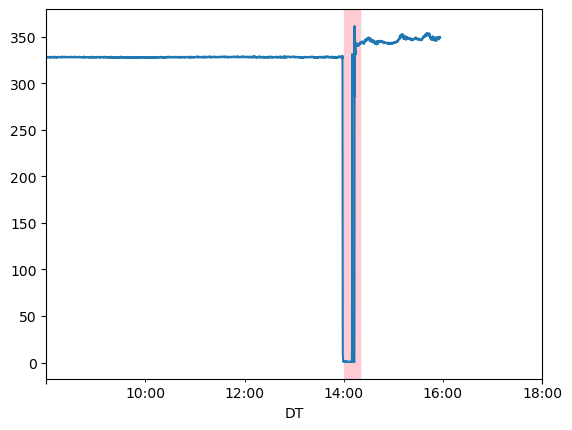

index                                                    478
МАШИНА                                    CH-AGP-AG2/011-005
ТЕХ_МЕСТО                     CH-AGP-AG2/011-005-001-007-001
НАЗВАНИЕ_ТЕХ_МЕСТА        ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9
ОПИСАНИЕ              остановка эксгаустера защита двигателя
t2                                       2019-03-19 14:19:19
ТЕКСТ_ГРУППЫ_КОДОВ                    ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                        9
label                                                      1
Name: 2019-03-19 14:00:16, dtype: object

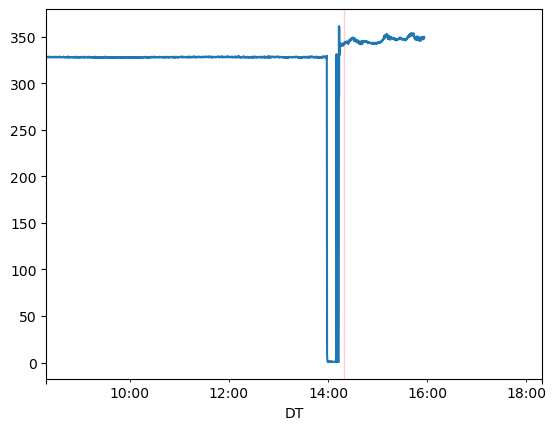

index                                                    479
МАШИНА                                           AA2/006-006
ТЕХ_МЕСТО                            AA2/006-006-001-005-001
НАЗВАНИЕ_ТЕХ_МЕСТА        ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9
ОПИСАНИЕ              остановка эксгаустера защита двигателя
t2                                       2019-03-19 14:19:19
ТЕКСТ_ГРУППЫ_КОДОВ                    ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                        9
label                                                      1
Name: 2019-03-19 14:19:19, dtype: object

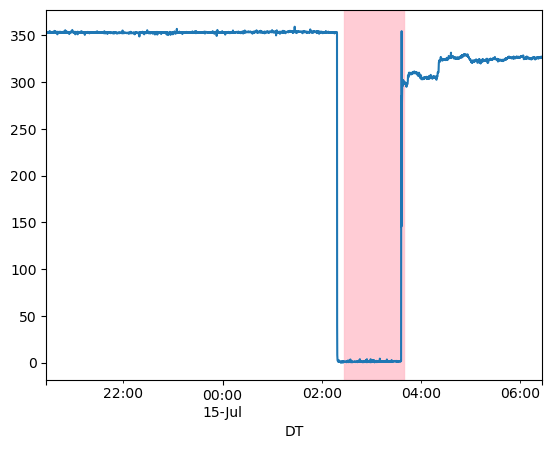

index                                                   1172
МАШИНА                                           AA2/006-006
ТЕХ_МЕСТО                                AA2/006-006-001-007
НАЗВАНИЕ_ТЕХ_МЕСТА                ТР-Р ТМ-6300-10/6 ЭКСГ. №9
ОПИСАНИЕ              остановка эк-ра №9 (газ. защита тр-ра)
t2                                       2020-07-15 03:39:52
ТЕКСТ_ГРУППЫ_КОДОВ                    ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                        9
label                                                      1
Name: 2020-07-15 02:26:42, dtype: object

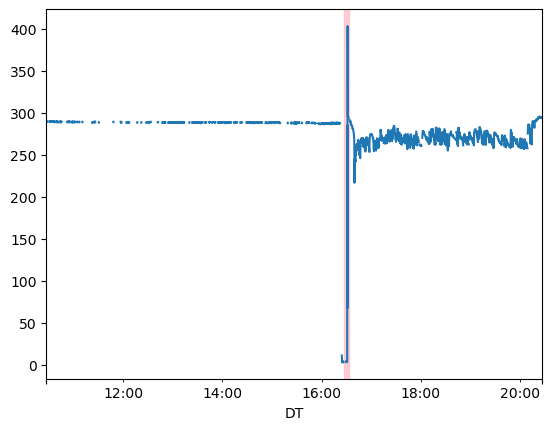

index                                               2159
МАШИНА                                       AA2/006-006
ТЕХ_МЕСТО                        AA2/006-006-001-005-001
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9
ОПИСАНИЕ                    остановка эксг. №9 (2РУ МТЗ)
t2                                   2021-12-29 16:33:03
ТЕКСТ_ГРУППЫ_КОДОВ                ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                    9
label                                                  1
Name: 2021-12-29 16:27:02, dtype: object

,МАШИНА,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ОПИСАНИЕ,t1,t2,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
518,CH-AGP-AG2/003-005,CH-AGP-AG2/003-005-001-005-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5,ТО (замена щеток на эл/двиг. эксг-ра),2019-04-23 15:34:22,2019-04-23 16:05:28,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,5,1
550,AA2/002-006,AA2/002-006-001-006-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №5,не запускался эксгаустер по эл/ч,2019-05-04 09:50:13,2019-05-04 10:37:22,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,5,1
859,CH-AGP-AG2/003-005,CH-AGP-AG2/003-005,ЭКСГАУСТЕР А/М №5,остановка эксгаустера №5 (посадка напр),2020-01-21 15:54:25,2020-01-21 16:06:26,ВНЕШНИЕ ОРГАНИЗАЦИИ,5,1
1092,AA2/002-006,AA2/002-006-001-002,РОТОР ЭКСГ. №5,остановка эк-ра №5 (вибрация в т.1),2020-06-19 13:07:39,2020-06-19 13:17:40,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,5,1
1143,AA2/002-006,AA2/002-006-001-002,РОТОР ЭКСГ. №5,остановка эк-ра №5 (вибрация в т.1),2020-06-30 17:22:17,2020-06-30 17:33:18,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,5,1
1186,AA2/002-006,AA2/002-006-001-002,РОТОР ЭКСГ. №5,остановка эк-ра №5 (вибрация в т.1),2020-07-26 16:45:35,2020-07-26 16:59:37,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,5,1
1208,AA2/002-006,AA2/002-006-001-002,РОТОР ЭКСГ. №5,остановка эк-ра №5 (вибрация в т.1),2020-08-15 17:06:38,2020-08-15 17:14:39,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,5,1
1246,CH-AGP-AG2/003-005,CH-AGP-AG2/003-005-001-005-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5,остановка эк-ра №5 (температура в т.2),2020-09-02 15:04:19,2020-09-02 15:23:21,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,5,1
1253,CH-AGP-AG2/003-005,CH-AGP-AG2/003-005-001-005-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5,остановка эк-ра №5 (температура в т.2),2020-09-05 03:29:50,2020-09-05 03:45:53,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,5,1
1290,CH-AGP-AG2/003-005,CH-AGP-AG2/003-005-001-005-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5,остановка эк-ра №5 (температура в т.2),2020-09-27 16:42:02,2020-09-27 16:50:03,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,5,1


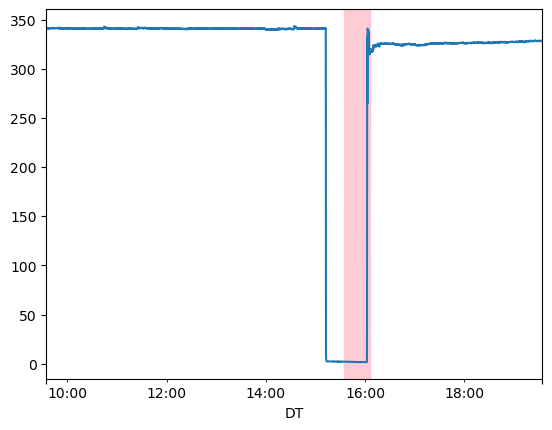

index                                                     518
МАШИНА                                     CH-AGP-AG2/003-005
ТЕХ_МЕСТО                      CH-AGP-AG2/003-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5
ОПИСАНИЕ                ТО (замена щеток на эл/двиг. эксг-ра)
t2                                        2019-04-23 16:05:28
ТЕКСТ_ГРУППЫ_КОДОВ                       ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ
num                                                         5
label                                                       1
Name: 2019-04-23 15:34:22, dtype: object

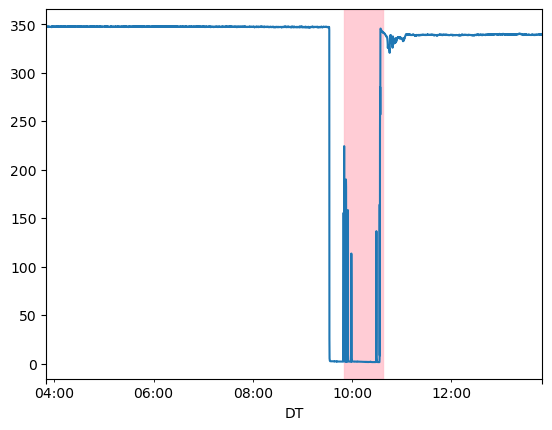

index                                                550
МАШИНА                                       AA2/002-006
ТЕХ_МЕСТО                        AA2/002-006-001-006-001
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №5
ОПИСАНИЕ                не запускался эксгаустер по эл/ч
t2                                   2019-05-04 10:37:22
ТЕКСТ_ГРУППЫ_КОДОВ                ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                    5
label                                                  1
Name: 2019-05-04 09:50:13, dtype: object

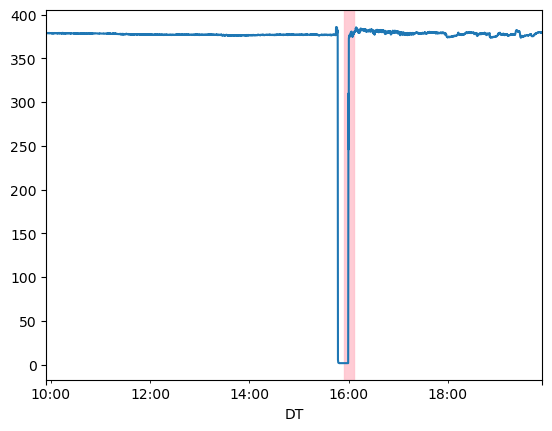

index                                                     859
МАШИНА                                     CH-AGP-AG2/003-005
ТЕХ_МЕСТО                                  CH-AGP-AG2/003-005
НАЗВАНИЕ_ТЕХ_МЕСТА                          ЭКСГАУСТЕР А/М №5
ОПИСАНИЕ              остановка эксгаустера №5 (посадка напр)
t2                                        2020-01-21 16:06:26
ТЕКСТ_ГРУППЫ_КОДОВ                        ВНЕШНИЕ ОРГАНИЗАЦИИ
num                                                         5
label                                                       1
Name: 2020-01-21 15:54:25, dtype: object

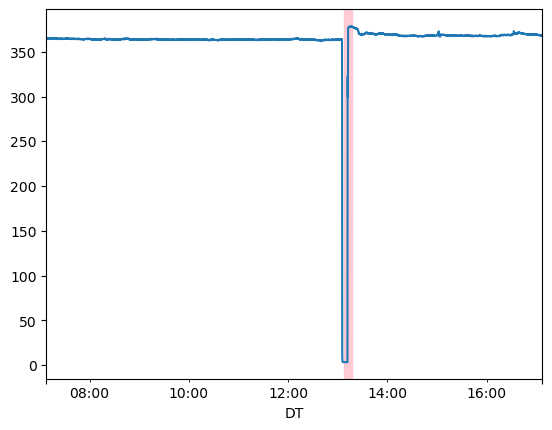

index                                                1092
МАШИНА                                        AA2/002-006
ТЕХ_МЕСТО                             AA2/002-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №5
ОПИСАНИЕ              остановка эк-ра №5 (вибрация в т.1)
t2                                    2020-06-19 13:17:40
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     5
label                                                   1
Name: 2020-06-19 13:07:39, dtype: object

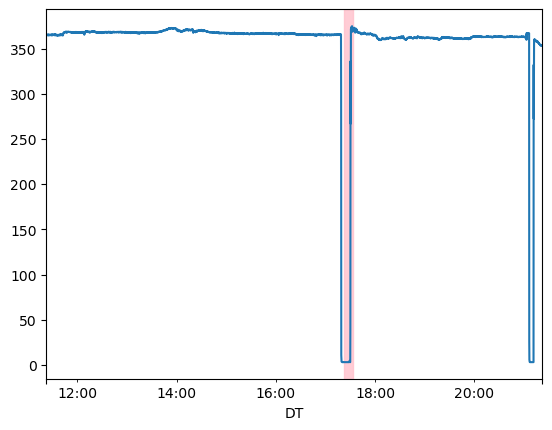

index                                                1143
МАШИНА                                        AA2/002-006
ТЕХ_МЕСТО                             AA2/002-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №5
ОПИСАНИЕ              остановка эк-ра №5 (вибрация в т.1)
t2                                    2020-06-30 17:33:18
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     5
label                                                   1
Name: 2020-06-30 17:22:17, dtype: object

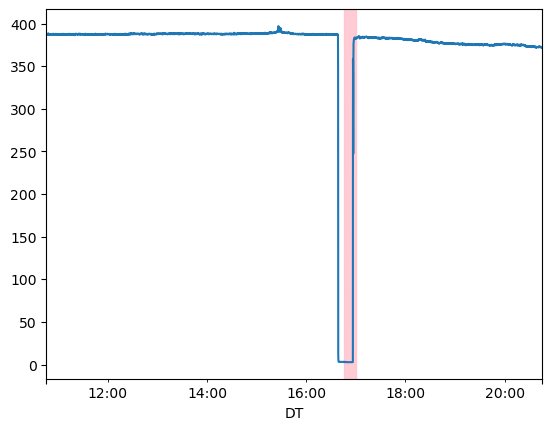

index                                                1186
МАШИНА                                        AA2/002-006
ТЕХ_МЕСТО                             AA2/002-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №5
ОПИСАНИЕ              остановка эк-ра №5 (вибрация в т.1)
t2                                    2020-07-26 16:59:37
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     5
label                                                   1
Name: 2020-07-26 16:45:35, dtype: object

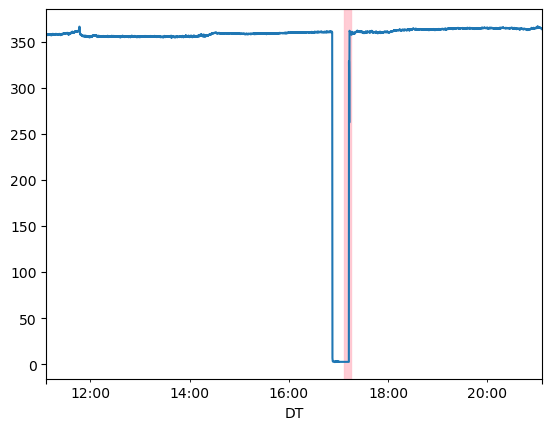

index                                                1208
МАШИНА                                        AA2/002-006
ТЕХ_МЕСТО                             AA2/002-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №5
ОПИСАНИЕ              остановка эк-ра №5 (вибрация в т.1)
t2                                    2020-08-15 17:14:39
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     5
label                                                   1
Name: 2020-08-15 17:06:38, dtype: object

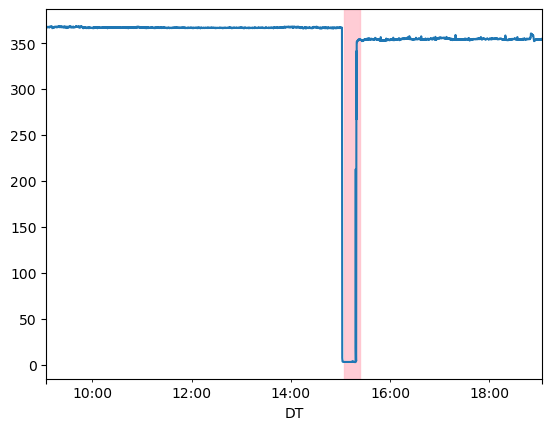

index                                                    1246
МАШИНА                                     CH-AGP-AG2/003-005
ТЕХ_МЕСТО                      CH-AGP-AG2/003-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5
ОПИСАНИЕ               остановка эк-ра №5 (температура в т.2)
t2                                        2020-09-02 15:23:21
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         5
label                                                       1
Name: 2020-09-02 15:04:19, dtype: object

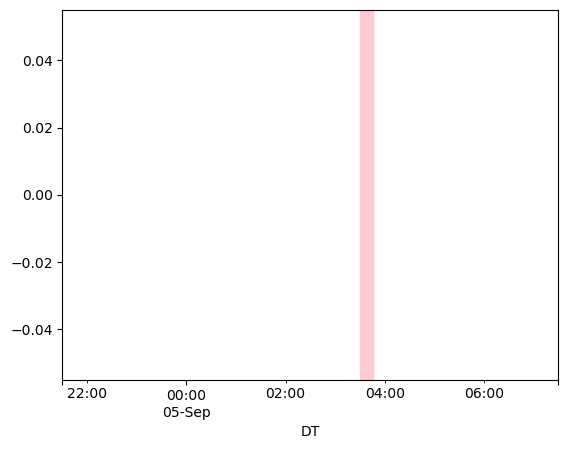

index                                                    1253
МАШИНА                                     CH-AGP-AG2/003-005
ТЕХ_МЕСТО                      CH-AGP-AG2/003-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5
ОПИСАНИЕ               остановка эк-ра №5 (температура в т.2)
t2                                        2020-09-05 03:45:53
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         5
label                                                       1
Name: 2020-09-05 03:29:50, dtype: object

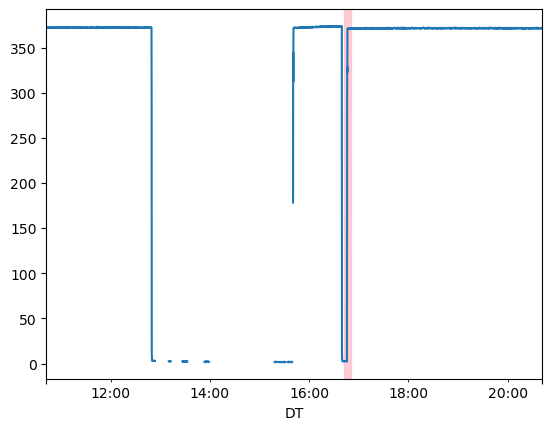

index                                                    1290
МАШИНА                                     CH-AGP-AG2/003-005
ТЕХ_МЕСТО                      CH-AGP-AG2/003-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5
ОПИСАНИЕ               остановка эк-ра №5 (температура в т.2)
t2                                        2020-09-27 16:50:03
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         5
label                                                       1
Name: 2020-09-27 16:42:02, dtype: object

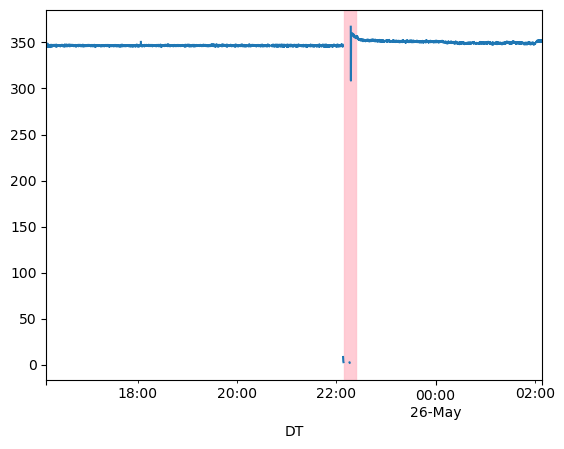

index                                 1763
МАШИНА                         AA2/002-006
ТЕХ_МЕСТО                      AA2/002-006
НАЗВАНИЕ_ТЕХ_МЕСТА       ЭКСГАУСТЕР А/М №5
ОПИСАНИЕ                 ТО(согласованное)
t2                     2021-05-25 22:24:20
ТЕКСТ_ГРУППЫ_КОДОВ    ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ
num                                      5
label                                    1
Name: 2021-05-25 22:09:18, dtype: object

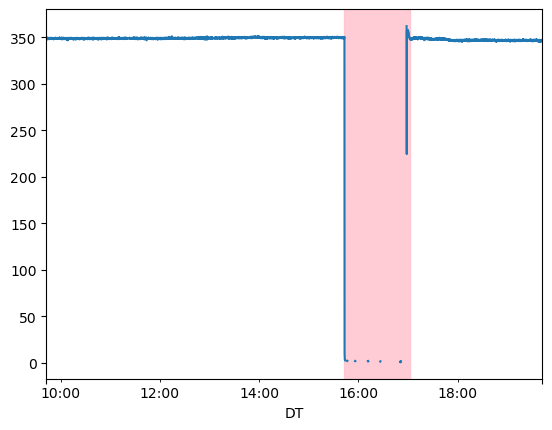

index                                                1765
МАШИНА                                 CH-AGP-AG2/003-005
ТЕХ_МЕСТО                          CH-AGP-AG2/003-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №5
ОПИСАНИЕ                                 ТО согласованное
t2                                    2021-05-26 17:02:43
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ
num                                                     5
label                                                   1
Name: 2021-05-26 15:42:32, dtype: object

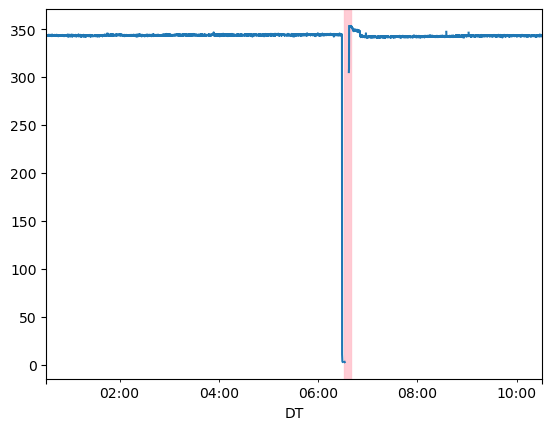

index                                                   1793
МАШИНА                                           AA2/002-006
ТЕХ_МЕСТО                            AA2/002-006-001-005-001
НАЗВАНИЕ_ТЕХ_МЕСТА                      ПОДШИПНИК ОПОРНЫЙ №1
ОПИСАНИЕ              остановка эк-ра №5 (температура в т.1)
t2                                       2021-06-04 06:40:12
ТЕКСТ_ГРУППЫ_КОДОВ                    ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                        5
label                                                      1
Name: 2021-06-04 06:31:11, dtype: object

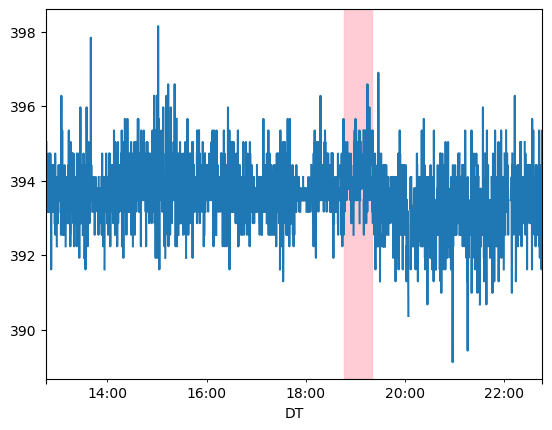

index                                               1922
МАШИНА                                       AA2/002-006
ТЕХ_МЕСТО                            AA2/002-006-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                     ЗАДВИЖКА ЭКСГ. №5
ОПИСАНИЕ              остановка эк-ра №5 (газ. задвижка)
t2                                   2021-08-06 19:20:09
ТЕКСТ_ГРУППЫ_КОДОВ                ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                    5
label                                                  1
Name: 2021-08-06 18:46:05, dtype: object

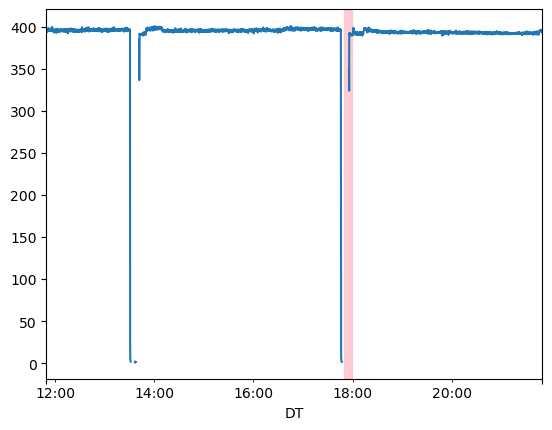

index                                                     1994
МАШИНА                                      CH-AGP-AG2/003-005
ТЕХ_МЕСТО                           CH-AGP-AG2/003-005-001-010
НАЗВАНИЕ_ТЕХ_МЕСТА    ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ1
ОПИСАНИЕ                          остановка эк-ра №5 (2РУ МТЗ)
t2                                         2021-09-10 17:59:28
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          5
label                                                        1
Name: 2021-09-10 17:49:27, dtype: object

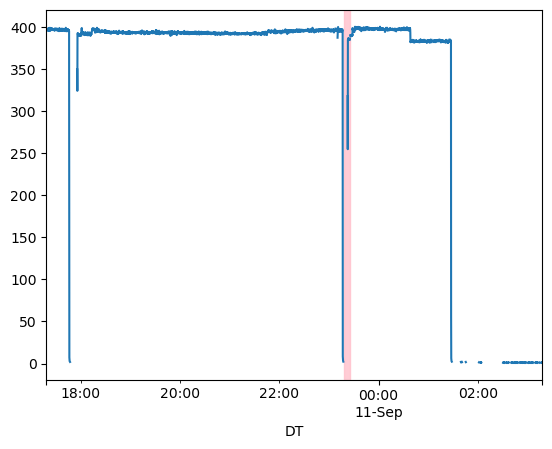

index                                                     1996
МАШИНА                                             AA2/002-006
ТЕХ_МЕСТО                                  AA2/002-006-001-009
НАЗВАНИЕ_ТЕХ_МЕСТА    ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ1
ОПИСАНИЕ                          остановка эк-ра №5 (2РУ МТЗ)
t2                                         2021-09-10 23:25:09
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          5
label                                                        1
Name: 2021-09-10 23:18:08, dtype: object

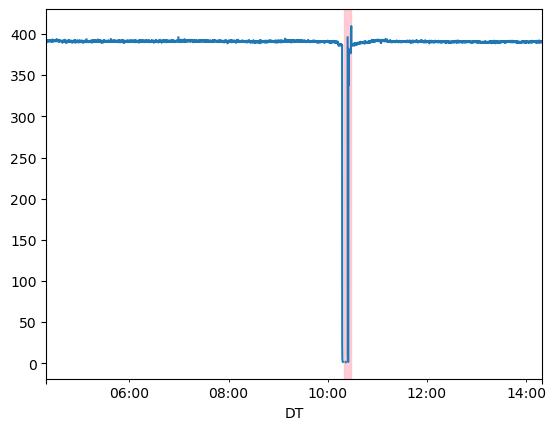

index                                                     2016
МАШИНА                                      CH-AGP-AG2/003-005
ТЕХ_МЕСТО                           CH-AGP-AG2/003-005-001-010
НАЗВАНИЕ_ТЕХ_МЕСТА    ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ1
ОПИСАНИЕ                          остановка эк-ра №5 (2РУ МТЗ)
t2                                         2021-09-16 10:27:39
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          5
label                                                        1
Name: 2021-09-16 10:19:38, dtype: object

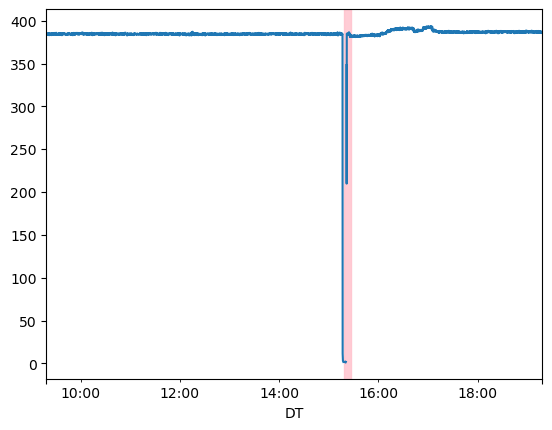

index                                                     2022
МАШИНА                                      CH-AGP-AG2/003-005
ТЕХ_МЕСТО                           CH-AGP-AG2/003-005-001-010
НАЗВАНИЕ_ТЕХ_МЕСТА    ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ1
ОПИСАНИЕ                          остановка эк-ра №5 (2РУ МТЗ)
t2                                         2021-09-23 15:27:00
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          5
label                                                        1
Name: 2021-09-23 15:18:26, dtype: object

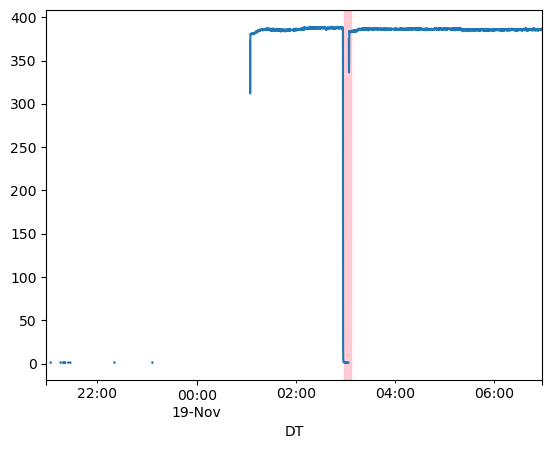

index                                                 2108
МАШИНА                                         AA2/002-006
ТЕХ_МЕСТО                          AA2/002-006-001-005-001
НАЗВАНИЕ_ТЕХ_МЕСТА                    ПОДШИПНИК ОПОРНЫЙ №1
ОПИСАНИЕ              остановка эксг. №5 (температура т.1)
t2                                     2021-11-19 03:06:04
ТЕКСТ_ГРУППЫ_КОДОВ                  ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                      5
label                                                    1
Name: 2021-11-19 02:58:03, dtype: object

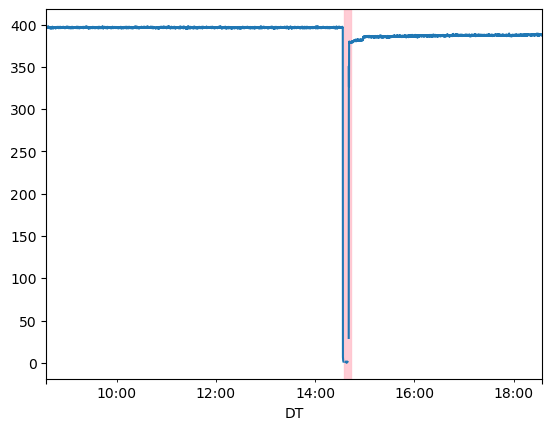

index                                                 2126
МАШИНА                                         AA2/002-006
ТЕХ_МЕСТО                          AA2/002-006-001-005-001
НАЗВАНИЕ_ТЕХ_МЕСТА                    ПОДШИПНИК ОПОРНЫЙ №1
ОПИСАНИЕ              остановка эксг. №5 (температура т.1)
t2                                     2021-11-30 14:42:50
ТЕКСТ_ГРУППЫ_КОДОВ                  ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                      5
label                                                    1
Name: 2021-11-30 14:34:49, dtype: object

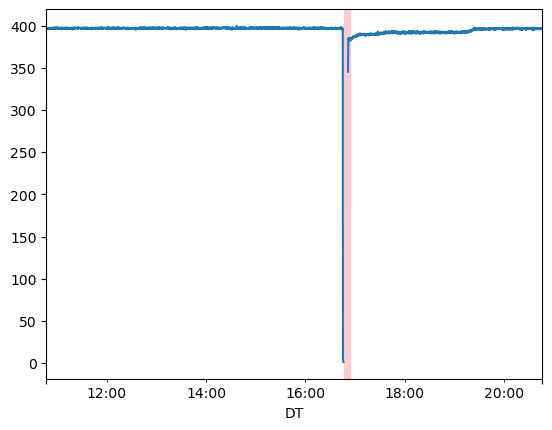

index                                                 2133
МАШИНА                                         AA2/002-006
ТЕХ_МЕСТО                          AA2/002-006-001-005-001
НАЗВАНИЕ_ТЕХ_МЕСТА                    ПОДШИПНИК ОПОРНЫЙ №1
ОПИСАНИЕ              остановка эксг. №5 (температура т.1)
t2                                     2021-12-09 16:53:49
ТЕКСТ_ГРУППЫ_КОДОВ                  ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                      5
label                                                    1
Name: 2021-12-09 16:46:48, dtype: object

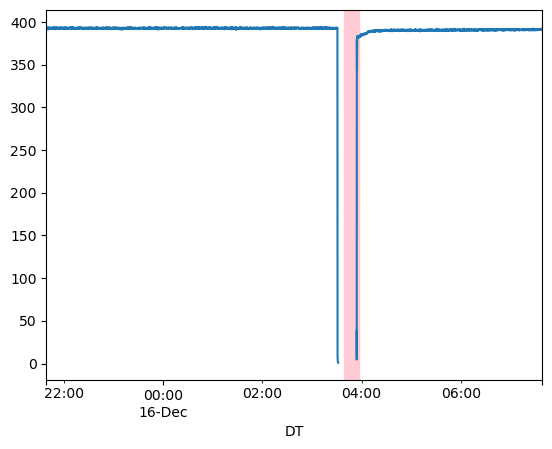

index                                                     2143
МАШИНА                                             AA2/002-006
ТЕХ_МЕСТО                                  AA2/002-006-001-010
НАЗВАНИЕ_ТЕХ_МЕСТА    ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ2
ОПИСАНИЕ                  остановка эксг. №5 (сработал АВ ВУ2)
t2                                         2021-12-16 03:56:47
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          5
label                                                        1
Name: 2021-12-16 03:38:44, dtype: object

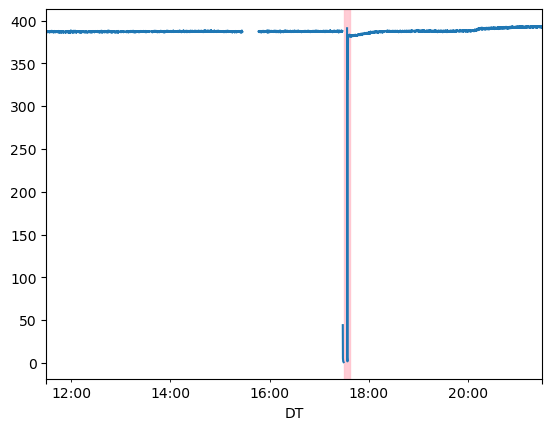

index                                                 2151
МАШИНА                                         AA2/002-006
ТЕХ_МЕСТО                          AA2/002-006-001-005-001
НАЗВАНИЕ_ТЕХ_МЕСТА                    ПОДШИПНИК ОПОРНЫЙ №1
ОПИСАНИЕ              остановка эксг. №5 (температура т.1)
t2                                     2021-12-22 17:36:59
ТЕКСТ_ГРУППЫ_КОДОВ                  ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                      5
label                                                    1
Name: 2021-12-22 17:29:58, dtype: object

,МАШИНА,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ОПИСАНИЕ,t1,t2,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
544,CH-AGP-AG2/005-005,CH-AGP-AG2/005-005-003-003,ЗАДВИЖКА ЭКСГ. №6,упала задвижка на эксгаустере,2019-05-01 16:29:38,2019-05-01 19:18:04,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,6,1
546,AA2/003-006,AA2/003-006-003-003,ЗАДВИЖКА ЭКСГ. №6,упала задвижка на эксгаустере,2019-05-01 19:18:04,2019-05-01 19:18:04,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,6,1
838,CH-AGP-AG2/005-005,CH-AGP-AG2/005-005-003-003,ЗАДВИЖКА ЭКСГ. №6,остановка эксгаустера №6 (обрыв гайки),2020-01-16 06:18:04,2020-01-16 08:12:18,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,6,1
848,CH-AGP-AG2/005-005,CH-AGP-AG2/005-005-003-003,ЗАДВИЖКА ЭКСГ. №6,остановка эксгаустера №6 (монтаж гайки),2020-01-17 10:09:38,2020-01-17 13:19:04,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,6,1
1389,CH-AGP-AG2/005-005,CH-AGP-AG2/005-005-003,ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №6,выпуск аглопыли из газового коллектора,2020-12-02 17:10:12,2020-12-02 17:27:14,ТЕХНОЛОГИЧЕСКИЕ ПЛАНОВЫЕ,6,1
1666,CH-AGP-AG2/005-005,CH-AGP-AG2/005-005-003-003,ЗАДВИЖКА ЭКСГ. №6,остановка эк-ра №6 (обрыв гайки),2021-04-16 13:23:07,2021-04-16 18:40:46,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,6,1
1670,AA2/003-006,AA2/003-006,ЭКСГАУСТЕР А/М №6,Согласованное ТО,2021-04-17 06:06:56,2021-04-17 06:27:58,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,6,1
1672,CH-AGP-AG2/005-005,CH-AGP-AG2/005-005-003-003,ЗАДВИЖКА ЭКСГ. №6,остановка эк-ра №6 (обрыв штока),2021-04-18 18:58:57,2021-04-18 23:22:29,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,6,1


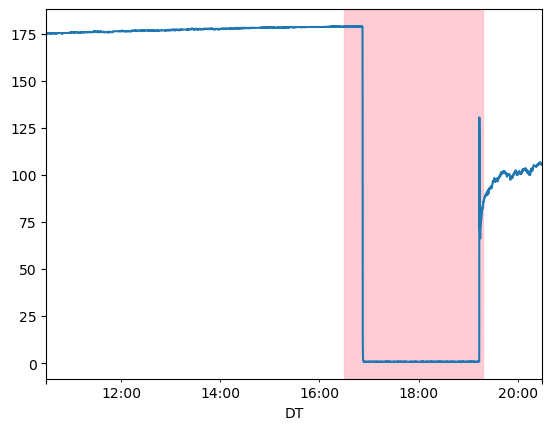

index                                           544
МАШИНА                           CH-AGP-AG2/005-005
ТЕХ_МЕСТО                CH-AGP-AG2/005-005-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                ЗАДВИЖКА ЭКСГ. №6
ОПИСАНИЕ              упала задвижка на эксгаустере
t2                              2019-05-01 19:18:04
ТЕКСТ_ГРУППЫ_КОДОВ           ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                               6
label                                             1
Name: 2019-05-01 16:29:38, dtype: object

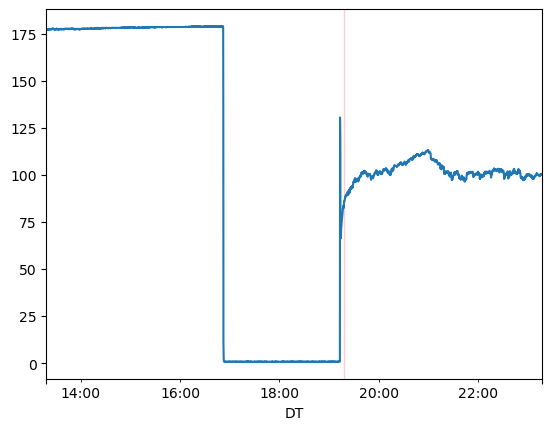

index                                           546
МАШИНА                                  AA2/003-006
ТЕХ_МЕСТО                       AA2/003-006-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                ЗАДВИЖКА ЭКСГ. №6
ОПИСАНИЕ              упала задвижка на эксгаустере
t2                              2019-05-01 19:18:04
ТЕКСТ_ГРУППЫ_КОДОВ           ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                               6
label                                             1
Name: 2019-05-01 19:18:04, dtype: object

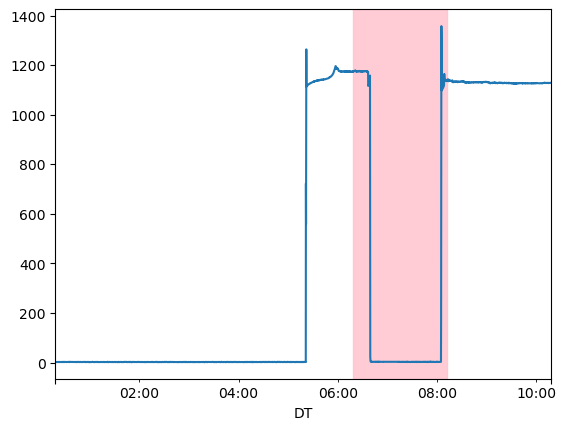

index                                                    838
МАШИНА                                    CH-AGP-AG2/005-005
ТЕХ_МЕСТО                         CH-AGP-AG2/005-005-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                         ЗАДВИЖКА ЭКСГ. №6
ОПИСАНИЕ              остановка эксгаустера №6 (обрыв гайки)
t2                                       2020-01-16 08:12:18
ТЕКСТ_ГРУППЫ_КОДОВ                    ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                        6
label                                                      1
Name: 2020-01-16 06:18:04, dtype: object

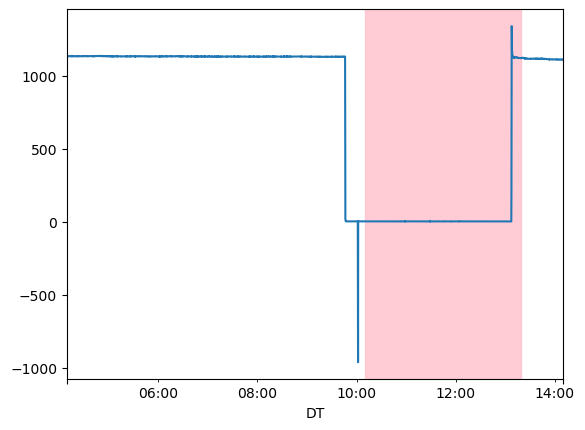

index                                                     848
МАШИНА                                     CH-AGP-AG2/005-005
ТЕХ_МЕСТО                          CH-AGP-AG2/005-005-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                          ЗАДВИЖКА ЭКСГ. №6
ОПИСАНИЕ              остановка эксгаустера №6 (монтаж гайки)
t2                                        2020-01-17 13:19:04
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         6
label                                                       1
Name: 2020-01-17 10:09:38, dtype: object

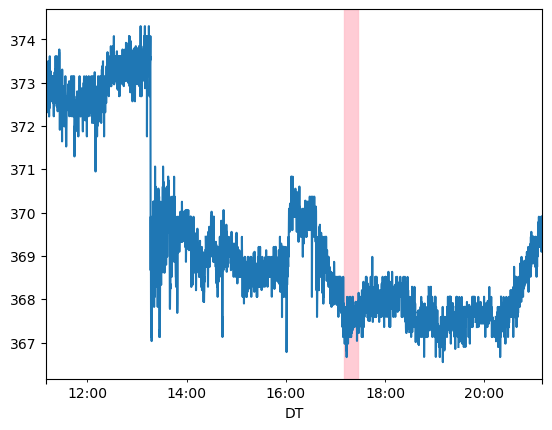

index                                                   1389
МАШИНА                                    CH-AGP-AG2/005-005
ТЕХ_МЕСТО                             CH-AGP-AG2/005-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА       ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №6
ОПИСАНИЕ              выпуск аглопыли из газового коллектора
t2                                       2020-12-02 17:27:14
ТЕКСТ_ГРУППЫ_КОДОВ                  ТЕХНОЛОГИЧЕСКИЕ ПЛАНОВЫЕ
num                                                        6
label                                                      1
Name: 2020-12-02 17:10:12, dtype: object

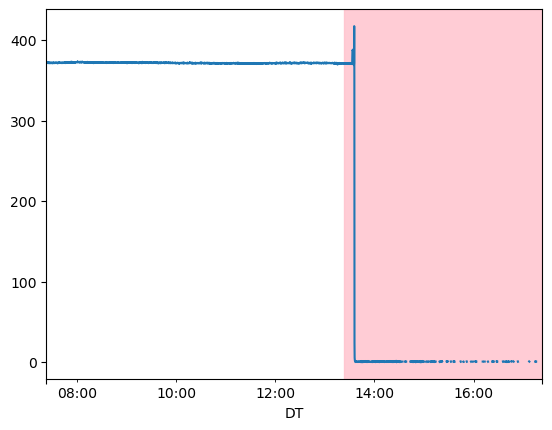

index                                             1666
МАШИНА                              CH-AGP-AG2/005-005
ТЕХ_МЕСТО                   CH-AGP-AG2/005-005-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                   ЗАДВИЖКА ЭКСГ. №6
ОПИСАНИЕ              остановка эк-ра №6 (обрыв гайки)
t2                                 2021-04-16 18:40:46
ТЕКСТ_ГРУППЫ_КОДОВ              ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                  6
label                                                1
Name: 2021-04-16 13:23:07, dtype: object

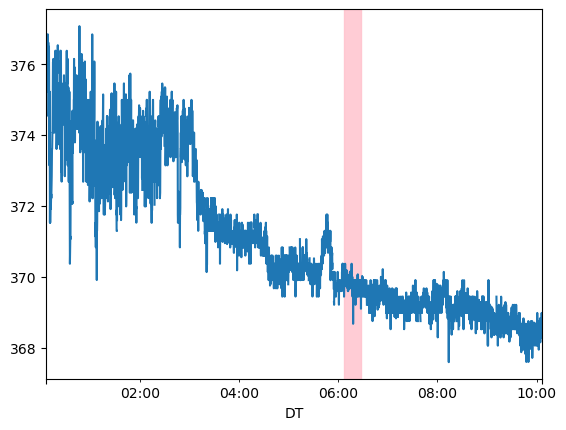

index                                 1670
МАШИНА                         AA2/003-006
ТЕХ_МЕСТО                      AA2/003-006
НАЗВАНИЕ_ТЕХ_МЕСТА       ЭКСГАУСТЕР А/М №6
ОПИСАНИЕ                  Согласованное ТО
t2                     2021-04-17 06:27:58
ТЕКСТ_ГРУППЫ_КОДОВ    ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ
num                                      6
label                                    1
Name: 2021-04-17 06:06:56, dtype: object

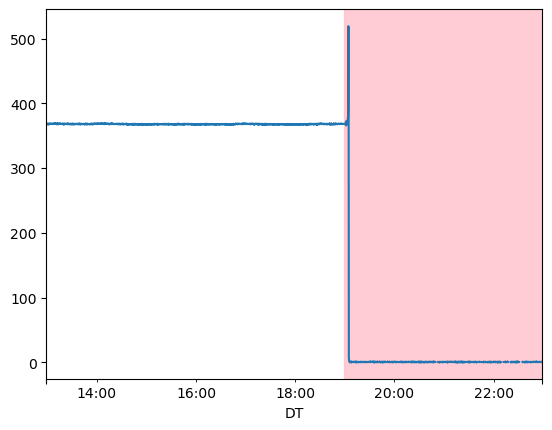

index                                             1672
МАШИНА                              CH-AGP-AG2/005-005
ТЕХ_МЕСТО                   CH-AGP-AG2/005-005-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                   ЗАДВИЖКА ЭКСГ. №6
ОПИСАНИЕ              остановка эк-ра №6 (обрыв штока)
t2                                 2021-04-18 23:22:29
ТЕКСТ_ГРУППЫ_КОДОВ              ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                  6
label                                                1
Name: 2021-04-18 18:58:57, dtype: object

,МАШИНА,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ОПИСАНИЕ,t1,t2,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
560,AA2/001-006,AA2/001-006-001-007-001,ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4,Не отжался верхний концевой на задвижке,2019-05-18 08:27:00,2019-05-18 08:35:51,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
566,AA2/001-006,AA2/001-006-001-001-003,ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4,остановка эксгаустера по температуре т2,2019-05-29 16:56:26,2019-05-29 16:58:29,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
601,CH-AGP-AG2/001-005,CH-AGP-AG2/001-005-001-005-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4,остановка эксгаустера №4 (кабель дв-ля),2019-07-10 21:43:55,2019-07-10 22:41:02,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
602,CH-AGP-AG2/001-005,CH-AGP-AG2/001-005-001-005-002,ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4,остановка эксгаустера (температура),2019-07-30 19:14:34,2019-07-30 19:20:35,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
603,AA2/001-006,AA2/001-006-001-001-003,ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4,остановка эксгаустера (температура),2019-07-30 19:20:35,2019-07-30 19:20:35,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
711,AA2/001-006,AA2/001-006-003-003,ЗАДВИЖКА ЭКСГ. №4,остановка эк-га №4 (газ. задвижка),2019-10-29 12:41:59,2019-10-29 14:13:11,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
950,AA2/001-006,AA2/001-006-003-003,ЗАДВИЖКА ЭКСГ. №4,остановка эксгаустера №4 (редуктор г.з.),2020-04-01 10:19:09,2020-04-01 10:28:12,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
953,AA2/001-006,AA2/001-006-003-003,ЗАДВИЖКА ЭКСГ. №4,остановка эксгаустера №4 (редуктор г.з.),2020-04-03 07:17:48,2020-04-03 07:40:50,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
955,AA2/001-006,AA2/001-006-001-005,ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №4,остановка эксгаустера №4 (утечка масла),2020-04-04 19:32:23,2020-04-04 21:05:34,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,4,1
969,CH-AGP-AG2/001-005,CH-AGP-AG2/001-005,ЭКСГАУСТЕР А/М №4,ТО,2020-04-10 09:05:10,2020-04-10 12:44:37,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,4,1


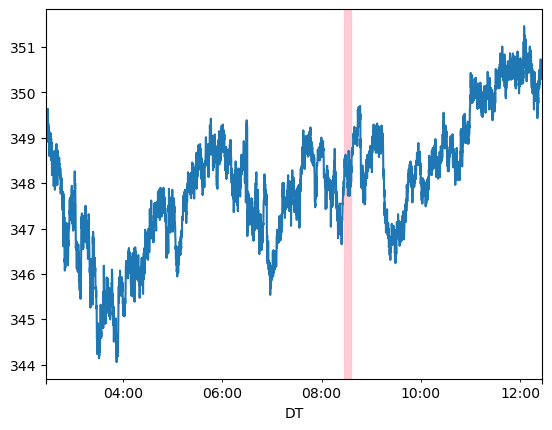

index                                                     560
МАШИНА                                            AA2/001-006
ТЕХ_МЕСТО                             AA2/001-006-001-007-001
НАЗВАНИЕ_ТЕХ_МЕСТА                 ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4
ОПИСАНИЕ              Не отжался верхний концевой на задвижке
t2                                        2019-05-18 08:35:51
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         4
label                                                       1
Name: 2019-05-18 08:27:00, dtype: object

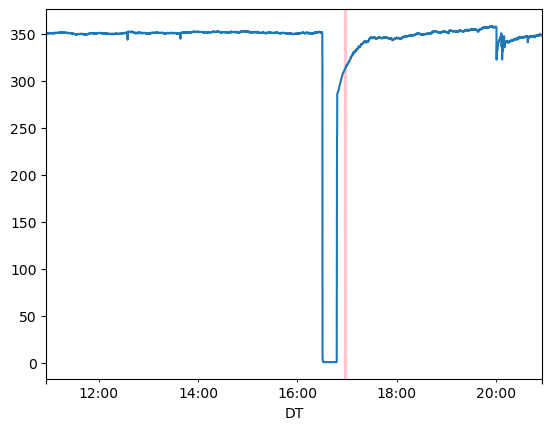

index                                                     566
МАШИНА                                            AA2/001-006
ТЕХ_МЕСТО                             AA2/001-006-001-001-003
НАЗВАНИЕ_ТЕХ_МЕСТА              ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4
ОПИСАНИЕ              остановка эксгаустера по температуре т2
t2                                        2019-05-29 16:58:29
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         4
label                                                       1
Name: 2019-05-29 16:56:26, dtype: object

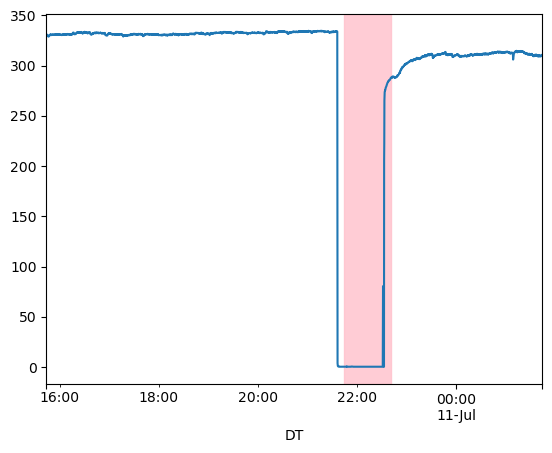

index                                                     601
МАШИНА                                     CH-AGP-AG2/001-005
ТЕХ_МЕСТО                      CH-AGP-AG2/001-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4
ОПИСАНИЕ              остановка эксгаустера №4 (кабель дв-ля)
t2                                        2019-07-10 22:41:02
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         4
label                                                       1
Name: 2019-07-10 21:43:55, dtype: object

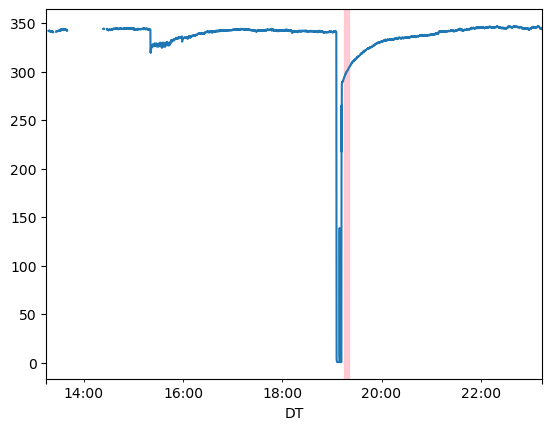

index                                                 602
МАШИНА                                 CH-AGP-AG2/001-005
ТЕХ_МЕСТО                  CH-AGP-AG2/001-005-001-005-002
НАЗВАНИЕ_ТЕХ_МЕСТА          ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4
ОПИСАНИЕ              остановка эксгаустера (температура)
t2                                    2019-07-30 19:20:35
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     4
label                                                   1
Name: 2019-07-30 19:14:34, dtype: object

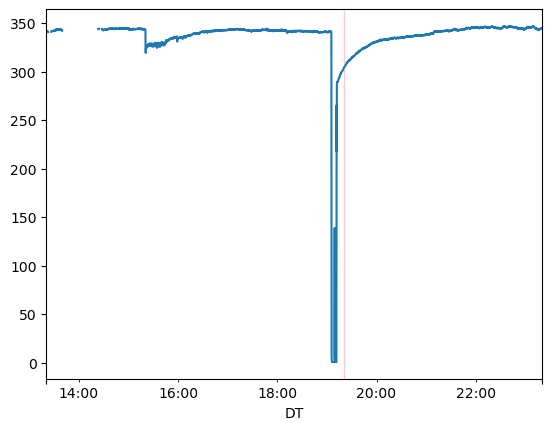

index                                                 603
МАШИНА                                        AA2/001-006
ТЕХ_МЕСТО                         AA2/001-006-001-001-003
НАЗВАНИЕ_ТЕХ_МЕСТА          ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4
ОПИСАНИЕ              остановка эксгаустера (температура)
t2                                    2019-07-30 19:20:35
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     4
label                                                   1
Name: 2019-07-30 19:20:35, dtype: object

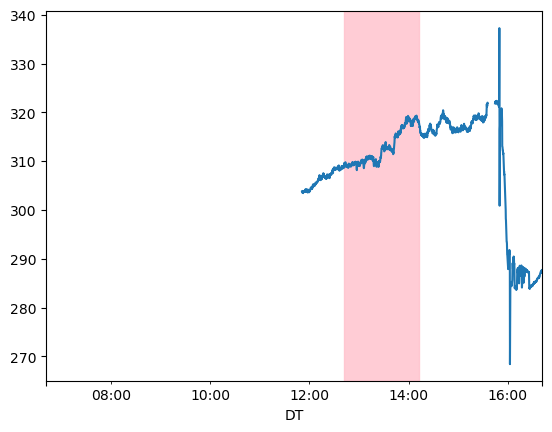

index                                                711
МАШИНА                                       AA2/001-006
ТЕХ_МЕСТО                            AA2/001-006-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                     ЗАДВИЖКА ЭКСГ. №4
ОПИСАНИЕ              остановка эк-га №4 (газ. задвижка)
t2                                   2019-10-29 14:13:11
ТЕКСТ_ГРУППЫ_КОДОВ                ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                    4
label                                                  1
Name: 2019-10-29 12:41:59, dtype: object

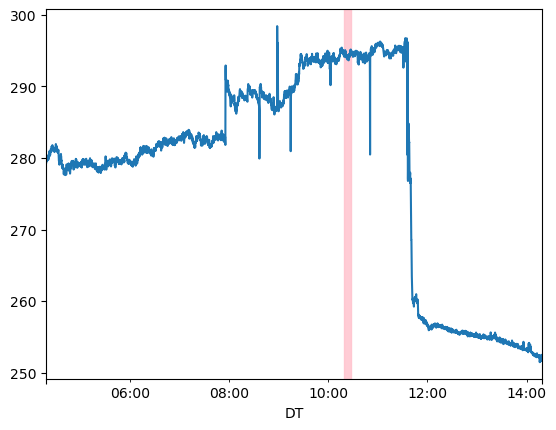

index                                                      950
МАШИНА                                             AA2/001-006
ТЕХ_МЕСТО                                  AA2/001-006-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                           ЗАДВИЖКА ЭКСГ. №4
ОПИСАНИЕ              остановка эксгаустера №4 (редуктор г.з.)
t2                                         2020-04-01 10:28:12
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          4
label                                                        1
Name: 2020-04-01 10:19:09, dtype: object

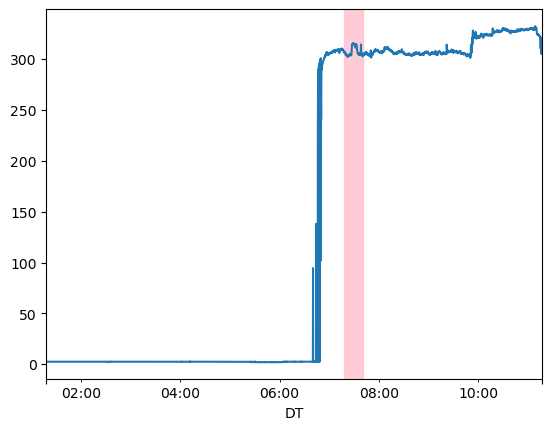

index                                                      953
МАШИНА                                             AA2/001-006
ТЕХ_МЕСТО                                  AA2/001-006-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                           ЗАДВИЖКА ЭКСГ. №4
ОПИСАНИЕ              остановка эксгаустера №4 (редуктор г.з.)
t2                                         2020-04-03 07:40:50
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          4
label                                                        1
Name: 2020-04-03 07:17:48, dtype: object

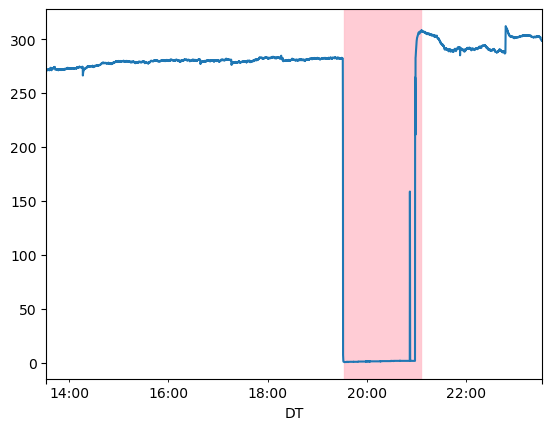

index                                                     955
МАШИНА                                            AA2/001-006
ТЕХ_МЕСТО                                 AA2/001-006-001-005
НАЗВАНИЕ_ТЕХ_МЕСТА          ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №4
ОПИСАНИЕ              остановка эксгаустера №4 (утечка масла)
t2                                        2020-04-04 21:05:34
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         4
label                                                       1
Name: 2020-04-04 19:32:23, dtype: object

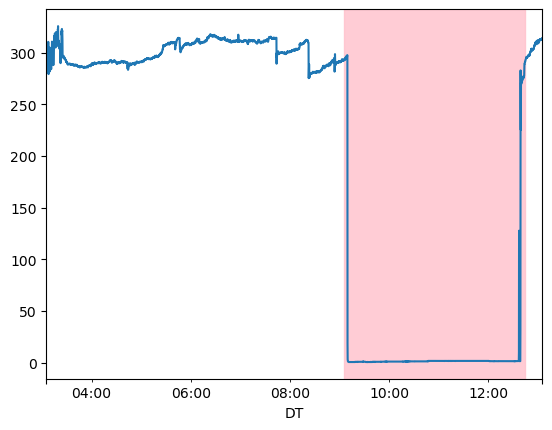

index                                  969
МАШИНА                  CH-AGP-AG2/001-005
ТЕХ_МЕСТО               CH-AGP-AG2/001-005
НАЗВАНИЕ_ТЕХ_МЕСТА       ЭКСГАУСТЕР А/М №4
ОПИСАНИЕ                                ТО
t2                     2020-04-10 12:44:37
ТЕКСТ_ГРУППЫ_КОДОВ    ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ
num                                      4
label                                    1
Name: 2020-04-10 09:05:10, dtype: object

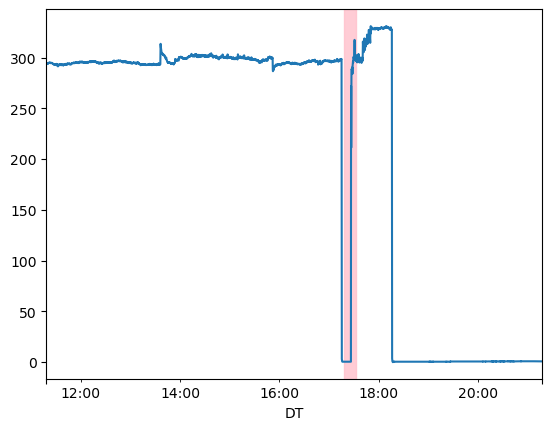

index                                                   1081
МАШИНА                                           AA2/001-006
ТЕХ_МЕСТО                                AA2/001-006-001-004
НАЗВАНИЕ_ТЕХ_МЕСТА                            РОТОР ЭКСГ. №4
ОПИСАНИЕ              остановка эк-ра №4 (температура в т.2)
t2                                       2020-06-15 17:32:09
ТЕКСТ_ГРУППЫ_КОДОВ                    ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                        4
label                                                      1
Name: 2020-06-15 17:18:08, dtype: object

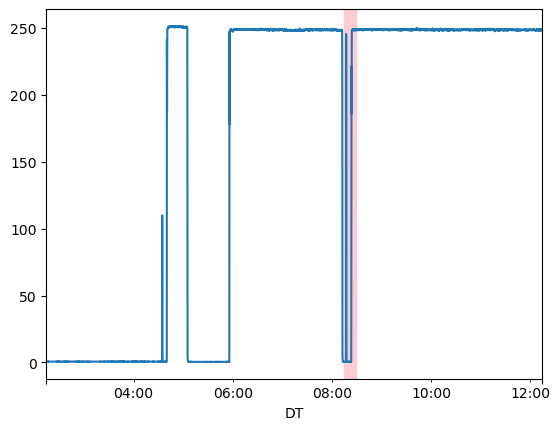

index                                                   1190
МАШИНА                                    CH-AGP-AG2/001-005
ТЕХ_МЕСТО                         CH-AGP-AG2/001-005-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                            РОТОР ЭКСГ. №4
ОПИСАНИЕ              остановка эк-ра №4 (температура в т.2)
t2                                       2020-07-29 08:29:32
ТЕКСТ_ГРУППЫ_КОДОВ                    ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                        4
label                                                      1
Name: 2020-07-29 08:14:30, dtype: object

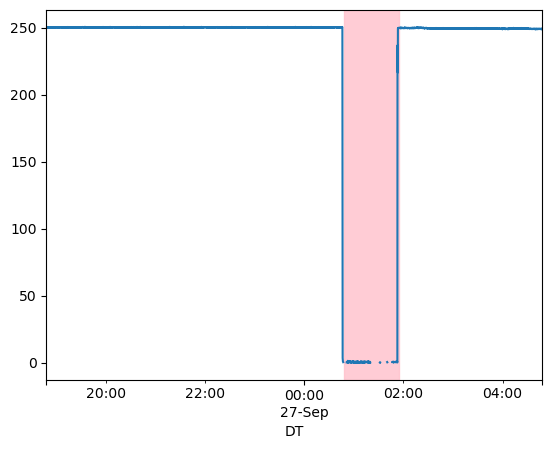

index                                                    1289
МАШИНА                                     CH-AGP-AG2/001-005
ТЕХ_МЕСТО                      CH-AGP-AG2/001-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4
ОПИСАНИЕ                     остановка эк-ра №4 (защита 10РУ)
t2                                        2020-09-27 01:55:11
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         4
label                                                       1
Name: 2020-09-27 00:48:03, dtype: object

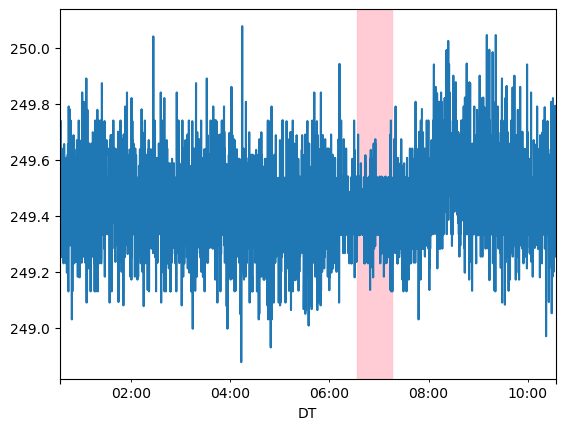

index                                                  1305
МАШИНА                                   CH-AGP-AG2/001-005
ТЕХ_МЕСТО                        CH-AGP-AG2/001-005-003-003
НАЗВАНИЕ_ТЕХ_МЕСТА                        ЗАДВИЖКА ЭКСГ. №4
ОПИСАНИЕ              остановка эк-ра №4 (газовая задвижка)
t2                                      2020-09-30 07:15:50
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       4
label                                                     1
Name: 2020-09-30 06:33:42, dtype: object

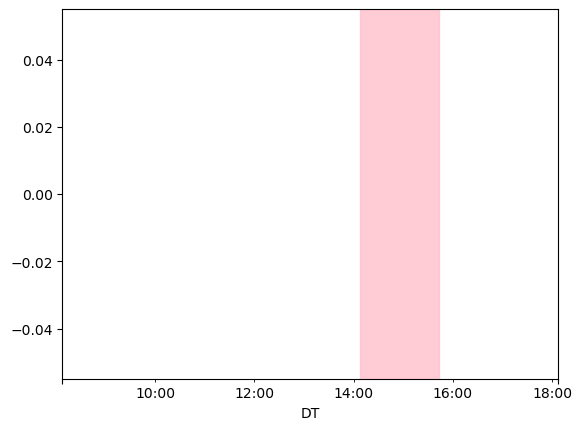

index                                                     1341
МАШИНА                                      CH-AGP-AG2/001-005
ТЕХ_МЕСТО                           CH-AGP-AG2/001-005-003-002
НАЗВАНИЕ_ТЕХ_МЕСТА             РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4
ОПИСАНИЕ              ТО(замена редуктора газовой задвижки №4)
t2                                         2020-10-26 15:43:46
ТЕКСТ_ГРУППЫ_КОДОВ                        ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ
num                                                          4
label                                                        1
Name: 2020-10-26 14:07:34, dtype: object

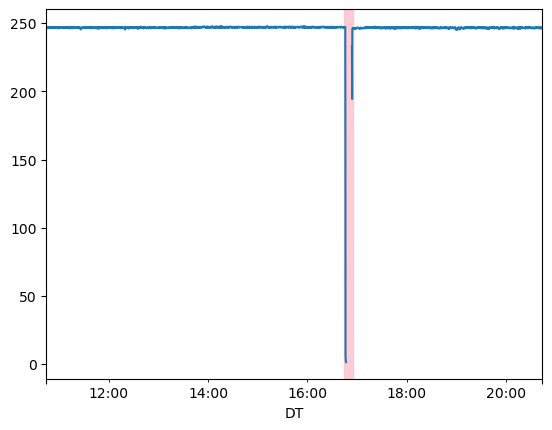

index                                                  1421
МАШИНА                                   CH-AGP-AG2/001-005
ТЕХ_МЕСТО                                CH-AGP-AG2/001-005
НАЗВАНИЕ_ТЕХ_МЕСТА                        ЭКСГАУСТЕР А/М №4
ОПИСАНИЕ              остановка эксг-ра №4 (защита 2РУ МТЗ)
t2                                      2020-12-27 16:55:20
ТЕКСТ_ГРУППЫ_КОДОВ               ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       4
label                                                     1
Name: 2020-12-27 16:44:19, dtype: object

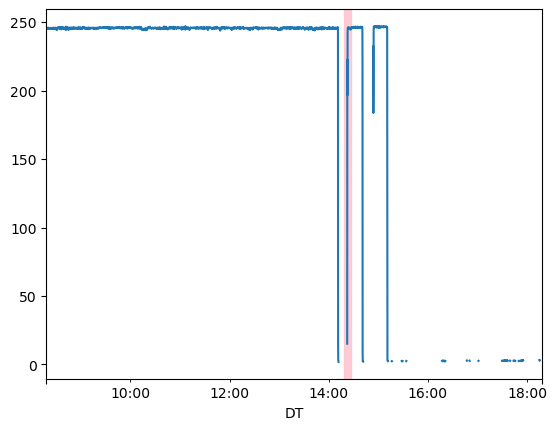

index                                                  1454
МАШИНА                                          AA2/001-006
ТЕХ_МЕСТО                               AA2/001-006-001-004
НАЗВАНИЕ_ТЕХ_МЕСТА                           РОТОР ЭКСГ. №4
ОПИСАНИЕ              остановка эксг-ра №4 (вибрация в т.3)
t2                                      2021-01-19 14:27:26
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       4
label                                                     1
Name: 2021-01-19 14:18:25, dtype: object

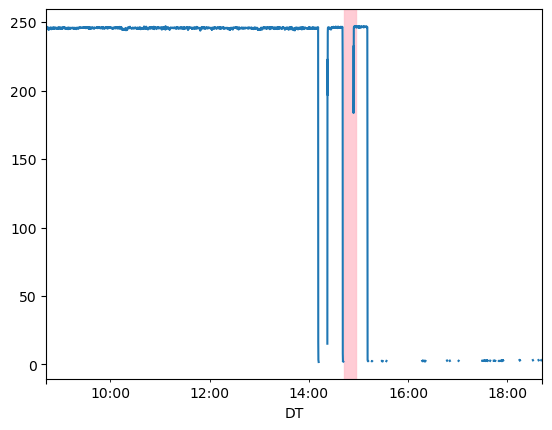

index                                                  1456
МАШИНА                                   CH-AGP-AG2/001-005
ТЕХ_МЕСТО                        CH-AGP-AG2/001-005-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                           РОТОР ЭКСГ. №4
ОПИСАНИЕ              остановка эксг-ра №4 (вибрация в т.3)
t2                                      2021-01-19 14:56:30
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       4
label                                                     1
Name: 2021-01-19 14:42:28, dtype: object

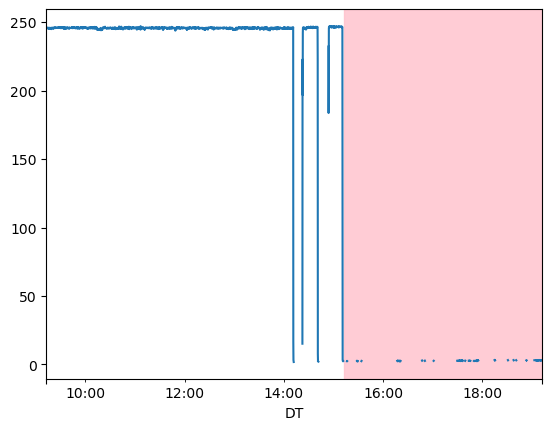

index                                                  1458
МАШИНА                                          AA2/001-006
ТЕХ_МЕСТО                               AA2/001-006-001-004
НАЗВАНИЕ_ТЕХ_МЕСТА                           РОТОР ЭКСГ. №4
ОПИСАНИЕ              остановка эксг-ра №4 (вибрация в т.3)
t2                                      2021-01-19 19:29:05
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       4
label                                                     1
Name: 2021-01-19 15:12:31, dtype: object

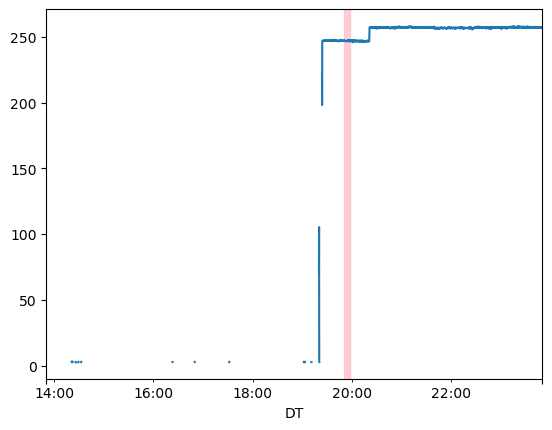

index                                                   1529
МАШИНА                                           AA2/001-006
ТЕХ_МЕСТО                            AA2/001-006-001-007-001
НАЗВАНИЕ_ТЕХ_МЕСТА                ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4
ОПИСАНИЕ              остановка экс-ра №4 (РТ газ. задвижки)
t2                                       2021-02-17 19:57:35
ТЕКСТ_ГРУППЫ_КОДОВ                    ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                        4
label                                                      1
Name: 2021-02-17 19:50:34, dtype: object

,МАШИНА,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ОПИСАНИЕ,t1,t2,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
568,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005-001-005-002,ПОДШИПНИК ОПОРНЫЙ №2,остановка эксгаустера по температуре т2,2019-05-30 07:58:27,2019-05-30 08:13:29,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1
829,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005,ЭКСГАУСТЕР А/М №7,остановка эксгаустера №7 (МТЗ),2020-01-10 19:38:18,2020-01-10 19:44:19,ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1
1127,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005-001-005-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №7,остановка эк-ра №7 (вибрация в т.3),2020-06-30 11:36:33,2020-06-30 12:10:37,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1
1145,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005-001-005-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №7,остановка эк-ра №7 (замена ротора),2020-06-30 17:34:18,2020-06-30 21:05:44,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1
1148,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005-001-005-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №7,остановка эк-ра №7 (температура в т.2),2020-07-03 02:01:24,2020-07-03 02:17:26,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1
1362,AA2/004-006,AA2/004-006-001-002,РОТОР ЭКСГ. №7,остановка эксг-ра №7 (давление масла),2020-11-05 17:54:27,2020-11-05 18:02:28,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1
1384,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005-001-007-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №7,остановка эксг-ра №7 (питание 100В ВУ-1),2020-11-25 13:03:54,2020-11-25 13:11:55,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1
1397,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005-001-002,РОТОР ЭКСГ. №7,остановка эксг-ра №7 (давление масла),2020-12-17 12:31:05,2020-12-17 12:44:06,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1
1418,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005,ЭКСГАУСТЕР А/М №7,ТО согласованное,2020-12-24 09:44:34,2020-12-24 15:04:16,ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ,7,1
1469,CH-AGP-AG2/007-005,CH-AGP-AG2/007-005-001-002,РОТОР ЭКСГ. №7,остановка эксг-ра №7 (давление масла),2021-01-21 13:30:21,2021-01-21 13:39:20,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,7,1


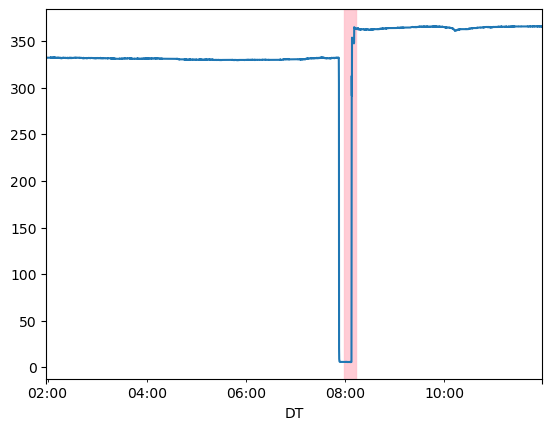

index                                                     568
МАШИНА                                     CH-AGP-AG2/007-005
ТЕХ_МЕСТО                      CH-AGP-AG2/007-005-001-005-002
НАЗВАНИЕ_ТЕХ_МЕСТА                       ПОДШИПНИК ОПОРНЫЙ №2
ОПИСАНИЕ              остановка эксгаустера по температуре т2
t2                                        2019-05-30 08:13:29
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         7
label                                                       1
Name: 2019-05-30 07:58:27, dtype: object

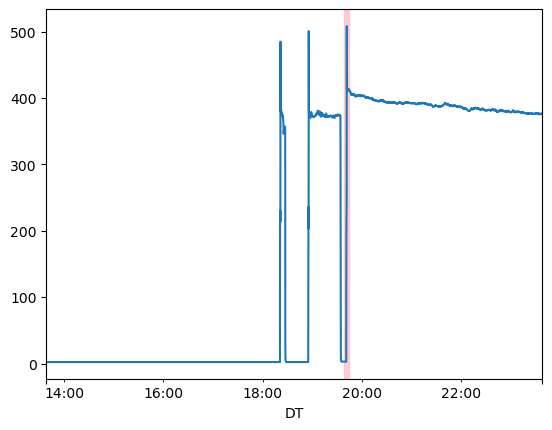

index                                            829
МАШИНА                            CH-AGP-AG2/007-005
ТЕХ_МЕСТО                         CH-AGP-AG2/007-005
НАЗВАНИЕ_ТЕХ_МЕСТА                 ЭКСГАУСТЕР А/М №7
ОПИСАНИЕ              остановка эксгаустера №7 (МТЗ)
t2                               2020-01-10 19:44:19
ТЕКСТ_ГРУППЫ_КОДОВ        ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                7
label                                              1
Name: 2020-01-10 19:38:18, dtype: object

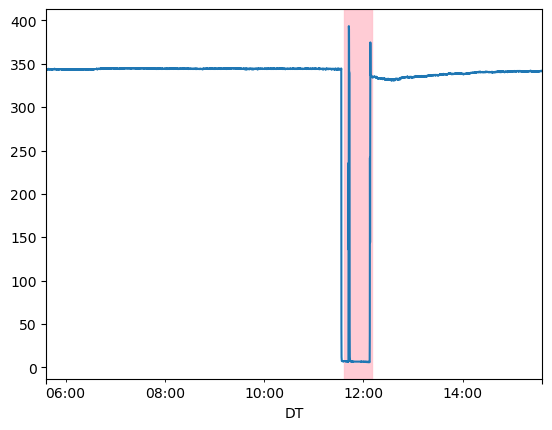

index                                                    1127
МАШИНА                                     CH-AGP-AG2/007-005
ТЕХ_МЕСТО                      CH-AGP-AG2/007-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №7
ОПИСАНИЕ                  остановка эк-ра №7 (вибрация в т.3)
t2                                        2020-06-30 12:10:37
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         7
label                                                       1
Name: 2020-06-30 11:36:33, dtype: object

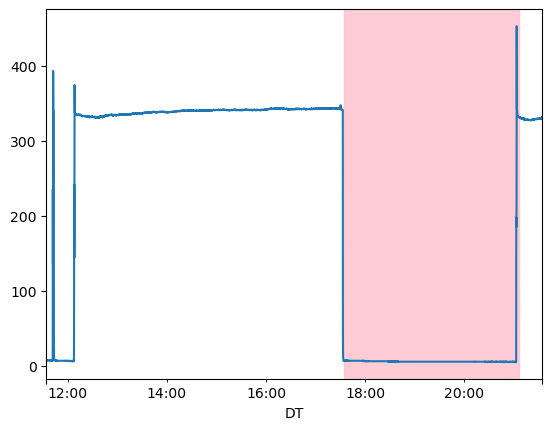

index                                                    1145
МАШИНА                                     CH-AGP-AG2/007-005
ТЕХ_МЕСТО                      CH-AGP-AG2/007-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №7
ОПИСАНИЕ                   остановка эк-ра №7 (замена ротора)
t2                                        2020-06-30 21:05:44
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         7
label                                                       1
Name: 2020-06-30 17:34:18, dtype: object

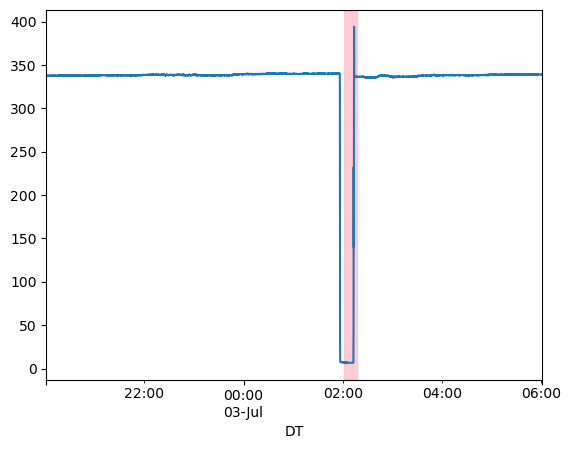

index                                                    1148
МАШИНА                                     CH-AGP-AG2/007-005
ТЕХ_МЕСТО                      CH-AGP-AG2/007-005-001-005-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №7
ОПИСАНИЕ               остановка эк-ра №7 (температура в т.2)
t2                                        2020-07-03 02:17:26
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         7
label                                                       1
Name: 2020-07-03 02:01:24, dtype: object

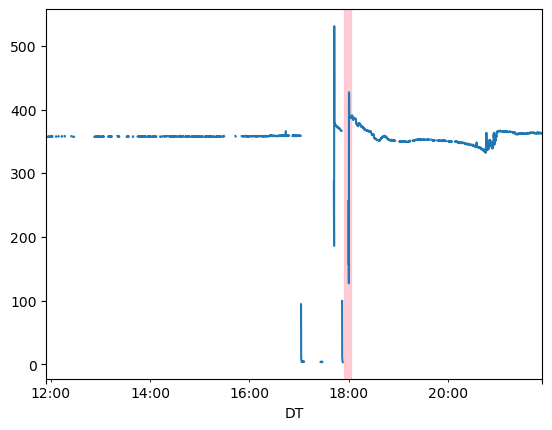

index                                                  1362
МАШИНА                                          AA2/004-006
ТЕХ_МЕСТО                               AA2/004-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                           РОТОР ЭКСГ. №7
ОПИСАНИЕ              остановка эксг-ра №7 (давление масла)
t2                                      2020-11-05 18:02:28
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       7
label                                                     1
Name: 2020-11-05 17:54:27, dtype: object

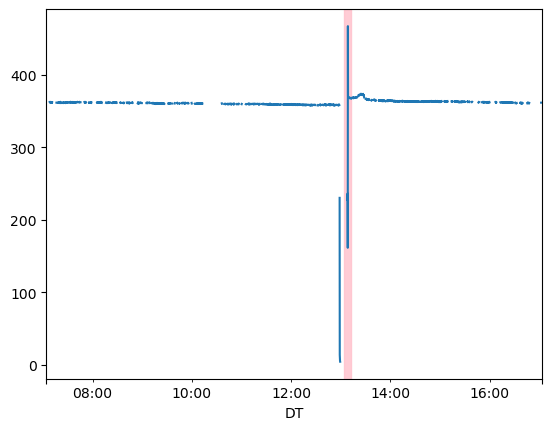

index                                                     1384
МАШИНА                                      CH-AGP-AG2/007-005
ТЕХ_МЕСТО                       CH-AGP-AG2/007-005-001-007-001
НАЗВАНИЕ_ТЕХ_МЕСТА          ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №7
ОПИСАНИЕ              остановка эксг-ра №7 (питание 100В ВУ-1)
t2                                         2020-11-25 13:11:55
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          7
label                                                        1
Name: 2020-11-25 13:03:54, dtype: object

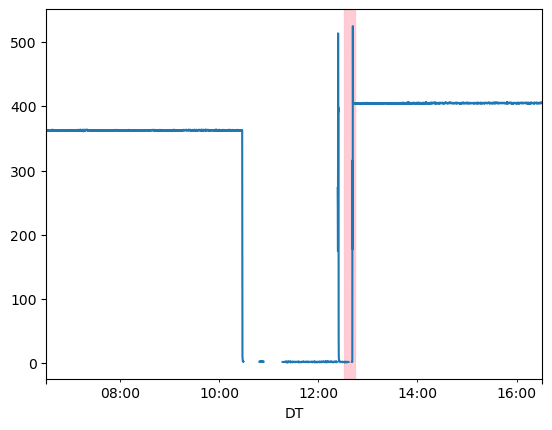

index                                                  1397
МАШИНА                                   CH-AGP-AG2/007-005
ТЕХ_МЕСТО                        CH-AGP-AG2/007-005-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                           РОТОР ЭКСГ. №7
ОПИСАНИЕ              остановка эксг-ра №7 (давление масла)
t2                                      2020-12-17 12:44:06
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       7
label                                                     1
Name: 2020-12-17 12:31:05, dtype: object

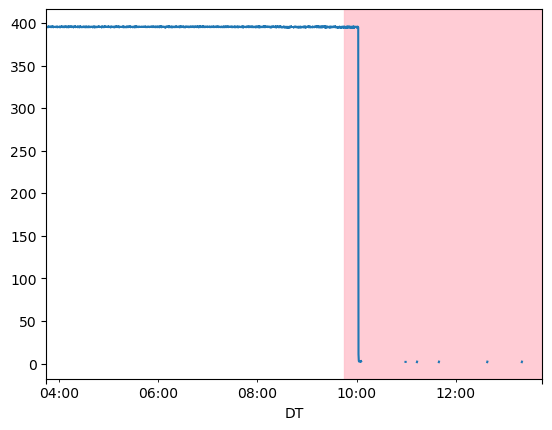

index                                 1418
МАШИНА                  CH-AGP-AG2/007-005
ТЕХ_МЕСТО               CH-AGP-AG2/007-005
НАЗВАНИЕ_ТЕХ_МЕСТА       ЭКСГАУСТЕР А/М №7
ОПИСАНИЕ                  ТО согласованное
t2                     2020-12-24 15:04:16
ТЕКСТ_ГРУППЫ_КОДОВ    ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ
num                                      7
label                                    1
Name: 2020-12-24 09:44:34, dtype: object

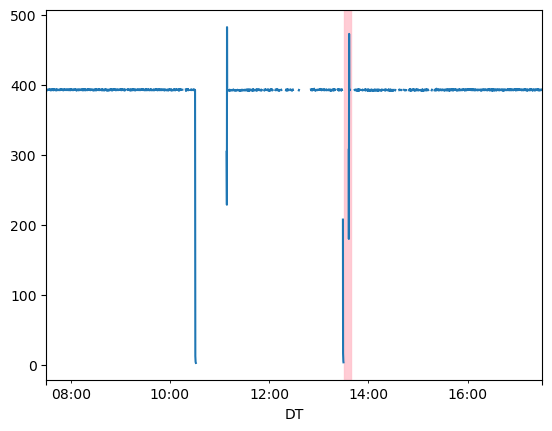

index                                                  1469
МАШИНА                                   CH-AGP-AG2/007-005
ТЕХ_МЕСТО                        CH-AGP-AG2/007-005-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                           РОТОР ЭКСГ. №7
ОПИСАНИЕ              остановка эксг-ра №7 (давление масла)
t2                                      2021-01-21 13:39:20
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       7
label                                                     1
Name: 2021-01-21 13:30:21, dtype: object

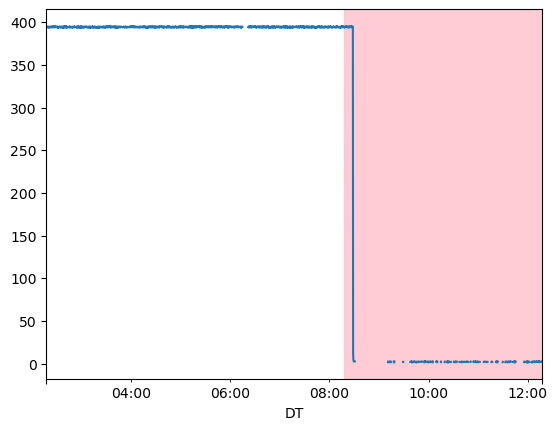

index                                 1484
МАШИНА                         AA2/004-006
ТЕХ_МЕСТО                      AA2/004-006
НАЗВАНИЕ_ТЕХ_МЕСТА       ЭКСГАУСТЕР А/М №7
ОПИСАНИЕ                                ТО
t2                     2021-01-27 14:21:27
ТЕКСТ_ГРУППЫ_КОДОВ    ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ
num                                      7
label                                    1
Name: 2021-01-27 08:17:41, dtype: object

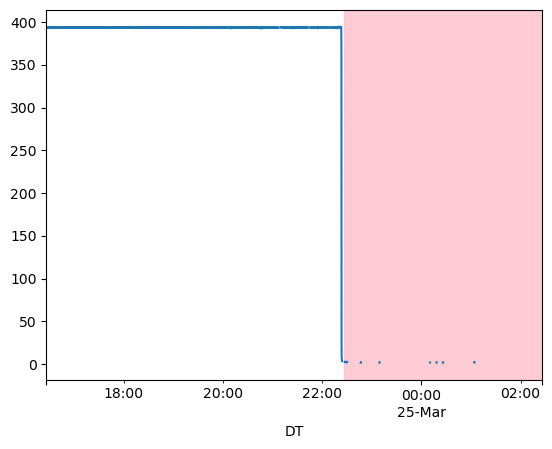

index                                                1592
МАШИНА                                 CH-AGP-AG2/007-005
ТЕХ_МЕСТО                      CH-AGP-AG2/007-005-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №7
ОПИСАНИЕ              остановка эк-ра №7 (вибрация в т.1)
t2                                    2021-03-25 05:20:14
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     7
label                                                   1
Name: 2021-03-24 22:26:22, dtype: object

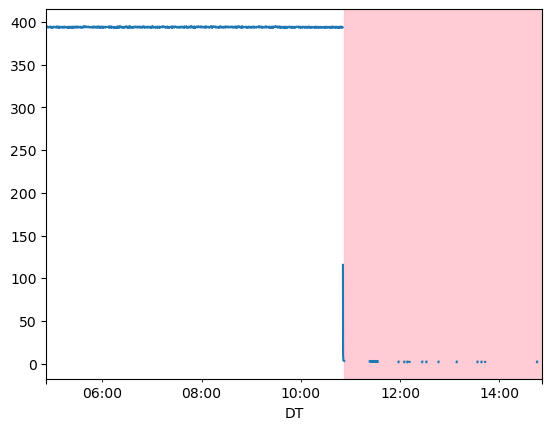

index                                                 1604
МАШИНА                                  CH-AGP-AG2/007-005
ТЕХ_МЕСТО                       CH-AGP-AG2/007-005-001-001
НАЗВАНИЕ_ТЕХ_МЕСТА                         КОРПУС ЭКСГ. №7
ОПИСАНИЕ              остановка эк-ра №7 (замена эксг. №8)
t2                                     2021-03-29 15:26:41
ТЕКСТ_ГРУППЫ_КОДОВ                  ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                      7
label                                                    1
Name: 2021-03-29 10:52:09, dtype: object

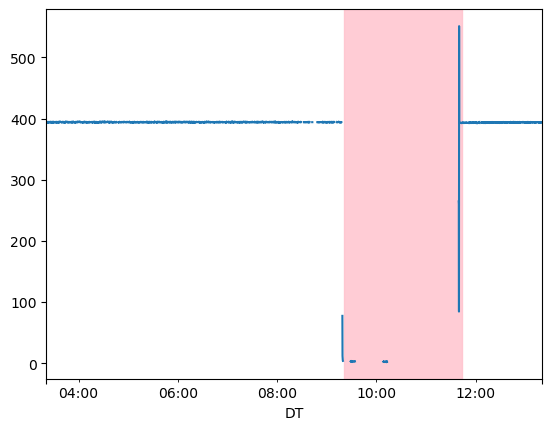

index                                                 1632
МАШИНА                                         AA2/004-006
ТЕХ_МЕСТО                              AA2/004-006-001-001
НАЗВАНИЕ_ТЕХ_МЕСТА                         КОРПУС ЭКСГ. №7
ОПИСАНИЕ              остановка эк-ра №7 (замена эксг. №4)
t2                                     2021-04-02 11:43:10
ТЕКСТ_ГРУППЫ_КОДОВ                  ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                      7
label                                                    1
Name: 2021-04-02 09:20:52, dtype: object

,МАШИНА,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ОПИСАНИЕ,t1,t2,ТЕКСТ_ГРУППЫ_КОДОВ,num,label
644,CH-AGP-AG2/009-005,CH-AGP-AG2/009-005-001-011,ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5,Не запускался эксгаустер АМ-8,2019-08-29 18:49:31,2019-08-29 19:17:37,ВНЕШНИЕ ОРГАНИЗАЦИИ,8,1
710,CH-AGP-AG2/009-005,CH-AGP-AG2/009-005,ЭКСГАУСТЕР А/М №8,остановка эк-га №8 (токовая защита),2019-10-29 10:22:00,2019-10-29 10:34:00,ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1
935,CH-AGP-AG2/009-005,CH-AGP-AG2/009-005-001-010,ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ8 ВУ1,остановка эксгаустера №8 (2РУ МТЗ),2020-03-21 05:46:47,2020-03-21 06:15:51,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1
937,CH-AGP-AG2/009-005,CH-AGP-AG2/009-005-001-010,ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ8 ВУ1,остановка эксгаустера №8 (2РУ МТЗ),2020-03-21 06:21:52,2020-03-21 06:30:53,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1
1022,AA2/005-006,AA2/005-006-001-012-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8,остановка эк-ра №6 (обрыв цепи ротора),2020-05-12 03:40:36,2020-05-12 12:20:42,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1
1030,AA2/005-006,AA2/005-006-001-002,РОТОР ЭКСГ. №8,остановка эк-ра №8 (вибрация в т.3),2020-05-13 02:32:29,2020-05-13 02:54:32,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1
1035,AA2/005-006,AA2/005-006-001-002,РОТОР ЭКСГ. №8,остановка эк-ра №8 (вибрация в т.3),2020-05-15 03:42:38,2020-05-15 03:49:39,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1
1039,CH-AGP-AG2/009-005,CH-AGP-AG2/009-005-001-002,РОТОР ЭКСГ. №8,остановка эк-ра №8 (вибрация в т.3),2020-05-15 07:57:11,2020-05-15 18:26:30,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1
1057,AA2/005-006,AA2/005-006-001-012-003,ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8,остановка эк-ра №8 (КЗ обмотки статора),2020-05-30 10:25:23,2020-05-31 08:32:06,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1
1079,AA2/005-006,AA2/005-006-001-005-001,ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №8,остановка эк-ра №8 (МТЗ 2РУ с ускор.),2020-06-13 06:12:44,2020-06-13 06:25:45,ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ,8,1


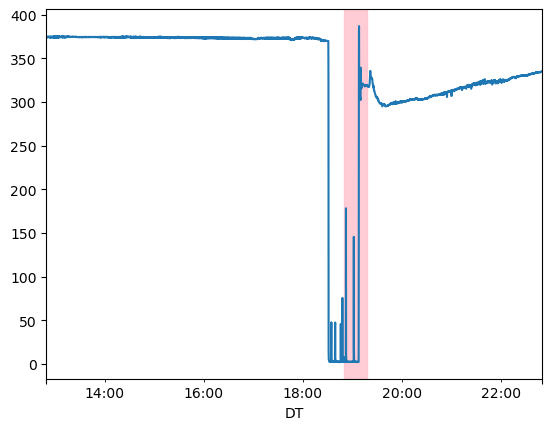

index                                                    644
МАШИНА                                    CH-AGP-AG2/009-005
ТЕХ_МЕСТО                         CH-AGP-AG2/009-005-001-011
НАЗВАНИЕ_ТЕХ_МЕСТА    ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5
ОПИСАНИЕ                       Не запускался эксгаустер АМ-8
t2                                       2019-08-29 19:17:37
ТЕКСТ_ГРУППЫ_КОДОВ                       ВНЕШНИЕ ОРГАНИЗАЦИИ
num                                                        8
label                                                      1
Name: 2019-08-29 18:49:31, dtype: object

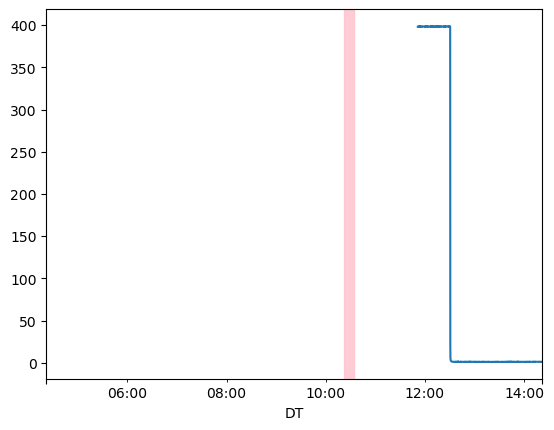

index                                                 710
МАШИНА                                 CH-AGP-AG2/009-005
ТЕХ_МЕСТО                              CH-AGP-AG2/009-005
НАЗВАНИЕ_ТЕХ_МЕСТА                      ЭКСГАУСТЕР А/М №8
ОПИСАНИЕ              остановка эк-га №8 (токовая защита)
t2                                    2019-10-29 10:34:00
ТЕКСТ_ГРУППЫ_КОДОВ             ТЕХНОЛОГИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     8
label                                                   1
Name: 2019-10-29 10:22:00, dtype: object

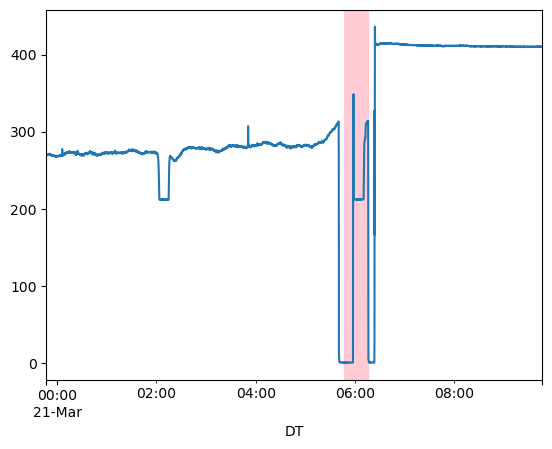

index                                                      935
МАШИНА                                      CH-AGP-AG2/009-005
ТЕХ_МЕСТО                           CH-AGP-AG2/009-005-001-010
НАЗВАНИЕ_ТЕХ_МЕСТА    ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ8 ВУ1
ОПИСАНИЕ                    остановка эксгаустера №8 (2РУ МТЗ)
t2                                         2020-03-21 06:15:51
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          8
label                                                        1
Name: 2020-03-21 05:46:47, dtype: object

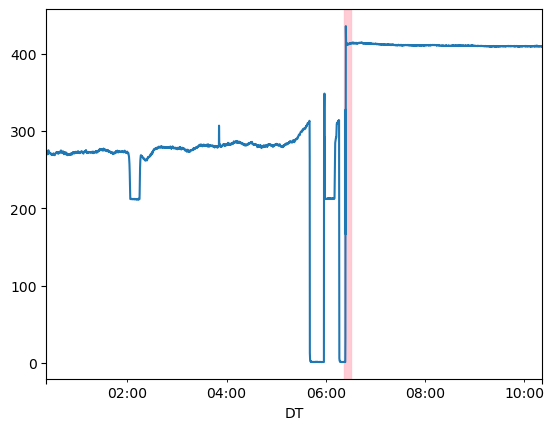

index                                                      937
МАШИНА                                      CH-AGP-AG2/009-005
ТЕХ_МЕСТО                           CH-AGP-AG2/009-005-001-010
НАЗВАНИЕ_ТЕХ_МЕСТА    ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ8 ВУ1
ОПИСАНИЕ                    остановка эксгаустера №8 (2РУ МТЗ)
t2                                         2020-03-21 06:30:53
ТЕКСТ_ГРУППЫ_КОДОВ                      ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                          8
label                                                        1
Name: 2020-03-21 06:21:52, dtype: object

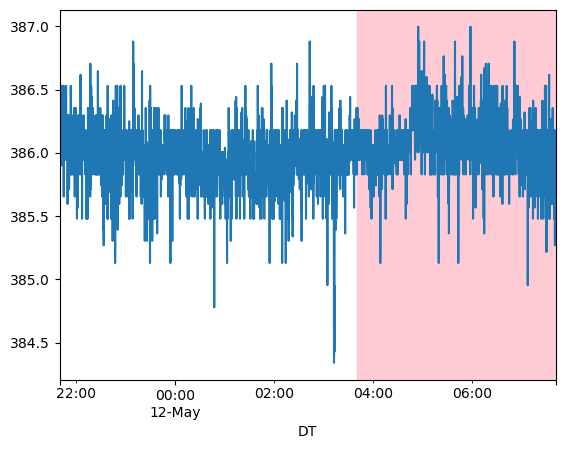

index                                                    1022
МАШИНА                                            AA2/005-006
ТЕХ_МЕСТО                             AA2/005-006-001-012-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8
ОПИСАНИЕ               остановка эк-ра №6 (обрыв цепи ротора)
t2                                        2020-05-12 12:20:42
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         8
label                                                       1
Name: 2020-05-12 03:40:36, dtype: object

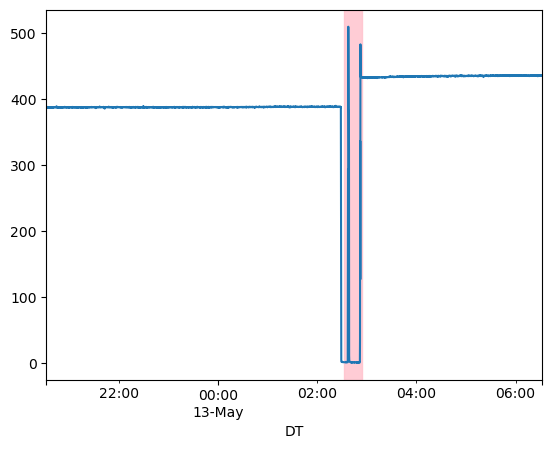

index                                                1030
МАШИНА                                        AA2/005-006
ТЕХ_МЕСТО                             AA2/005-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №8
ОПИСАНИЕ              остановка эк-ра №8 (вибрация в т.3)
t2                                    2020-05-13 02:54:32
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     8
label                                                   1
Name: 2020-05-13 02:32:29, dtype: object

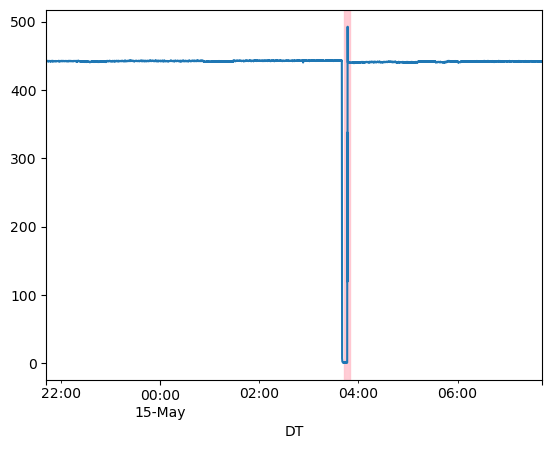

index                                                1035
МАШИНА                                        AA2/005-006
ТЕХ_МЕСТО                             AA2/005-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №8
ОПИСАНИЕ              остановка эк-ра №8 (вибрация в т.3)
t2                                    2020-05-15 03:49:39
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     8
label                                                   1
Name: 2020-05-15 03:42:38, dtype: object

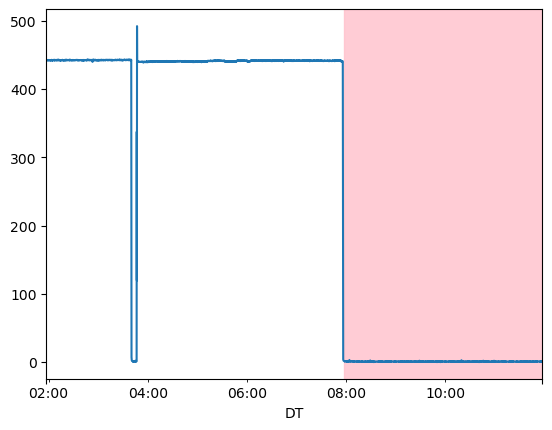

index                                                1039
МАШИНА                                 CH-AGP-AG2/009-005
ТЕХ_МЕСТО                      CH-AGP-AG2/009-005-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №8
ОПИСАНИЕ              остановка эк-ра №8 (вибрация в т.3)
t2                                    2020-05-15 18:26:30
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     8
label                                                   1
Name: 2020-05-15 07:57:11, dtype: object

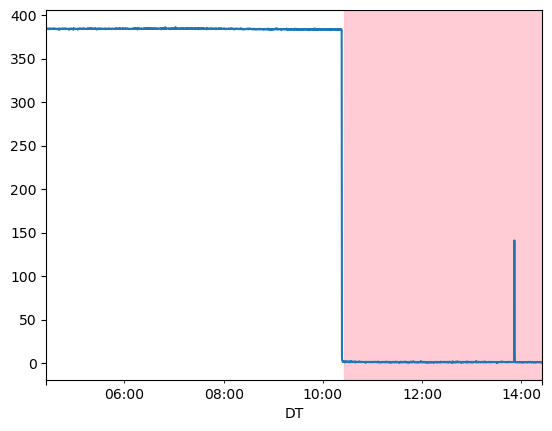

index                                                    1057
МАШИНА                                            AA2/005-006
ТЕХ_МЕСТО                             AA2/005-006-001-012-003
НАЗВАНИЕ_ТЕХ_МЕСТА    ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8
ОПИСАНИЕ              остановка эк-ра №8 (КЗ обмотки статора)
t2                                        2020-05-31 08:32:06
ТЕКСТ_ГРУППЫ_КОДОВ                     ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                         8
label                                                       1
Name: 2020-05-30 10:25:23, dtype: object

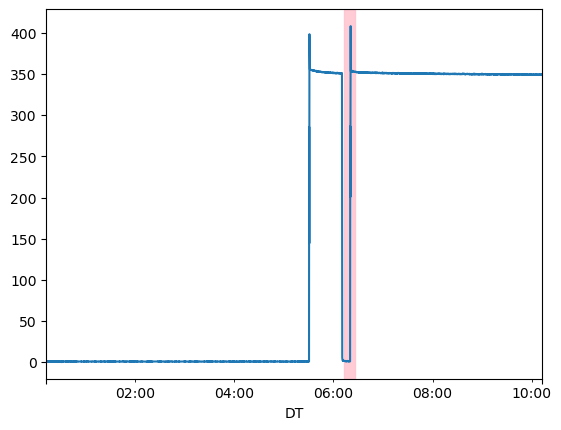

index                                                  1079
МАШИНА                                          AA2/005-006
ТЕХ_МЕСТО                           AA2/005-006-001-005-001
НАЗВАНИЕ_ТЕХ_МЕСТА       ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №8
ОПИСАНИЕ              остановка эк-ра №8 (МТЗ 2РУ с ускор.)
t2                                      2020-06-13 06:25:45
ТЕКСТ_ГРУППЫ_КОДОВ                   ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                       8
label                                                     1
Name: 2020-06-13 06:12:44, dtype: object

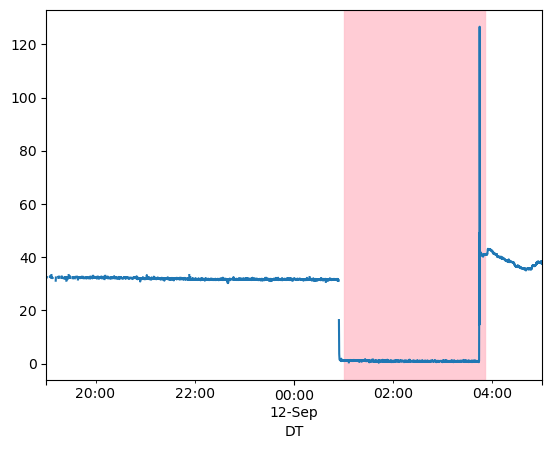

index                                                1264
МАШИНА                                        AA2/005-006
ТЕХ_МЕСТО                             AA2/005-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №8
ОПИСАНИЕ              остановка эк-ра №8 (давление масла)
t2                                    2020-09-12 03:50:47
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     8
label                                                   1
Name: 2020-09-12 01:00:26, dtype: object

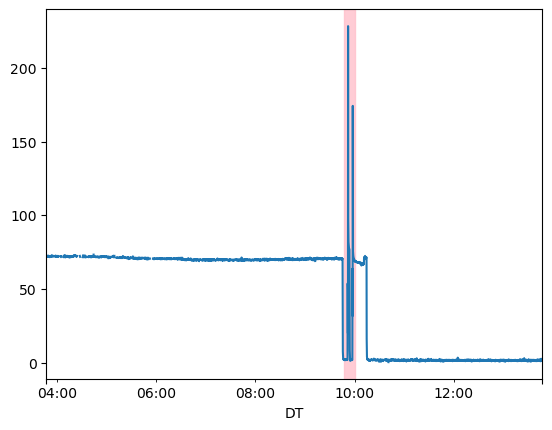

index                                                1600
МАШИНА                                        AA2/005-006
ТЕХ_МЕСТО                             AA2/005-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №8
ОПИСАНИЕ              остановка эк-ра №8 (вибрация в т.3)
t2                                    2021-03-29 10:00:02
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     8
label                                                   1
Name: 2021-03-29 09:47:00, dtype: object

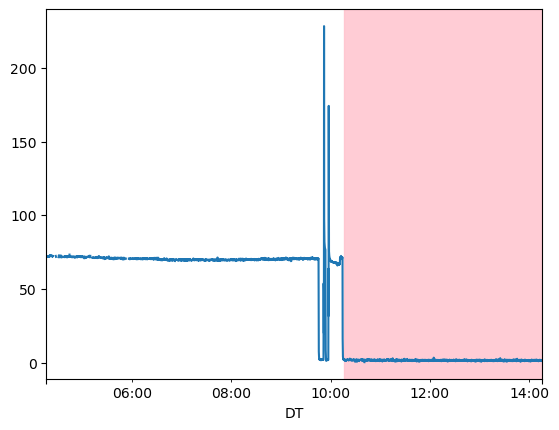

index                                                1602
МАШИНА                                 CH-AGP-AG2/009-005
ТЕХ_МЕСТО                      CH-AGP-AG2/009-005-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №8
ОПИСАНИЕ              остановка эк-ра №8 (вибрация в т.3)
t2                                    2021-03-29 15:24:41
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     8
label                                                   1
Name: 2021-03-29 10:16:04, dtype: object

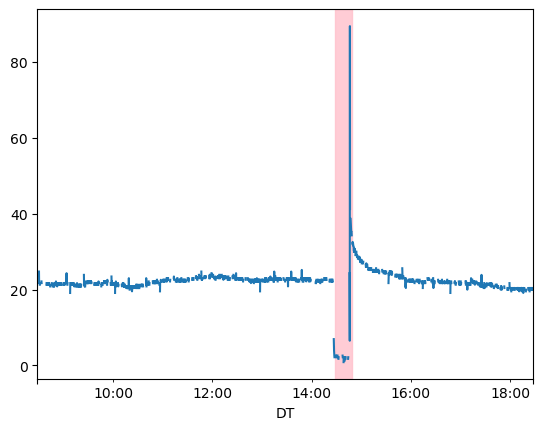

index                                                2100
МАШИНА                                        AA2/005-006
ТЕХ_МЕСТО                             AA2/005-006-001-002
НАЗВАНИЕ_ТЕХ_МЕСТА                         РОТОР ЭКСГ. №8
ОПИСАНИЕ              остановка эксг. №8 (давление масла)
t2                                    2021-11-06 14:48:29
ТЕКСТ_ГРУППЫ_КОДОВ                 ТЕХНИЧЕСКИЕ НЕПЛАНОВЫЕ
num                                                     8
label                                                   1
Name: 2021-11-06 14:28:26, dtype: object

In [94]:
dt1 = pd.Timedelta('6h')
dt2 = pd.Timedelta('4h')


for num in m1['num'].unique():
    df = m1[m1['num']==num].sort_values(by='t1')
    display(df)
    df = df.reset_index().set_index('t1')
    for t in df.index:
        plt.figure()
        X_train[f'ЭКСГАУСТЕР {num}. ТОК РОТОРА 2'][t-dt1:t+dt2].plot()
        plt.axvspan(t,df.loc[t,'t2'],color='pink',alpha=0.8)
        plt.show()
        display(df.loc[t])
        
    

In [78]:
num = 4

In [107]:
eks = X_train[[x for x in X_train.columns if f'ЭКСГАУСТЕР {num}.' in x]]

In [109]:
eks.head()

,ЭКСГАУСТЕР 8. ТОК РОТОРА 1,ЭКСГАУСТЕР 8. ТОК РОТОРА 2,ЭКСГАУСТЕР 8. ТОК СТАТОРА,ЭКСГАУСТЕР 8. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 1,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 2,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.
DT,,,,,,,,,,,,,,,,
2019-01-16 13:21:00,1.450000,1.450000,0.0,4.940000,29.210000,29.210000,28.390000,28.800000,23.530000,25.960000,0.100000,0.070000,0.030000,0.270000,0.060000,0.300000
2019-01-16 13:21:10,1.740000,1.740000,0.0,5.130000,28.881099,29.367858,28.962225,27.580000,23.283353,26.122788,0.085069,0.053819,0.034722,0.228299,0.050347,0.302083
2019-01-16 13:21:20,1.160000,1.160000,0.0,5.283333,29.115464,29.476026,28.935183,28.390000,23.436592,26.411239,0.075231,0.045332,0.031829,0.227623,0.053048,0.289352
2019-01-16 13:21:30,1.678241,1.678241,0.0,4.780093,29.205605,29.205605,28.637719,28.637719,23.526733,26.609549,0.083333,0.047743,0.034722,0.239583,0.055556,0.293403
2019-01-16 13:21:40,1.678241,1.678241,0.0,5.322500,29.043352,29.286731,29.210000,27.580000,22.720000,26.122784,0.079861,0.051215,0.032118,0.234375,0.052951,0.300347


<AxesSubplot:xlabel='DT'>

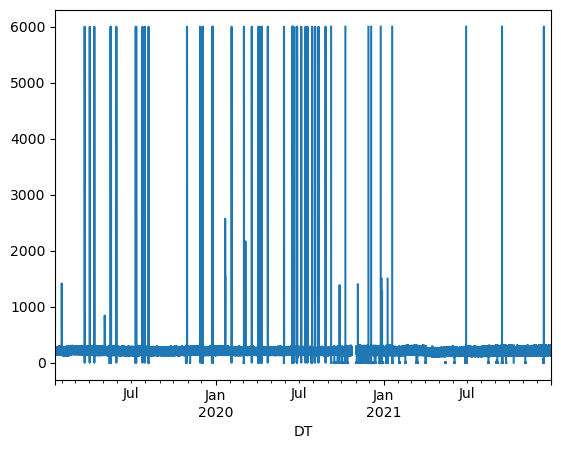

In [82]:
X_train['ЭКСГАУСТЕР 4. ТОК СТАТОРА'].plot()

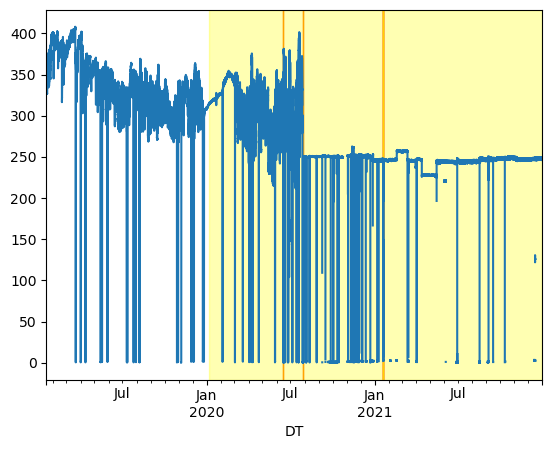

In [76]:
%matplotlib notebook
eks.iloc[::10,0].plot()
notes =  toir[(toir['type']=='РОТОР') & (toir['num']==num) ]
colors = {1:'red',2:'yellow'}
alphas = {1:None,2:0.3}
for label in [1,2]:
    for idx in notes[notes['label']==label].index:
        t1 = toir['start_time'].loc[idx]
        t2 = t1 + toir['duration'].loc[idx]
        plt.axvspan(t1,t2,color=colors[label],alpha=alphas[label])



In [116]:
eks.head()

,ЭКСГАУСТЕР 8. ТОК РОТОРА 1,ЭКСГАУСТЕР 8. ТОК РОТОРА 2,ЭКСГАУСТЕР 8. ТОК СТАТОРА,ЭКСГАУСТЕР 8. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ,ЭКСГАУСТЕР 8. ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 1,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 2,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4,ЭКСГАУСТЕР 8. ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.
DT,,,,,,,,,,,,,,,,
2019-01-16 13:21:00,1.450000,1.450000,0.0,4.940000,29.210000,29.210000,28.390000,28.800000,23.530000,25.960000,0.100000,0.070000,0.030000,0.270000,0.060000,0.300000
2019-01-16 13:21:10,1.740000,1.740000,0.0,5.130000,28.881099,29.367858,28.962225,27.580000,23.283353,26.122788,0.085069,0.053819,0.034722,0.228299,0.050347,0.302083
2019-01-16 13:21:20,1.160000,1.160000,0.0,5.283333,29.115464,29.476026,28.935183,28.390000,23.436592,26.411239,0.075231,0.045332,0.031829,0.227623,0.053048,0.289352
2019-01-16 13:21:30,1.678241,1.678241,0.0,4.780093,29.205605,29.205605,28.637719,28.637719,23.526733,26.609549,0.083333,0.047743,0.034722,0.239583,0.055556,0.293403
2019-01-16 13:21:40,1.678241,1.678241,0.0,5.322500,29.043352,29.286731,29.210000,27.580000,22.720000,26.122784,0.079861,0.051215,0.032118,0.234375,0.052951,0.300347


# Выбор границы t_train t_test

In [120]:
mytoir = pd.read_excel('../data/processed/Processed_toir2.xlsx').set_index('Номер')

In [137]:
for_test = pd.Series(dtype='object')
for fault in mytoir['Причина'].value_counts().index:
    for_test.loc[fault] =  toir.loc[mytoir[mytoir['Причина']==fault].index]['t1'].sort_values().values[-1]
display(for_test.sort_values(ascending=True))
print(round(len(X_train[for_test.values[0]:])/len(X_train)*100,2))

ДвигательТемп      2020-09-27 16:42:02
РоторВибр          2021-03-29 09:47:00
Задвижка           2021-04-18 18:58:57
ЭлектроТиристор    2021-09-23 15:18:26
Масло              2021-11-06 14:28:26
РоторМеханика      2021-12-22 17:29:58
ЭлектроДвигатель   2021-12-29 16:27:02
dtype: datetime64[ns]

25.69


In [160]:
mytoir = mytoir['Причина']

In [166]:
t_test = pd.Timestamp('2020-09-27 16:42:02')

# Создание 1 ой модели

## Подготовка датасета

In [8]:
dt1 = pd.Timedelta('14D')
dt2 = pd.Timedelta('2h')
th_current_volt = 50

Xy = []

for num in nums:
    eks = X_train[[x for x in X_train.columns if f'ЭКСГАУСТЕР {num}. ' in x]].copy()[:t_test]
    eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
    
    eks = eks.fillna(method='pad',limit=60)
    eks = eks[ (eks['ТОК РОТОРА 1']>50) |\
              (eks['ТОК РОТОРА 2']>50) |\
              (eks['ТОК СТАТОРА']>50)]     
    eks['y'] = 'Нормально'
    mini_toir = toir[toir['num']==num]
    idx  = toir.index[toir.index.isin(mytoir.index)]
    for nomer_zap in idx:
        t1 = toir['t1'][nomer_zap] - dt1
        t2 = toir['t1'][nomer_zap] - dt2
        eks['y'][t1:t2] = mytoir[nomer_zap]
    Xy.append(eks.copy().dropna())
Xy = pd.concat(Xy)                                          

X = Xy.copy()
y = X.pop('y')

C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\3351175106.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\3351175106.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eks['y'][t1:t2] = mytoir[nomer_zap]
C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\3351175106.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\3351175106.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

## Обучение системы

In [11]:
from sklearn.neighbors import KNeighborsClassifier
cl = KNeighborsClassifier(n_neighbors=7,
                          n_jobs=-1,
                          metric='mahalanobis',
                          metric_params={'VI': np.cov(X, rowvar= False)},
                         )
cl.fit(X,y)



KNeighborsClassifier(metric='mahalanobis',
                     metric_params={'VI': array([[ 4.07703632e+03,  4.07703613e+03, -6.29358252e+02,
        -2.46533746e+02, -1.38695229e+01, -1.54411201e+01,
         7.07224594e+00, -6.06370756e+00,  6.10858727e+01,
         3.50824729e+01,  2.66009212e+01,  5.04021145e+00,
         2.71469152e+00, -9.02889669e+00,  3.53737584e+00,
         8.76221816e+00],
       [ 4.07703613e+03,  4.07705549e+03, -6...
         2.56962108e-01,  5.25129668e-01,  3.67727865e-01,
         1.27703261e+00,  1.29954992e+00,  1.74593721e+00,
         1.15961263e+00],
       [ 8.76221816e+00,  8.76225154e+00, -1.51165151e+02,
         2.90087128e-01,  9.89259052e-01,  9.58363858e-01,
         2.05326041e-01,  3.17475521e-01,  2.85222496e-01,
        -8.67327555e-01,  4.53132963e-01,  4.04765629e-01,
         9.82126591e-01,  1.14154498e+00,  1.15961263e+00,
         1.41945894e+00]])},
                     n_jobs=-1, n_neighbors=7)

## Инференс

In [182]:
# cl.kneighbors(X,return_distance=False)  


0    Сомневаюсь
1    Сомневаюсь
2    Сомневаюсь
3    Сомневаюсь
4     Нормально
Name: 0, dtype: object

In [53]:
for nomer_zap in mytoir.index:
    if toir['t1'][nomer_zap] < t_test:
        continue
    else:
        num = toir.loc[nomer_zap]['num']
        t1 = toir['t1'][nomer_zap] - pd.Timedelta('1D')
        t2 = toir['t1'][nomer_zap]
        
        eks = X_train[[x for x in X_train.columns if f'ЭКСГАУСТЕР {num}. ' in x]][t1:t2]
        eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
        eks = eks.fillna(method='pad',limit=60)
        eks = eks[ (eks['ТОК РОТОРА 1']>50) |\
                  (eks['ТОК РОТОРА 2']>50) |\
                  (eks['ТОК СТАТОРА']>50)]  
        eks = eks.dropna()

        print(mytoir.loc[nomer_zap])
#         predict = cl.predict(eks[::100])
#         display(pd.Series(predict).value_counts())
        
        predict = cl.kneighbors(eks[::60],return_distance=False)
        predict = pd.DataFrame(predict).apply(lambda x: y.values[x])  
        preditc_new = predict.iloc[:,0].copy()
        predict = pd.concat( [predict.iloc[:,i] == predict.iloc[:,0] for i in range(predict.shape[1])],axis=1).all(axis=1)
        preditc_new[~predict] = 'Сомневаюсь'
        display(pd.Series(preditc_new).value_counts())
        
        print()
        print()
        print()
        
        

C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель


Сомневаюсь         96
ЭлектроТиристор    30
Нормально          13
РоторМеханика       3
Name: 0, dtype: int64




ДвигательТемп


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ДвигательТемп    119
Нормально          6
Сомневаюсь         1
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Сомневаюсь          40
ЭлектроДвигатель    20
РоторМеханика       12
Нормально            8
ЭлектроТиристор      3
ДвигательТемп        1
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    53
Сомневаюсь          40
Нормально            6
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    54
Сомневаюсь          37
Нормально            3
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    40
Сомневаюсь          13
Нормально            9
РоторВибр            3
РоторМеханика        1
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально     81
Сомневаюсь    26
Масло         17
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально           53
Сомневаюсь          30
ЭлектроДвигатель    17
РоторМеханика        2
РоторВибр            1
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально           97
ЭлектроДвигатель    26
Сомневаюсь          10
Масло                1
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    112
Сомневаюсь           18
Нормально             9
Name: 0, dtype: int64




РоторМеханика


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Сомневаюсь          74
Нормально           54
ЭлектроДвигатель     8
Масло                4
Name: 0, dtype: int64




Задвижка


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально        92
Сомневаюсь       51
ДвигательТемп     1
Name: 0, dtype: int64




Задвижка


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    81
Сомневаюсь          36
Масло               21
Нормально            3
Name: 0, dtype: int64




ЭлектроТиристор


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально        101
Сомневаюсь        24
РоторМеханика     16
РоторВибр          1
Name: 0, dtype: int64




РоторВибр


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


РоторМеханика       82
Сомневаюсь          53
Нормально            5
ЭлектроДвигатель     1
Name: 0, dtype: int64




Масло


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально           125
Сомневаюсь           14
ЭлектроДвигатель      1
Name: 0, dtype: int64




Масло


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    78
Сомневаюсь          42
Нормально           12
Name: 0, dtype: int64




Масло


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Нормально           123
Сомневаюсь           17
ЭлектроДвигатель      1
Name: 0, dtype: int64




РоторВибр


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


ЭлектроДвигатель    61
Сомневаюсь          48
Нормально           32
Масло                2
РоторВибр            1
Name: 0, dtype: int64




РоторВибр


C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Сомневаюсь       107
Масло             25
ДвигательТемп      6
РоторМеханика      5
Name: 0, dtype: int64

C:\Users\kompn\AppData\Local\Temp\ipykernel_4640\1700302275.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')


Масло


ДвигательТемп    142
Сомневаюсь         2
Name: 0, dtype: int64

# Create y_test

In [77]:
y_test = pd.read_excel('../data/test_intervals.xlsx').set_index('Unnamed: 0')#.rename(columns={'start':'t1'})
y_test.head(1)

,start,finish,machine,tm
Unnamed: 0,,,,
97,2022-01-01 10:54:53,2022-01-01 16:43:39,NaN,NaN


In [79]:
# y_test

In [ ]:
dt1_new = pd.Timedelta('10D')

for nomer_zap in y_test.index:
    print('================================================')
    print('Номер записи',nomer_zap)
    t = y_test['start'].loc[nomer_zap]
    
    t1 = t - dt1_new
    t2 = t
    
    all_eks_result_predict = pd.DataFrame(columns=['num','percent','fualt'])
    for num in nums:
        print(f'ЭКС №{num}')
        if num==8:
            continue
        
        eks = X_test[[x for x in X_test.columns if f'ЭКСГАУСТЕР {num}. ' in x]][t1:t2]
        eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','', regex=False)
        eks = eks.fillna(method='pad',limit=60)
        eks = eks[ (eks['ТОК РОТОРА 1']>50) |\
                  (eks['ТОК РОТОРА 2']>50) |\
                  (eks['ТОК СТАТОРА']>50)]  
        eks = eks.dropna()
        if len(eks)==0:
            print('Нет данных ')
            continue
        
        t1 = eks.index[-1] - pd.Timedelta('1D')
        eks = eks[t1:t2]
        

        predict = cl.kneighbors(eks[::60],return_distance=False)
        predict = pd.DataFrame(predict).apply(lambda x: y.values[x])  
        preditc_new = predict.iloc[:,0].copy()
        predict = pd.concat( [predict.iloc[:,i] == predict.iloc[:,0] for i in range(predict.shape[1])],axis=1).all(axis=1)
        preditc_new[~predict] = 'Сомневаюсь'
        predict = pd.Series(preditc_new).value_counts()
        display(predict)
        
        all_eks_result_predict.loc[len(all_eks_result_predict)] = [num,
                                                                   predict.values[0]/predict.sum()*100,
                                                                   predict.index[0]]

    display(all_eks_result_predict)
    all_eks_result_predict = all_eks_result_predict[all_eks_result_predict['fualt']!='Сомневаюсь']
    all_eks_result_predict = all_eks_result_predict[all_eks_result_predict['fualt']!='Нормально']
    if len(all_eks_result_predict)>0:
        res_fot_zap = all_eks_result_predict.sort_values(by='percent',ascending=False).iloc[0]
        display(res_fot_zap)
        y_test.loc[nomer_zap,'machine'] = 'ЭКСГАУСТЕР А/М №' + str(res_fot_zap['num'])
        
        minimin_toir = toir.loc[mytoir[mytoir ==  res_fot_zap['fualt']].index]
        if len(minimin_toir[minimin_toir['num']==res_fot_zap['num']])==0:
            y_test.loc[nomer_zap,'tm'] =  minimin_toir['НАЗВАНИЕ_ТЕХ_МЕСТА'].values[0]
        else:
            y_test.loc[nomer_zap,'tm'] =  minimin_toir[minimin_toir['num']==res_fot_zap['num']]\
            ['НАЗВАНИЕ_ТЕХ_МЕСТА'].values[0]
        y_test.to_excel('submission_1.xlsx')

    else:
        pass        
    print('================================================')
    print()

Номер записи 97
ЭКС №4


Сомневаюсь       51
РоторМеханика     9
Нормально         3
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          51
ЭлектроДвигатель    10
Масло                4
Нормально            1
Name: 0, dtype: int64

ЭКС №6


РоторМеханика    55
Сомневаюсь        7
Name: 0, dtype: int64

ЭКС №7


Нормально     64
Сомневаюсь     2
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Нормально          27
Сомневаюсь         24
ЭлектроТиристор    14
РоторМеханика       1
Name: 0, dtype: int64

,num,percent,fualt
0,4,80.952381,Сомневаюсь
1,5,77.272727,Сомневаюсь
2,6,88.709677,РоторМеханика
3,7,96.969697,Нормально
4,9,40.909091,Нормально


num                    6
percent        88.709677
fualt      РоторМеханика
Name: 2, dtype: object


Номер записи 118
ЭКС №4


Сомневаюсь       105
РоторМеханика      5
Нормально          1
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          56
Нормально           30
ЭлектроДвигатель    19
Масло               10
РоторВибр            1
Name: 0, dtype: int64

ЭКС №6


РоторМеханика    86
Сомневаюсь       25
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь          59
Нормально           34
РоторМеханика       11
РоторВибр            9
ЭлектроДвигатель     6
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь          66
Нормально           46
ЭлектроТиристор      3
ЭлектроДвигатель     2
РоторМеханика        2
Name: 0, dtype: int64

,num,percent,fualt
0,4,94.594595,Сомневаюсь
1,5,48.275862,Сомневаюсь
2,6,77.477477,РоторМеханика
3,7,49.579832,Сомневаюсь
4,9,55.462185,Сомневаюсь


num                    6
percent        77.477477
fualt      РоторМеханика
Name: 2, dtype: object


Номер записи 126
ЭКС №4


Сомневаюсь       98
Нормально        35
РоторМеханика     4
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          71
Нормально           49
Масло               23
ЭлектроДвигатель     1
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          70
ЭлектроДвигатель    66
Нормально            2
ЭлектроТиристор      1
РоторМеханика        1
Name: 0, dtype: int64

ЭКС №7


Нормально           101
Сомневаюсь           27
ЭлектроДвигатель     15
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь          66
Нормально           16
РоторМеханика       12
ЭлектроТиристор      8
РоторВибр            5
ДвигательТемп        1
ЭлектроДвигатель     1
Name: 0, dtype: int64

,num,percent,fualt
0,4,71.532847,Сомневаюсь
1,5,49.305556,Сомневаюсь
2,6,50.000000,Сомневаюсь
3,7,70.629371,Нормально
4,9,60.550459,Сомневаюсь



Номер записи 163
ЭКС №4


Сомневаюсь       93
Нормально        23
РоторМеханика     5
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь    77
Масло         26
Нормально     24
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          71
ЭлектроДвигатель    46
РоторМеханика        3
ЭлектроТиристор      1
Name: 0, dtype: int64

ЭКС №7


Нормально           102
Сомневаюсь           20
ЭлектроДвигатель      2
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь          73
Нормально           17
РоторМеханика       17
РоторВибр           16
ЭлектроТиристор      2
ЭлектроДвигатель     1
Name: 0, dtype: int64

,num,percent,fualt
0,4,76.859504,Сомневаюсь
1,5,60.629921,Сомневаюсь
2,6,58.677686,Сомневаюсь
3,7,82.258065,Нормально
4,9,57.936508,Сомневаюсь



Номер записи 0
ЭКС №4


Сомневаюсь       103
Нормально         11
РоторМеханика      8
Name: 0, dtype: int64

ЭКС №5


Нормально           113
Сомневаюсь           30
ЭлектроДвигатель      1
Name: 0, dtype: int64

ЭКС №6


РоторМеханика    115
Сомневаюсь        21
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь         70
РоторВибр          41
ЭлектроТиристор    13
РоторМеханика       5
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь       68
РоторВибр        63
РоторМеханика    12
Нормально         2
Name: 0, dtype: int64

,num,percent,fualt
0,4,84.426230,Сомневаюсь
1,5,78.472222,Нормально
2,6,84.558824,РоторМеханика
3,7,54.263566,Сомневаюсь
4,9,46.896552,Сомневаюсь


num                    6
percent        84.558824
fualt      РоторМеханика
Name: 2, dtype: object


Номер записи 96
ЭКС №4


Сомневаюсь       74
Нормально        17
РоторМеханика    11
Name: 0, dtype: int64

ЭКС №5


Нормально     96
Сомневаюсь    11
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          58
Нормально           28
РоторМеханика       15
ЭлектроДвигатель     4
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь          53
ЭлектроДвигатель    44
Нормально            9
РоторВибр            2
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


РоторМеханика    45
Сомневаюсь       43
РоторВибр        27
Name: 0, dtype: int64

,num,percent,fualt
0,4,72.549020,Сомневаюсь
1,5,89.719626,Нормально
2,6,55.238095,Сомневаюсь
3,7,49.074074,Сомневаюсь
4,9,39.130435,РоторМеханика


num                    9
percent        39.130435
fualt      РоторМеханика
Name: 4, dtype: object


Номер записи 108
ЭКС №4


Сомневаюсь       86
Нормально        25
РоторМеханика     7
РоторВибр         1
Name: 0, dtype: int64

ЭКС №5


Нормально     94
Сомневаюсь     8
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          78
ЭлектроДвигатель    26
Нормально           12
РоторМеханика        2
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь          60
ЭлектроДвигатель    40
Нормально           26
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


РоторМеханика    97
Сомневаюсь       30
Name: 0, dtype: int64

,num,percent,fualt
0,4,72.268908,Сомневаюсь
1,5,92.156863,Нормально
2,6,66.101695,Сомневаюсь
3,7,47.619048,Сомневаюсь
4,9,76.377953,РоторМеханика


num                    9
percent        76.377953
fualt      РоторМеханика
Name: 4, dtype: object


Номер записи 103
ЭКС №4


Сомневаюсь       105
Нормально         14
РоторМеханика     13
Name: 0, dtype: int64

ЭКС №5


Нормально     117
Сомневаюсь     20
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          96
Нормально           15
РоторМеханика       13
ЭлектроДвигатель    12
ЭлектроТиристор      1
Name: 0, dtype: int64

ЭКС №7


Нормально           112
Сомневаюсь           28
ЭлектроДвигатель      1
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь         83
ЭлектроТиристор    36
РоторМеханика      18
Нормально           7
Name: 0, dtype: int64

,num,percent,fualt
0,4,79.545455,Сомневаюсь
1,5,85.401460,Нормально
2,6,70.072993,Сомневаюсь
3,7,79.432624,Нормально
4,9,57.638889,Сомневаюсь



Номер записи 127
ЭКС №4


Сомневаюсь       87
РоторМеханика    27
Нормально         9
Name: 0, dtype: int64

ЭКС №5


Нормально           55
Сомневаюсь          54
ЭлектроДвигатель    32
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь       65
РоторМеханика    59
Нормально        10
ДвигательТемп     1
Name: 0, dtype: int64

ЭКС №7


Нормально           58
Сомневаюсь          44
ЭлектроТиристор     37
ЭлектроДвигатель     1
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь         103
ЭлектроТиристор     29
РоторМеханика        6
Нормально            6
Name: 0, dtype: int64

,num,percent,fualt
0,4,70.731707,Сомневаюсь
1,5,39.007092,Нормально
2,6,48.148148,Сомневаюсь
3,7,41.428571,Нормально
4,9,71.527778,Сомневаюсь



Номер записи 106
ЭКС №4


Сомневаюсь       59
Нормально        44
РоторМеханика    30
Name: 0, dtype: int64

ЭКС №5


Нормально           64
Сомневаюсь          41
ЭлектроДвигатель    25
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь       73
Нормально        64
РоторМеханика     3
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь          26
ЭлектроТиристор     25
Нормально           20
ДвигательТемп        3
РоторМеханика        2
ЭлектроДвигатель     1
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь          94
Нормально           27
РоторМеханика       17
ЭлектроТиристор      4
ЭлектроДвигатель     2
Name: 0, dtype: int64

,num,percent,fualt
0,4,44.360902,Сомневаюсь
1,5,49.230769,Нормально
2,6,52.142857,Сомневаюсь
3,7,33.766234,Сомневаюсь
4,9,65.277778,Сомневаюсь



Номер записи 109
ЭКС №4


Сомневаюсь       75
Нормально        27
РоторМеханика    11
ДвигательТемп     1
Name: 0, dtype: int64

ЭКС №5


Нормально           92
ЭлектроДвигатель     5
Сомневаюсь           5
Name: 0, dtype: int64

ЭКС №6


Нормально           71
Сомневаюсь          42
ЭлектроДвигатель     1
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь          38
ЭлектроТиристор     32
ЭлектроДвигатель    18
Нормально            6
РоторМеханика        1
ДвигательТемп        1
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь          78
Нормально           20
РоторМеханика       10
ЭлектроДвигатель     5
ЭлектроТиристор      2
Name: 0, dtype: int64

,num,percent,fualt
0,4,65.789474,Сомневаюсь
1,5,90.196078,Нормально
2,6,62.280702,Нормально
3,7,39.583333,Сомневаюсь
4,9,67.826087,Сомневаюсь



Номер записи 151
ЭКС №4


Сомневаюсь       116
РоторМеханика     18
Нормально         10
Name: 0, dtype: int64

ЭКС №5


ЭлектроДвигатель    65
Сомневаюсь          44
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          74
Нормально           64
РоторМеханика        3
ЭлектроДвигатель     3
Name: 0, dtype: int64

ЭКС №7


Нормально           137
Сомневаюсь            6
ЭлектроДвигатель      1
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь       101
РоторВибр         33
РоторМеханика      9
Нормально          1
Name: 0, dtype: int64

,num,percent,fualt
0,4,80.555556,Сомневаюсь
1,5,59.633028,ЭлектроДвигатель
2,6,51.388889,Сомневаюсь
3,7,95.138889,Нормально
4,9,70.138889,Сомневаюсь


num                       5
percent           59.633028
fualt      ЭлектроДвигатель
Name: 1, dtype: object


Номер записи 79
ЭКС №4


Сомневаюсь       99
Нормально        12
РоторМеханика     8
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          44
Нормально           17
ЭлектроДвигатель     6
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          80
Нормально           27
ЭлектроДвигатель    17
РоторМеханика        1
Name: 0, dtype: int64

ЭКС №7


Нормально           105
Сомневаюсь           18
ЭлектроДвигатель      2
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь       105
РоторВибр         19
РоторМеханика      1
Name: 0, dtype: int64

,num,percent,fualt
0,4,83.193277,Сомневаюсь
1,5,65.671642,Сомневаюсь
2,6,64.000000,Сомневаюсь
3,7,84.000000,Нормально
4,9,84.000000,Сомневаюсь



Номер записи 93
ЭКС №4


Сомневаюсь       75
Нормально        58
РоторМеханика    10
РоторВибр         1
Name: 0, dtype: int64

ЭКС №5


Нормально     142
Сомневаюсь      2
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          118
Нормально            23
ЭлектроДвигатель      3
Name: 0, dtype: int64

ЭКС №7


Нормально          120
Сомневаюсь          17
ЭлектроТиристор      7
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь       79
РоторМеханика    43
Нормально        18
РоторВибр         3
ДвигательТемп     1
Name: 0, dtype: int64

,num,percent,fualt
0,4,52.083333,Сомневаюсь
1,5,98.611111,Нормально
2,6,81.944444,Сомневаюсь
3,7,83.333333,Нормально
4,9,54.861111,Сомневаюсь



Номер записи 92
ЭКС №4


ЭлектроДвигатель    45
Сомневаюсь          23
РоторМеханика        3
Name: 0, dtype: int64

ЭКС №5


Нормально     43
Сомневаюсь     4
Масло          3
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          66
Нормально           20
ЭлектроДвигатель     2
ЭлектроТиристор      1
Name: 0, dtype: int64

ЭКС №7


Нормально           53
ЭлектроТиристор     50
Сомневаюсь          38
ЭлектроДвигатель     2
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь         96
РоторВибр          25
ЭлектроТиристор    18
РоторМеханика       3
Нормально           2
Name: 0, dtype: int64

,num,percent,fualt
0,4,63.380282,ЭлектроДвигатель
1,5,86.000000,Нормально
2,6,74.157303,Сомневаюсь
3,7,37.062937,Нормально
4,9,66.666667,Сомневаюсь


num                       4
percent           63.380282
fualt      ЭлектроДвигатель
Name: 0, dtype: object


Номер записи 134
ЭКС №4


ЭлектроДвигатель    93
Сомневаюсь          23
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          95
ЭлектроДвигатель    23
ДвигательТемп       20
РоторМеханика        1
Нормально            1
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь          73
ЭлектроДвигатель    54
Нормально            6
РоторВибр            1
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь         57
Нормально          44
ЭлектроТиристор    43
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь          84
РоторВибр           56
РоторМеханика        3
ЭлектроДвигатель     1
Name: 0, dtype: int64

,num,percent,fualt
0,4,80.172414,ЭлектроДвигатель
1,5,67.857143,Сомневаюсь
2,6,54.477612,Сомневаюсь
3,7,39.583333,Сомневаюсь
4,9,58.333333,Сомневаюсь


num                       4
percent           80.172414
fualt      ЭлектроДвигатель
Name: 0, dtype: object


Номер записи 182
ЭКС №4


ЭлектроДвигатель    90
Сомневаюсь          48
Name: 0, dtype: int64

ЭКС №5


РоторМеханика       110
Сомневаюсь           25
Нормально             6
ЭлектроДвигатель      1
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь         60
Нормально          60
ЭлектроТиристор    16
Задвижка            1
Name: 0, dtype: int64

ЭКС №7


ЭлектроТиристор    106
Нормально           19
Сомневаюсь          18
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Нормально           135
Сомневаюсь            7
ЭлектроДвигатель      1
Name: 0, dtype: int64

,num,percent,fualt
0,4,65.217391,ЭлектроДвигатель
1,5,77.464789,РоторМеханика
2,6,43.795620,Сомневаюсь
3,7,74.125874,ЭлектроТиристор
4,9,94.405594,Нормально


num                    5
percent        77.464789
fualt      РоторМеханика
Name: 1, dtype: object


Номер записи 102
ЭКС №4


Сомневаюсь          80
ЭлектроДвигатель    24
ЭлектроТиристор      6
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          35
ЭлектроДвигатель     9
ЭлектроТиристор      6
Нормально            3
ДвигательТемп        1
Name: 0, dtype: int64

ЭКС №6


Нормально     83
Сомневаюсь    49
РоторВибр      1
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь          20
Нормально            8
ЭлектроДвигатель     3
РоторМеханика        2
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


ЭлектроТиристор    117
Сомневаюсь          15
Нормально           12
Name: 0, dtype: int64

,num,percent,fualt
0,4,72.727273,Сомневаюсь
1,5,64.814815,Сомневаюсь
2,6,62.406015,Нормально
3,7,60.606061,Сомневаюсь
4,9,81.250000,ЭлектроТиристор


num                      9
percent              81.25
fualt      ЭлектроТиристор
Name: 4, dtype: object


Номер записи 1
ЭКС №4


Сомневаюсь          89
ЭлектроДвигатель    13
ЭлектроТиристор     10
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь       12
Нормально         2
Масло             2
ДвигательТемп     1
Name: 0, dtype: int64

ЭКС №6


Нормально     62
Сомневаюсь    58
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь          24
Нормально           23
Масло                4
ЭлектроДвигатель     3
РоторМеханика        2
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


ЭлектроТиристор     75
Сомневаюсь          23
Нормально           17
ЭлектроДвигатель     6
Name: 0, dtype: int64

,num,percent,fualt
0,4,79.464286,Сомневаюсь
1,5,70.588235,Сомневаюсь
2,6,51.666667,Нормально
3,7,42.857143,Сомневаюсь
4,9,61.983471,ЭлектроТиристор


num                      9
percent          61.983471
fualt      ЭлектроТиристор
Name: 4, dtype: object


Номер записи 87
ЭКС №4


Сомневаюсь          82
ЭлектроДвигатель    50
Нормально           12
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь          79
ЭлектроДвигатель    36
ДвигательТемп       29
Name: 0, dtype: int64

ЭКС №6


Нормально     141
Сомневаюсь      3
Name: 0, dtype: int64

ЭКС №7


Сомневаюсь         92
Нормально          46
ЭлектроТиристор     3
РоторВибр           2
РоторМеханика       1
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь       88
Нормально        49
РоторМеханика     7
Name: 0, dtype: int64

,num,percent,fualt
0,4,56.944444,Сомневаюсь
1,5,54.861111,Сомневаюсь
2,6,97.916667,Нормально
3,7,63.888889,Сомневаюсь
4,9,61.111111,Сомневаюсь



Номер записи 132
ЭКС №4


Сомневаюсь          81
ЭлектроДвигатель    49
Нормально            8
ЭлектроТиристор      6
Name: 0, dtype: int64

ЭКС №5


Нормально        73
Сомневаюсь       48
ДвигательТемп    23
Name: 0, dtype: int64

ЭКС №6


Нормально           67
ЭлектроДвигатель    45
Сомневаюсь          32
Name: 0, dtype: int64

ЭКС №7


Нормально     125
Сомневаюсь     19
Name: 0, dtype: int64

ЭКС №8
ЭКС №9


Сомневаюсь       75
Нормально        40
РоторМеханика    29
Name: 0, dtype: int64

,num,percent,fualt
0,4,56.250000,Сомневаюсь
1,5,50.694444,Нормально
2,6,46.527778,Нормально
3,7,86.805556,Нормально
4,9,52.083333,Сомневаюсь



Номер записи 2
ЭКС №4


ЭлектроДвигатель    84
Сомневаюсь          58
ЭлектроТиристор      2
Name: 0, dtype: int64

ЭКС №5


Сомневаюсь       70
Нормально        58
ДвигательТемп    16
Name: 0, dtype: int64

ЭКС №6


Сомневаюсь    90
Нормально     48
Задвижка       6
Name: 0, dtype: int64

ЭКС №7


In [67]:
 res_fot_zap['fualt']

'ДвигательТемп'

In [76]:
y_test.loc[nomer_zap,'tm']

'ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5'

In [ ]:
y_test

In [226]:
predict

Нормально    32
dtype: int64

num                    8
percent        92.361721
fualt      ДвигательТемп
Name: 0, dtype: object

In [217]:
predict.iloc[0]

1052

In [209]:
predict= pd.Series(predict).value_counts()

In [210]:
predict_many = []

In [213]:
predict_many.append(predict)

In [214]:
predict_many = pd.concat(predict_many,axis=1)

In [215]:
predict_many

,0,1,2
ДвигательТемп,1052,1052,1052
Нормально,42,42,42
Масло,38,38,38
ЭлектроТиристор,7,7,7


In [218]:
mytoir.value_counts()

РоторВибр           11
ЭлектроТиристор     10
РоторМеханика       10
ЭлектроДвигатель     8
Масло                6
Задвижка             5
ДвигательТемп        4
Name: Причина, dtype: int64

In [200]:
%%time
# cl.predict(eks[:3])
# cl.predict(eks[::100])

CPU times: total: 11min 55s
Wall time: 1min 30s


array(['Нормально', 'Нормально', 'Масло', 'Масло', 'Масло', 'Масло',
       'Масло', 'Масло', 'ЭлектроТиристор', 'Масло', 'Масло', 'Масло',
       'Масло', 'ЭлектроТиристор', 'ЭлектроТиристор', 'Нормально',
       'Нормально', 'Нормально', 'Нормально', 'Нормально', 'Нормально',
       'Нормально', 'Нормально', 'Масло', 'Нормально', 'Нормально',
       'Нормально', 'Нормально', 'Нормально', 'РоторМеханика',
       'Нормально', 'РоторМеханика', 'РоторМеханика', 'Нормально',
       'Нормально', 'ЭлектроТиристор', 'РоторМеханика', 'Нормально',
       'Нормально', 'Масло', 'РоторМеханика', 'РоторМеханика',
       'РоторМеханика', 'РоторМеханика', 'Нормально', 'Нормально',
       'Нормально', 'Нормально', 'РоторВибр', 'Нормально', 'Нормально',
       'Нормально', 'Нормально', 'РоторМеханика', 'Нормально',
       'РоторВибр', 'Нормально', 'РоторВибр', 'Нормально', 'РоторВибр',
       'Нормально', 'Нормально', 'Нормально', 'Нормально',
       'РоторМеханика', 'РоторВибр', 'Нормально', 'Нормаль

In [188]:
pd.Series(predict)

Нормально    10
dtype: int64

# Модель №2

In [15]:
dt1 = pd.Timedelta('14D')
dt2 = pd.Timedelta('2h')
th_current_volt = 50

Xy = []

for num in nums:
    eks = X_train[[x for x in X_train.columns if f'ЭКСГАУСТЕР {num}. ' in x]].copy()[:t_test]
    eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
    
    eks = eks.fillna(method='pad',limit=60)
    eks = eks[ (eks['ТОК РОТОРА 1']>50) |\
              (eks['ТОК РОТОРА 2']>50) |\
              (eks['ТОК СТАТОРА']>50)]     
    eks['y'] = 'Нормально'
    mini_toir = toir[toir['num']==num]
    idx  = toir.index[toir.index.isin(mytoir.index)]
    for nomer_zap in idx:
        t1 = toir['t1'][nomer_zap] - dt1
        t2 = toir['t1'][nomer_zap] - dt2
        eks['y'][t1:t2] = mytoir[nomer_zap]
    Xy.append(eks.copy().dropna())
Xy = pd.concat(Xy)                                          



C:\Users\kompn\AppData\Local\Temp\ipykernel_8772\1781959608.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
C:\Users\kompn\AppData\Local\Temp\ipykernel_8772\1781959608.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eks['y'][t1:t2] = mytoir[nomer_zap]
C:\Users\kompn\AppData\Local\Temp\ipykernel_8772\1781959608.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  eks.columns = eks.columns.str.replace(f'ЭКСГАУСТЕР {num}. ','')
C:\Users\kompn\AppData\Local\Temp\ipykernel_8772\1781959608.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

(2949, 17)

In [ ]:
%%time
from sklearn.gaussian_process import GaussianProcessClassifier
X = Xy[::1000].copy()
y = X.pop('y')
cl = GaussianProcessClassifier(n_jobs=-1)
cl.fit(X,y)


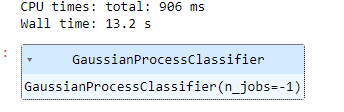